# Evaluating your SAE

In [1]:
import os
os.getcwd()

'/workspace/ViT-Prisma/src/vit_prisma/sae/evals'

In [2]:
import einops
import torch
import torchvision

import plotly.express as px

from tqdm import tqdm

import numpy as np
import os
import requests

# Setup

In [3]:
from dataclasses import dataclass
from vit_prisma.sae.config import VisionModelSAERunnerConfig

selected_sae_weights = "sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001/n_images_2600058.pt"

# int(selected_sae_weights.split("layer")[1].split("-")[1])
selected_sae_layer = int(selected_sae_weights.split("layer")[1].split("-")[1])
selected_sae_hook_point = "resid_post"

saved_sae_dir_path = ""

@dataclass
class EvalConfig(VisionModelSAERunnerConfig):
    sae_path: str = f'/workspace/sae_checkpoints/{selected_sae_weights}'
    model_name: str = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
    model_type: str =  "clip"
    patch_size: str = 32

    dataset_path = "/workspace"
    dataset_train_path: str = "/workspace/ILSVRC/Data/CLS-LOC/train"
    dataset_val_path: str = "/workspace/ILSVRC/Data/CLS-LOC/val"

    verbose: bool = True

    device: bool = 'cuda'

    eval_max: int = 50_000 # 50_000
    batch_size: int = 32
        
#     hook_point_layer: int = 11
    # make the max image output folder a subfolder of the sae path


    @property
    def max_image_output_folder(self) -> str:
        # Get the base directory of sae_checkpoints
        sae_base_dir = os.path.dirname(os.path.dirname(self.sae_path))
        
        # Get the name of the original SAE checkpoint folder
        sae_folder_name = os.path.basename(os.path.dirname(self.sae_path))
        
        # Create a new folder path in sae_checkpoints/images with the original name
        output_folder = os.path.join(sae_base_dir, 'max_images', sae_folder_name)
        output_folder = os.path.join(output_folder, f"layer_{self.hook_point_layer}") # Add layer number

        
        # Ensure the directory exists
        os.makedirs(output_folder, exist_ok=True)
        
        return output_folder

cfg = EvalConfig()

print(f"Layer: {selected_sae_layer}")
print(f"Hook Point: {selected_sae_hook_point}")


n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 15869
Expansion factor: 16
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder
Layer: 11
Hook Point: resid_post


In [4]:
torch.set_grad_enabled(False)

## Load model

In [5]:
from vit_prisma.models.base_vit import HookedViT

model_name = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
model = HookedViT.from_pretrained(model_name, is_timm=False, is_clip=True).to(cfg.device)
 

model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Official model name open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Converting OpenCLIP weights
model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
visual projection shape torch.Size([768, 512])
Setting center_writing_weights to False for OpenCLIP
Setting fold_ln to False for OpenCLIP
Loaded pretrained model open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K into HookedTransformer


## Load datasets

In [6]:
import importlib
import vit_prisma
# importlib.reload(vit_prisma.dataloaders.imagenet_dataset)

In [7]:
# load dataset
import open_clip
from vit_prisma.utils.data_utils.imagenet_utils import setup_imagenet_paths
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_transforms_clip, ImageNetValidationDataset

from torchvision import transforms
from transformers import CLIPProcessor

og_model_name = "hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
og_model, _, preproc = open_clip.create_model_and_transforms(og_model_name)
processor = preproc

size=224

data_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                     std=[0.26862954, 0.26130258, 0.27577711]),
])
    
imagenet_paths = setup_imagenet_paths(cfg.dataset_path)
imagenet_paths["train"] = "/workspace/ILSVRC/Data/CLS-LOC/train"
imagenet_paths["val"] = "/workspace/ILSVRC/Data/CLS-LOC/val"
imagenet_paths["val_labels"] = "/workspace/LOC_val_solution.csv"
imagenet_paths["label_strings"] = "/workspace/LOC_synset_mapping.txt"
print()
train_data = torchvision.datasets.ImageFolder(cfg.dataset_train_path, transform=data_transforms)
val_data = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'], 
                                data_transforms,
                                return_index=True,
)
val_data_visualize = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'],
                                torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),]), return_index=True)

print(f"Validation data length: {len(val_data)}") if cfg.verbose else None



Validation data length: 50000


In [8]:
from vit_prisma.sae.training.activations_store import VisionActivationsStore
# import dataloader
from torch.utils.data import DataLoader

# activations_loader = VisionActivationsStore(cfg, model, train_data, eval_dataset=val_data)
val_dataloader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False, num_workers=4)


## Load pretrained SAE to evaluate

In [9]:
from vit_prisma.sae.sae import SparseAutoencoder
sparse_autoencoder = SparseAutoencoder(cfg).load_from_pretrained(f"/workspace/saved_saes/{selected_sae_weights}")
sparse_autoencoder.to(cfg.device)
sparse_autoencoder.eval()  # prevents error if we're expecting a dead neuron mask for who 

# topk config needs editing for this to work

get_activation_fn received: activation_fn=relu, kwargs={}
n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 1586
Expansion factor: 64
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder
get_activation_fn received: activation_fn=relu, kwargs={}


SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
  (activation_fn): ReLU()
)

## Clip Labeling AutoInterp

In [10]:
# all_imagenet_class_names

In [11]:
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_index_to_name
ind_to_name = get_imagenet_index_to_name()

all_imagenet_class_names = []
for i in range(len(ind_to_name)):
    all_imagenet_class_names.append(ind_to_name[str(i)][1])

In [12]:
cfg.max_image_output_folder

'/workspace/sae_checkpoints/max_images/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001/layer_9'

## Feature steering

In [13]:
# Are these missing ReLU?
# A: No, relu is in encode_* which is run as part of normal sae forward.
# topk runs as usual
def steering_hook_fn_cls_only(
    activations, cfg, hook, sae, steering_indices, steering_strength=1.0, mean_ablation_values=None, include_error=False

):
    sae.to(activations.device)


    sae_input = activations.clone()
    sae_output, feature_activations, *data = sae(sae_input)
    
    steered_feature_activations = feature_activations.clone()
    
    # batch, stream, feats
    # cls token is *last* in sequence
    steered_feature_activations[:, 0, steering_indices] = steering_strength

    steered_sae_out = einops.einsum(
                steered_feature_activations,
                sae.W_dec,
                "... d_sae, d_sae d_in -> ... d_in",
            ) + sae.b_dec

    steered_sae_out = sae.run_time_activation_norm_fn_out(steered_sae_out)
    
    # print(f"steering norm: {(steered_sae_out - sae_output).norm()}")
#     print(f"L0 norm of feats: {torch.norm(feature_activations, p=0.0)}")
#     print(f"torch.where(feature_activations < 0, 1, 0).sum(): {torch.where(feature_activations < 0, 1, 0).sum()}")
    

    if include_error:
        error = sae_input - sae_output
        # print(f"error.norm(): {error.norm()}")
        return steered_sae_out + error
    return steered_sae_out


def steering_hook_fn(
    activations, cfg, hook, sae, steering_indices, steering_strength=1.0, mean_ablation_values=None, include_error=False

):
    sae.to(activations.device)


    sae_input = activations.clone()
    sae_output, feature_activations, *data = sae(sae_input)
    
    steered_feature_activations = feature_activations.clone()
    
    steered_feature_activations[:, :, steering_indices] = steering_strength

    steered_sae_out = einops.einsum(
                steered_feature_activations,
                sae.W_dec,
                "... d_sae, d_sae d_in -> ... d_in",
            ) + sae.b_dec

    steered_sae_out = sae.run_time_activation_norm_fn_out(steered_sae_out)
    
    # print(f"steering norm: {(steered_sae_out - sae_output).norm()}")
    
    

    if include_error:
        error = sae_input - sae_output
        # print(f"error.norm(): {error.norm()}")
        return steered_sae_out + error
    return steered_sae_out

In [14]:
# size = sample size of features
random_feat_idxs = np.random.choice(range(0, sparse_autoencoder.b_enc.shape[0]), size=(sparse_autoencoder.b_enc.shape[0]//20), replace=False)
# random_feat_idxs[0] = 18305
# random_feat_idxs[1] = 656
# random_feat_idxs[2] = 665
# random_feat_idxs[3] = 2541

In [33]:
len(random_feat_idxs)

2457

In [15]:
# for a given feature, set it high/low on maxim activ. imgs and high/low on non-activ images
# hook SAE and replace desired feature with 0 or 1 
from typing import List, Dict, Tuple
import torch
import einops
from tqdm import tqdm

from functools import partial

@torch.no_grad()
def compute_feature_activations_set_feat(
    images: torch.Tensor,
    model: torch.nn.Module,
    sparse_autoencoder: torch.nn.Module,
    encoder_weights: torch.Tensor,
    encoder_biases: torch.Tensor,
    feature_ids: List[int],
    feature_categories: List[str],
    top_k: int = 10,
    steering_strength: float = 10.0
):
    """
    Compute the highest activating tokens for given features in a batch of images.
    
    Args:
        images: Input images
        model: The main model
        sparse_autoencoder: The sparse autoencoder
        encoder_weights: Encoder weights for selected features
        encoder_biases: Encoder biases for selected features
        feature_ids: List of feature IDs to analyze
        feature_categories: Categories of the features
        top_k: Number of top activations to return per feature

    Returns:
        Dictionary mapping feature IDs to tuples of (top_indices, top_values)
    """
    
    
    hook_point_local = f"blocks.{selected_sae_layer}.hook_{selected_sae_hook_point}"        

        
    
    recons_image_embeddings_feat_altered_list = []
    for idx in np.array(range(sparse_autoencoder.W_dec.shape[0]))[random_feat_idxs]:
        # steering_hook_fn, steering_hook_fn_cls_only
        steering_hook = partial(
            steering_hook_fn,
            cfg=cfg,
            sae=sparse_autoencoder,
            steering_indices=[idx],
            steering_strength=steering_strength,
            mean_ablation_values = [1.0],
            include_error=True,
            )
        
        
        recons_image_embeddings_feat_altered = model.run_with_hooks(
            images,
            fwd_hooks=[(hook_point_local, steering_hook)],
        )
        recons_image_embeddings_feat_altered_list.append(recons_image_embeddings_feat_altered)

    
    # output is in clip embedding space
    recons_image_embeddings_default = model.run_with_hooks(
        images,
        fwd_hooks=[(hook_point_local, lambda x, hook: x)],
    )
    
    return recons_image_embeddings_feat_altered_list, recons_image_embeddings_default

print(f"blocks.{selected_sae_layer}.hook_{selected_sae_hook_point}"  )

blocks.11.hook_resid_post


In [16]:
import torch
from PIL import Image

from collections import defaultdict
max_samples = cfg.eval_max

encoder_biases = sparse_autoencoder.b_enc
encoder_weights = sparse_autoencoder.W_enc

# steering_strengths = [-20.0, -5.0, 0.0, 5.0, 10.0, 20.0, 50.0, 150.0]
# steering_strengths = [0.0, 150.0]
steering_strengths = [150.0]


# these two things need to be pickled and documented well
# they cache run results
steering_strength_image_results = defaultdict(dict)
steering_strength_info = {}
steering_strength_info_dicts = {}

og_model.cuda()

vocabulary_file = "/workspace/clip_dissect_raw.txt"


for steering_strength in steering_strengths:
    print(f"{'==============' * 2} steering_strength: {steering_strength} {'==============' * 2}")
    # ===== Get Steered and Default CLIP Outputs =====
    top_k=10
    processed_samples = 0
    default_embeds_list = []
    feature_steered_embeds = defaultdict(list)
    l = 0
    
    # remove tqdm
    for batch_images, _, batch_indices in tqdm(val_dataloader, total=max_samples // cfg.batch_size):
        batch_images = batch_images.to(cfg.device)
        batch_indices = batch_indices.to(cfg.device)
        batch_size = batch_images.shape[0]

        altered_embeds_list, default_embeds = compute_feature_activations_set_feat(
            batch_images, model, sparse_autoencoder, encoder_weights, encoder_biases,
            None, None, top_k, steering_strength
        )
        default_embeds_list.append(default_embeds)
        for j, altered_embeds in enumerate(altered_embeds_list):
            feature_steered_embeds[random_feat_idxs[j]].extend(altered_embeds)
        # either label embeds or optimize to maximal token in text transformer embedding face
        l += 1
        if l >= 6:
            break    
    default_embeds = torch.cat(default_embeds_list)
    
    with open(vocabulary_file, "r") as f:
        larger_vocab = [line[:-1] for line in f.readlines()][:5000]


    # ===== CLIP Embeds =====
    # use clip vocab here and compare embeds
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    text = tokenizer(larger_vocab)
    text_features = og_model.encode_text(text.cuda()) # text *embeddings*
    text_features_normed = text_features/text_features.norm(dim=-1, keepdim=True) # normalized text *embeddings*


    print(f"text_features_normed.shape: {text_features_normed.shape}")
    text_probs_altered_list = []
    with torch.no_grad(), torch.cuda.amp.autocast():
        for key in feature_steered_embeds:
            print(key)
            # embeds already have L2 norm of 1
            text_probs_altered = (100.0 * torch.stack(feature_steered_embeds[key]) @ text_features_normed.T).softmax(dim=-1)
            text_probs_altered_list.append(text_probs_altered)
        text_probs_default = (100.0 * default_embeds @ text_features_normed.T).softmax(dim=-1)

    
    # ===== Logit Difference =====
    # indexed as such in steering_strength_image_results:
    # per steering strength
    # per feature
    # per image
    
    selected_vocab = larger_vocab

    top_concept_per_feat = {}
    top_val_per_feat = {}
    top_diff_per_feat = {}
    steerability_per_feat = {}
    steerability_dir_per_feat = {}
    top_ratio_per_feat = {}
    feat_polysemanticity_dist = {}
    
    # run this for sampled features over all of imagenet eval
    for j, text_probs_altered in enumerate(text_probs_altered_list):
        print(f"{'============================================'*2}\n\nFor Feature {random_feat_idxs[j]}")
        default_vals_softmax, default_idxs_softmax = torch.topk(text_probs_default,k=10)

        # this is for polysemanticity metric:
        aggregate_prob_difference = (text_probs_altered - text_probs_default).mean(dim=0)
        res = aggregate_prob_difference @ text_features_normed
        diff = res - text_features_normed.sum(dim=0)/text_features_normed.sum(dim=0).norm(p=2.0)
        feat_polysemanticity_dist[random_feat_idxs[j]] = diff.norm(p=2.0)

        logit_diff = text_probs_altered - text_probs_default
        logit_diff_aggregate = logit_diff.mean(dim=0)
    
        steerability_score = torch.square(logit_diff_aggregate)
        steerability_directional = torch.mul(logit_diff_aggregate, torch.abs(logit_diff_aggregate))

        # AHEM these are not logits - these are probabilities
        logit_ratio = text_probs_altered/text_probs_default
        logit_ratio_aggregate = logit_ratio.mean(dim=0)

        text_probs_altered_softmax = text_probs_altered#.softmax(1)
        vals_softmax, idxs_softmax = torch.topk(text_probs_altered_softmax,k=10)

        vals_agg, idxs_agg = torch.topk(logit_diff_aggregate,k=10)
        vals_least_agg, idxs_least_agg = torch.topk(logit_diff_aggregate,k=10,largest=False)

        ratios_agg, ratios_idxs_agg = torch.topk(logit_ratio_aggregate,k=10)
        ratios_least_agg, ratios_idxs_least_agg = torch.topk(logit_ratio_aggregate,k=10,largest=False)

        vals, idxs = torch.topk(logit_diff,k=5)
        vals_least, idxs_least = torch.topk(logit_diff,k=5,largest=False)

        ratios, ratios_idxs = torch.topk(logit_ratio,k=5)
        ratios_least, ratios_idxs_least = torch.topk(logit_ratio,k=5,largest=False)

        # random_feat_idxs[j] is the index of the feature
        for img_idx in range(batch_images.shape[0]):
            if random_feat_idxs[j] not in steering_strength_image_results[str(steering_strength)].keys():
                steering_strength_image_results[str(steering_strength)][random_feat_idxs[j].copy()] = []
            # entries are torch.topk(k=10) results
            steering_strength_image_results[str(steering_strength)][random_feat_idxs[j]].append((np.array(selected_vocab, copy=True)[idxs_softmax.cpu()][img_idx], torch.clone(vals_softmax[img_idx])))
        
        # per image
        top_concept_per_feat[random_feat_idxs[j]] = np.array(selected_vocab)[idxs_softmax.cpu()][0][0]
        top_val_per_feat[random_feat_idxs[j]] = vals_softmax[0][0]
        
        # aggregate
        steerability_per_feat[random_feat_idxs[j]] = steerability_score
        steerability_dir_per_feat[random_feat_idxs[j]] = steerability_directional
        top_diff_per_feat[random_feat_idxs[j]] = vals_agg[0]
        top_ratio_per_feat[random_feat_idxs[j]] = ratios_agg[0]


        print(f"\nMost Changed, by Absolute Diff Over {logit_diff.shape[0]} Images:\n{vals_agg}")
        print(np.array(selected_vocab)[idxs_agg.cpu()])

        print(f"\nMost Changed, by Ratio Over {logit_diff.shape[0]} Images:")
        print(ratios_agg)
        print(np.array(selected_vocab)[ratios_idxs_agg.cpu()])
    
    steering_strength_info[steering_strength] = (top_concept_per_feat,top_val_per_feat,top_ratio_per_feat,top_diff_per_feat,steerability_per_feat,steerability_dir_per_feat, feat_polysemanticity_dist)
#     steering_strength_info_dicts[steering_strength] = {"feat_topk_concepts_per_img": top_concept_per_feat, "feat_topk_probs_per_img": top_val_per_feat, "feat_topk_concepts_by_ratio": top_ratio_per_feat, "feat_topk_concepts_by_abs_diff": top_diff_per_feat, "feat_steerability_score_vector": steerability_per_feat, "feat_directional_steerability_score_vector": steerability_dir_per_feat, "feat_polysemanticity_distance_from_mean": feat_polysemanticity_dist}


============================ steering_strength: 150.0 ============================


  0%|▎                                                                               | 5/1562 [16:41<86:37:56, 200.31s/it]


text_features_normed.shape: torch.Size([5000, 512])
45355
46066
28012
38730
4343
36617
26763
7214
21176
37297
28033
17312
38952
44570
33599
5932
18392
19400
30825
26113
5822
1006
30166
7965
39948
43605
31322
24525
29058
30593
45502
24748
47438
10212
40765
35203
28746
29525
24456
26386
27435
15144
3746
45029
15968
35500
41014
31471
17615
12273
16153
47983
20976
4259
34256
12459
36366
38574
3359
11361
44533
38884
32307
24250
35933
13738
8498
17452
43117
3076
15299
4157
35493
26870
3384
30868
25190
5668
13687
29775
24884
28745
5913
27347
29878
35545
11952
42951
12837
22537
38184
34394
21465
2505
39056
23866
18469
48878
41735
45024
3544
32877
2675
35352
10247
47822
32198
17276
27339
14160
16055
2129
13867
36393
3871
13871
33687
8451
30164
9039
31476
9811
2582
31329
14550
2977
19521
948
28778
36258
37635
46789
32105
328
27671
13751
35496
8458
15561
47023
45783
23925
23469
8029
12041
16928
29921
19203
5991
35259
9540
5200
25562
43531
20416
38692
30396
45036
21603
31138
23202
40945
48983
2831


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0513, 0.0199, 0.0184, 0.0183, 0.0166, 0.0129, 0.0128, 0.0119, 0.0113,
        0.0112], device='cuda:0')
['shown' 'full' 'korean' 'platinum' 'numerous' 'multiple' 'j' 'multi' 'kb'
 'jun']

Most Changed, by Ratio Over 192 Images:
tensor([485345.8438, 424353.0000, 132687.5000, 132621.8125,  68682.2969,
         55949.6992,  53971.2109,  35975.6055,  34169.8125,  30829.3594],
       device='cuda:0')
['cincinnati' 'jobs' 'navy' 'purple' 'houses' 'white' 'platinum' 'cocks'
 'eating' 'sequence']

For Feature 46066

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.3664, 0.1675, 0.0488, 0.0332, 0.0329, 0.0242, 0.0201, 0.0184, 0.0134,
        0.0118], device='cuda:0')
['front' 'header' 'homepage' 'cover' 'card' 'thumbnail' 'banner' 'book'
 'page' 'website']

Most Changed, by Ratio Over 192 Images:
tensor([2578364.0000,  262473.5625,  210620.7344,  166981.7656,   52444.1562,
          48556.4922,   47365.6875,   44551.6055,   418

tensor([401127.8438, 258530.1094, 142264.2344, 112376.4375, 104196.6094,
         93296.4062,  87217.4375,  83381.6875,  78672.8438,  68830.9844],
       device='cuda:0')
['logos' 'posters' 'madison' 'logo' 'printable' 'ad' 'certification'
 'lounge' 'quotes' 'deck']

For Feature 5932

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0407, 0.0316, 0.0301, 0.0215, 0.0202, 0.0201, 0.0187, 0.0149, 0.0137,
        0.0125], device='cuda:0')
['tiny' 'terry' 'typically' 'twiki' 'generally' 'ea' 'billy' 'fuck'
 'yahoo' 'raw']

Most Changed, by Ratio Over 192 Images:
tensor([595548.6250, 513206.3125, 479899.4375, 305998.7188, 134548.9219,
        121994.5312,  63452.9297,  60797.2734,  60422.3242,  59869.0742],
       device='cuda:0')
['cincinnati' 'pittsburgh' 'ea' 'et' 'pubmed' 'ethnic' 'attorneys'
 'supplements' 'iron' 'thing']

For Feature 18392

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0902, 0.0691, 0.0691, 0.0150, 0.0116, 0.0112, 0.0095, 0.0088, 0.0083,
        0.


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0604, 0.0482, 0.0339, 0.0322, 0.0207, 0.0156, 0.0139, 0.0123, 0.0122,
        0.0116], device='cuda:0')
['led' 'bath' 'coach' 'vt' 'xxx' 'philips' 'green' 'screen' 'epson' 'spa']

Most Changed, by Ratio Over 192 Images:
tensor([15115884.0000,  1075854.0000,   857033.6875,   741565.1875,
          266254.0938,   264729.0000,   211957.8594,   185943.5938,
          166189.3438,   131899.2188], device='cuda:0')
['bedroom' 'psp' 'led' 'bathroom' 'xxx' 'bath' 'pennsylvania' 'suite'
 'office' 'lounge']

For Feature 30593

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 9.8086e-01,  1.6169e-02,  2.0520e-03,  3.4876e-05,  3.4485e-05,
         3.1450e-05, -2.3987e-07, -2.6215e-07, -6.2051e-07, -6.7855e-07],
       device='cuda:0')
['desert' 'egypt' 'jordan' 'opportunity' 'iraqi' 'iraq' 'quotes'
 'countries' 'pubmed' 'logos']

Most Changed, by Ratio Over 192 Images:
tensor([7.7867e+07, 1.8303e+05, 3.4175e+03, 1.6954e+03, 1.6538e

tensor([1449351.8750, 1089498.6250,  815537.6250,  605236.3750,  537729.8750,
         439143.4375,  366701.5938,  342991.3125,  338729.7188,  294221.4688],
       device='cuda:0')
['displays' 'netherlands' 'electronics' 'jobs' 'toronto' 'buttons'
 'pittsburgh' 'colleges' 'dates' 'simpson']

For Feature 45029

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2014, 0.0552, 0.0403, 0.0311, 0.0199, 0.0178, 0.0112, 0.0111, 0.0107,
        0.0104], device='cuda:0')
['printable' 'patch' 'bookmark' 'button' 'sign' 'van' 'card' 'front'
 'commission' 'website']

Most Changed, by Ratio Over 192 Images:
tensor([3954562.0000, 1567436.3750,  632945.8125,  415524.0938,  343636.5625,
         338818.7500,  302208.8438,  299086.5000,  272032.2500,  258379.2969],
       device='cuda:0')
['pittsburgh' 'printable' 'bookmark' 'recipes' 'cincinnati' 'logos'
 'posters' 'bedroom' 'sponsors' 'afghanistan']

For Feature 15968

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0144, 0.0143, 0.0

['thumbnail' 'wallpapers' 'wallpaper' 'printable' 'bond' 'table'
 'panasonic' 'recipes' 'recipe' 'poster']

Most Changed, by Ratio Over 192 Images:
tensor([4995139.0000, 4460856.0000, 3643967.0000, 1073775.7500,  680281.4375,
         521626.4375,  513172.0000,  313981.5938,  298330.9688,  263123.4688],
       device='cuda:0')
['wallpapers' 'recipes' 'bedroom' 'rob' 'posters' 'cumshot' 'quotes'
 'printable' 'colleges' 'wallpaper']

For Feature 3359

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0200, 0.0184, 0.0168, 0.0152, 0.0144, 0.0140, 0.0133, 0.0124, 0.0115,
        0.0110], device='cuda:0')
['putting' 'golf' 'yahoo' 'agreed' 'watch' 'purple' 'wikipedia' 'dealers'
 'explained' 'compare']

Most Changed, by Ratio Over 192 Images:
tensor([922348.4375, 527661.6250, 484730.6875, 359098.3438, 316288.6562,
        207118.4688, 170210.6250, 143251.0938, 115681.1172, 115421.2344],
       device='cuda:0')
['putting' 'tripadvisor' 'purple' 'patent' 'quotes' 'pants' 'shorts'
 'bed


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0255, 0.0203, 0.0196, 0.0188, 0.0181, 0.0148, 0.0118, 0.0117, 0.0116,
        0.0115], device='cuda:0')
['specifications' 'specs' 'sheet' 'ron' 'configuration' 'reference'
 'sheets' 'specification' 'civil' 'cameras']

Most Changed, by Ratio Over 192 Images:
tensor([824564.1875, 805506.3750, 487066.2500, 388414.7500, 360489.4375,
        315340.6875, 314466.0000, 308691.8438, 266572.5000, 242411.5938],
       device='cuda:0')
['plants' 'pittsburgh' 'specifications' 'gardens' 'sheets' 'recipes'
 'specification' 'bedroom' 'louisiana' 'houses']

For Feature 35493

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0496, 0.0487, 0.0273, 0.0166, 0.0151, 0.0146, 0.0135, 0.0111, 0.0110,
        0.0099], device='cuda:0')
['materials' 'wooden' 'rear' 'vt' 'frames' 'kits' 'process' 'craft'
 'shown' 'sample']

Most Changed, by Ratio Over 192 Images:
tensor([739510.6875, 466214.1875, 366829.8438, 337185.5000, 220650.5000,
        217


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0567, 0.0270, 0.0251, 0.0235, 0.0124, 0.0119, 0.0105, 0.0099, 0.0097,
        0.0073], device='cuda:0')
['of' 'ireland' 'for' 'opened' 'copper' 'irish' 'console' 'bonds'
 'several' 'named']

Most Changed, by Ratio Over 192 Images:
tensor([1972885.2500,  275557.5625,  213145.7969,  212603.8438,  119020.1562,
          96740.9219,   92144.8125,   74296.5625,   73363.1719,   66712.7891],
       device='cuda:0')
['ireland' 'scotland' 'colleges' 'college' 'bedroom' 'certificates'
 'certificate' 'recipes' 'universities' 'concert']

For Feature 11952

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0485, 0.0284, 0.0240, 0.0239, 0.0208, 0.0200, 0.0181, 0.0177, 0.0148,
        0.0139], device='cuda:0')
['copyright' 'bass' 'recipes' 'rs' 'cup' 'wallpapers' 'wallpaper' 'asp'
 's' 'recognition']

Most Changed, by Ratio Over 192 Images:
tensor([9071635.0000, 1171575.2500,  887851.3750,  567591.1250,  393629.9375,
         256956.9


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1796, 0.0933, 0.0531, 0.0341, 0.0260, 0.0157, 0.0117, 0.0112, 0.0088,
        0.0080], device='cuda:0')
['tiny' 'finished' 'andy' 'want' 'completed' 'layout' 'womens' 'playing'
 'inch' 'red']

Most Changed, by Ratio Over 192 Images:
tensor([1013739.2500,  686696.8750,  563179.5000,  410691.0000,  274376.3125,
         215646.4375,  210814.5938,  184514.2500,  131002.5000,  126361.7734],
       device='cuda:0')
['andy' 'norway' 'forest' 'bedroom' 'street' 'finished' 'finland'
 'maryland' 'thailand' 'flowers']

For Feature 3544

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1473, 0.0459, 0.0317, 0.0148, 0.0145, 0.0132, 0.0124, 0.0098, 0.0096,
        0.0087], device='cuda:0')
['y' 'pink' 'thick' 'x' 'edge' 'b' 'tight' 'fifth' 'xx' 'equal']

Most Changed, by Ratio Over 192 Images:
tensor([1759746.0000,  217759.2812,  201663.4844,  176374.1875,   87228.9531,
          67960.0156,   55439.8203,   46899.0742,   46568.4805


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0601, 0.0517, 0.0429, 0.0197, 0.0180, 0.0179, 0.0165, 0.0165, 0.0142,
        0.0130], device='cuda:0')
['pin' 'guestbook' 'integration' 'partnership' 'outstanding' 'samsung'
 'guests' 'operational' 'cooperation' 'jersey']

Most Changed, by Ratio Over 192 Images:
tensor([2269858.5000, 2158193.5000,  283214.0000,  232909.9219,  197236.6250,
         190249.7344,  160198.9688,  137455.1562,  127276.0625,  110796.1719],
       device='cuda:0')
['guestbook' 'guests' 'malaysia' 'cooperation' 'catalogue' 'visitors'
 'organizations' 'galleries' 'notebooks' 'laptops']

For Feature 3871

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0502, 0.0234, 0.0231, 0.0172, 0.0168, 0.0137, 0.0134, 0.0123, 0.0115,
        0.0108], device='cuda:0')
['mercury' 'comics' 'front' 'dual' 'dvd' 'acrobat' 'rear' 'jerry' 'iv'
 'websites']

Most Changed, by Ratio Over 192 Images:
tensor([556339.3750, 484075.7500, 477402.5000, 458126.3438, 319876.1


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.5393, 0.0175, 0.0165, 0.0142, 0.0113, 0.0102, 0.0097, 0.0096, 0.0093,
        0.0086], device='cuda:0')
['purple' 'outdoor' 'brought' 'labs' 'roses' 'blue' 'logos' 'files'
 'wheels' 'buttons']

Most Changed, by Ratio Over 192 Images:
tensor([25328758.0000,  6257895.5000,  1636484.3750,   920505.9375,
          473261.5000,   240269.7969,   173455.4844,   131430.8750,
           86311.2812,    75272.5703], device='cuda:0')
['purple' 'roses' 'flowers' 'logos' 'boats' 'buildings' 'restaurants'
 'bedroom' 'shots' 'blue']

For Feature 28778

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1331, 0.0319, 0.0266, 0.0201, 0.0169, 0.0146, 0.0113, 0.0111, 0.0111,
        0.0102], device='cuda:0')
['thumbnail' 'navy' 'kelly' 'glasses' 'thick' 'lcd' 'numerous' 'permalink'
 'limousines' 'tiny']

Most Changed, by Ratio Over 192 Images:
tensor([1443206.0000,  356722.7500,  185191.2500,  184809.4219,  164358.8125,
         163850.1250


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0708, 0.0217, 0.0207, 0.0163, 0.0145, 0.0127, 0.0123, 0.0088, 0.0088,
        0.0079], device='cuda:0')
['ref' 'jersey' 'black' 'kelly' 'nfl' 'ha' 'brian' 'andy' 'arm' 'acres']

Most Changed, by Ratio Over 192 Images:
tensor([827922.9375, 379611.9375, 336413.8750, 323713.8750, 284111.0625,
        226161.4062, 198347.0469, 182395.5312, 156834.2188, 154870.2812],
       device='cuda:0')
['dress' 'ref' 'black' 'maine' 'nba' 'wallpapers' 'nfl' 'away' 'posters'
 'andy']

For Feature 23469

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1265, 0.0223, 0.0175, 0.0150, 0.0131, 0.0107, 0.0106, 0.0106, 0.0103,
        0.0101], device='cuda:0')
['button' 'f' 'shown' 'for' 'patch' 'or' 'username' 'updated' 'non'
 'applies']

Most Changed, by Ratio Over 192 Images:
tensor([824481.9375, 127572.4062, 126191.7109,  86676.7500,  80951.2031,
         78913.1641,  65853.8281,  61554.0000,  53699.5117,  48204.2461],
       device='cuda:


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0719, 0.0626, 0.0477, 0.0335, 0.0295, 0.0214, 0.0201, 0.0185, 0.0172,
        0.0155], device='cuda:0')
['appearance' 'et' 'tripadvisor' 'ball' 'ra' 'recommendation' 'inch'
 'enhance' 'branch' 'national']

Most Changed, by Ratio Over 192 Images:
tensor([4432105.0000, 3231505.5000, 1946340.2500,  249727.8750,  225879.1875,
         154338.6250,  140996.7188,  129676.5547,  107111.8984,   58373.8438],
       device='cuda:0')
['tripadvisor' 'bedroom' 'et' 'tree' 'branch' 'baltimore' 'restaurants'
 'room' 'trees' 'bedrooms']

For Feature 30396

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0324, 0.0180, 0.0171, 0.0109, 0.0107, 0.0104, 0.0104, 0.0102, 0.0101,
        0.0096], device='cuda:0')
['vintage' 'during' 'opened' 'vol' 'preparation' 'fucking' 'interior'
 'mod' 'henry' 'etc']

Most Changed, by Ratio Over 192 Images:
tensor([815672.9375, 327582.5000, 274444.2500, 214419.1875, 148247.3750,
        141458.3438, 13902


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0706, 0.0615, 0.0499, 0.0173, 0.0160, 0.0120, 0.0102, 0.0091, 0.0088,
        0.0086], device='cuda:0')
['of' 'front' 'shown' 'usr' 'corresponding' 'figure' 'signature' 'looked'
 'sheet' 'photo']

Most Changed, by Ratio Over 192 Images:
tensor([129711.7500, 115772.2969,  85065.7422,  73417.7578,  71628.9766,
         61541.1992,  53953.4297,  41973.7305,  38306.8320,  34276.5625],
       device='cuda:0')
['bedroom' 'signature' 'logos' 'figure' 'ea' 'la' 'hotel' 'building'
 'college' 'garden']

For Feature 11777

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0776, 0.0746, 0.0671, 0.0613, 0.0246, 0.0244, 0.0223, 0.0133, 0.0128,
        0.0102], device='cuda:0')
['leg' 'foot' 'toe' 'thumbnail' 'got' 'tree' 'palm' 'feet' 'font' 'stick']

Most Changed, by Ratio Over 192 Images:
tensor([814767.2500, 609844.3125, 251378.9375, 248346.1875, 160693.3438,
        136063.3125, 131819.4219, 124003.0234, 118526.4609, 106325.3594]


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0609, 0.0394, 0.0380, 0.0313, 0.0299, 0.0223, 0.0212, 0.0197, 0.0167,
        0.0164], device='cuda:0')
['palm' 'fourth' 'twenty' 'wi' 'homepage' 'front' 'toronto' 'thumbnail'
 'pennsylvania' 'colorado']

Most Changed, by Ratio Over 192 Images:
tensor([3263173.7500, 2836061.7500, 1849040.5000,  700590.8750,  406582.0000,
         395937.0625,  362722.0625,  333417.7500,  314302.1875,  290027.7500],
       device='cuda:0')
['toronto' 'pennsylvania' 'cincinnati' 'denver' 'colorado' 'minnesota'
 'illinois' 'kansas' 'palm' 'ny']

For Feature 39861

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0470, 0.0255, 0.0231, 0.0171, 0.0124, 0.0114, 0.0108, 0.0092, 0.0086,
        0.0084], device='cuda:0')
['available' 'appearance' 'shemale' 'senator' 'certainly' 'precision'
 'affordable' 'flash' 'protein' 'authorized']

Most Changed, by Ratio Over 192 Images:
tensor([416563.1875, 368863.7500, 339376.8125, 297771.6562, 139822.3594


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0390, 0.0288, 0.0263, 0.0236, 0.0200, 0.0151, 0.0128, 0.0123, 0.0119,
        0.0112], device='cuda:0')
['quarter' 'i' 'bugs' 'an' 'soldiers' 'recipe' 'mike' 'dildo' 'radio' 'a']

Most Changed, by Ratio Over 192 Images:
tensor([1402182.5000,  854395.6250,  418165.2500,  380878.1875,  358905.5938,
         261245.7500,  251461.7500,  187338.5625,  185965.2969,  179545.2500],
       device='cuda:0')
['recipes' 'audience' 'rob' 'businesses' 'soldiers' 'laptops' 'shops'
 'quarter' 'recipe' 'quotes']

For Feature 14439

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0771, 0.0334, 0.0307, 0.0252, 0.0237, 0.0211, 0.0150, 0.0149, 0.0149,
        0.0148], device='cuda:0')
['tissue' 'womens' 'epson' 'wholesale' 'matrix' 'panasonic' 'ringtones'
 'counter' 'cape' 'wallpapers']

Most Changed, by Ratio Over 192 Images:
tensor([1325854.2500,  457475.4375,  393386.2500,  362978.3438,  348185.4375,
         286779.0000,  270509.0000,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0884, 0.0831, 0.0559, 0.0499, 0.0355, 0.0320, 0.0266, 0.0238, 0.0192,
        0.0177], device='cuda:0')
['isbn' 'thumbnail' 'product' 'image' 'icon' 'book' 'shown' 'front'
 'catalog' 'cover']

Most Changed, by Ratio Over 192 Images:
tensor([1244233.0000,  654700.6250,  408824.0000,  270557.5938,  193468.4688,
         192827.4062,  174518.0312,  168080.6250,  146490.7500,  135825.7812],
       device='cuda:0')
['catalog' 'library' 'bathroom' 'libraries' 'books' 'pharmacy' 'isbn'
 'catalogue' 'dvds' 'logo']

For Feature 46154

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0845, 0.0487, 0.0191, 0.0116, 0.0105, 0.0086, 0.0079, 0.0077, 0.0062,
        0.0057], device='cuda:0')
['bathroom' 'bath' 'arkansas' 'careers' 'colleges' 'folder' 'approach'
 'governor' 'mph' 'rail']

Most Changed, by Ratio Over 192 Images:
tensor([20496188.0000,  4235062.5000,  1638430.5000,  1032334.3750,
          802887.8750,   285705.8125,   2


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0647, 0.0224, 0.0208, 0.0103, 0.0099, 0.0099, 0.0089, 0.0083, 0.0081,
        0.0076], device='cuda:0')
['postage' 'deck' 'jerry' 'kerry' 'portion' 'bridge' 'outdoor' 'postal'
 'sony' 'professionals']

Most Changed, by Ratio Over 192 Images:
tensor([1191362.7500,  397804.0000,  241323.2500,  240786.5469,  180694.8438,
         164874.5938,  114732.1562,  105665.7969,  100123.8047,   96419.3594],
       device='cuda:0')
['flowers' 'flower' 'mountains' 'norway' 'protein' 'scotland' 'louisiana'
 'deck' 'garden' 'mississippi']

For Feature 15798

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0690, 0.0655, 0.0443, 0.0344, 0.0191, 0.0166, 0.0114, 0.0081, 0.0076,
        0.0069], device='cuda:0')
['patches' 'jersey' 'patch' 'header' 'panel' 'flag' 'oh' 'wallpaper'
 'banner' 'eastern']

Most Changed, by Ratio Over 192 Images:
tensor([539664.6875, 413431.8750, 264096.2812, 184209.0469, 140150.9375,
        133643.7812, 12345


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0509, 0.0470, 0.0313, 0.0274, 0.0251, 0.0245, 0.0230, 0.0229, 0.0164,
        0.0145], device='cuda:0')
['printable' 'paper' 'relief' 'pdf' 'newspaper' 'issue' 'ref' 'newspapers'
 'front' 'reference']

Most Changed, by Ratio Over 192 Images:
tensor([2292071.0000,  374850.1875,  332777.4062,  302512.4688,  251176.1094,
         222656.9219,  198563.0938,  181593.4375,  146681.8594,  138526.1719],
       device='cuda:0')
['pubmed' 'printable' 'databases' 'newspapers' 'receipt' 'pdf' 'bedroom'
 'newspaper' 'greece' 'recipes']

For Feature 20840

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0675, 0.0489, 0.0228, 0.0196, 0.0140, 0.0137, 0.0136, 0.0119, 0.0112,
        0.0102], device='cuda:0')
['patch' 'red' 'polish' 'patches' 'sold' 'pink' 'orleans' 'pan' 'bags'
 'clips']

Most Changed, by Ratio Over 192 Images:
tensor([498758.5625, 381360.3438, 368601.5000, 300546.7188, 191290.0938,
        142402.7188, 120456.0781, 1


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0476, 0.0371, 0.0252, 0.0227, 0.0191, 0.0190, 0.0172, 0.0116, 0.0112,
        0.0104], device='cuda:0')
['thumbnail' 'gray' 'grey' 'review' 'garden' 'philips' 'gnu' 'video'
 'preview' 'fr']

Most Changed, by Ratio Over 192 Images:
tensor([5433885.5000, 2203514.2500, 1053402.2500,  978445.1875,  929298.7500,
         555701.0000,  396256.5625,  310049.6875,  281414.5000,  233209.2188],
       device='cuda:0')
['garden' 'gardens' 'cumshot' 'afghanistan' 'lesbian' 'restaurant' 'gnu'
 'grey' 'review' 'restaurants']

For Feature 48810

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0409, 0.0325, 0.0226, 0.0221, 0.0186, 0.0185, 0.0168, 0.0168, 0.0140,
        0.0138], device='cuda:0')
['fl' 'rush' 'link' 'und' 'tampa' 'florida' 'miami' 'ss' 'baltimore'
 'tripadvisor']

Most Changed, by Ratio Over 192 Images:
tensor([6098358.0000, 3204531.5000, 2060577.7500, 1510806.3750, 1436003.7500,
        1341443.2500, 1268523.2500,  9


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0249, 0.0245, 0.0206, 0.0188, 0.0180, 0.0165, 0.0151, 0.0148, 0.0116,
        0.0112], device='cuda:0')
['product' 'old' 'grey' 'and' 'symbol' 'panel' 'gray' 'oh' 'definition'
 'name']

Most Changed, by Ratio Over 192 Images:
tensor([818730.5000, 511335.6250, 257630.3750, 231452.5938, 197542.2969,
        116091.0859, 114663.3594,  99892.4062,  88676.1250,  82863.2422],
       device='cuda:0')
['philadelphia' 'toronto' 'grey' 'pubmed' 'rob' 'jacket' 'header'
 'sitemap' 'purple' 'definition']

For Feature 31172

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0592, 0.0518, 0.0462, 0.0257, 0.0224, 0.0221, 0.0199, 0.0182, 0.0166,
        0.0143], device='cuda:0')
['stock' 'named' 'for' 'cp' 'tube' 'amp' 'pack' 'thumbnail' 'patch'
 'recommended']

Most Changed, by Ratio Over 192 Images:
tensor([143178.3125, 128851.8906,  75749.8359,  60408.1484,  49586.6172,
         45879.1094,  44957.7617,  43339.8203,  39699.4844,  387


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0584, 0.0509, 0.0215, 0.0213, 0.0191, 0.0140, 0.0137, 0.0127, 0.0127,
        0.0124], device='cuda:0')
['result' 'pet' 'concentration' 'dog' 'deal' 'sending' 'flying' 'playing'
 'blonde' 'dental']

Most Changed, by Ratio Over 192 Images:
tensor([245724.2188, 179706.8594, 106086.6172,  86172.0469,  83358.8203,
         80716.1172,  61046.0742,  55567.1992,  52876.6172,  51651.2500],
       device='cuda:0')
['helping' 'dog' 'concentration' 'blonde' 'tutorials' 'result' 'pet'
 'cumshot' 'resume' 'salary']

For Feature 18002

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2793, 0.0629, 0.0564, 0.0203, 0.0197, 0.0192, 0.0175, 0.0158, 0.0148,
        0.0145], device='cuda:0')
['instruments' 'korean' 'korea' 'weapons' 'mechanical' 'header' 'awards'
 'brass' 'instrument' 'stainless']

Most Changed, by Ratio Over 192 Images:
tensor([4203738.5000, 2836518.0000,  876626.3750,  864713.3750,  777984.4375,
         776681.8750,  


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0810, 0.0806, 0.0664, 0.0566, 0.0284, 0.0278, 0.0265, 0.0193, 0.0191,
        0.0185], device='cuda:0')
['cooling' 'throat' 'findings' 'wings' 'jewelry' 'thongs' 'breasts'
 'epinions' 'hearing' 'jewellery']

Most Changed, by Ratio Over 192 Images:
tensor([1566287.7500, 1532643.7500,  745982.0000,  679333.3750,  580748.0000,
         569017.5000,  538347.6250,  484524.2500,  398073.9375,  388304.7188],
       device='cuda:0')
['findings' 'buildings' 'boats' 'houses' 'jewelry' 'trucks' 'jewellery'
 'thongs' 'throat' 'restaurant']

For Feature 4070

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1543, 0.0250, 0.0244, 0.0170, 0.0159, 0.0136, 0.0129, 0.0127, 0.0102,
        0.0085], device='cuda:0')
['cap' 'canadian' 'hat' 'trailer' 'oh' 'chest' 'tn' 'trailers' 'ball' 'sf']

Most Changed, by Ratio Over 192 Images:
tensor([17160274.0000,   941885.7500,   793919.5000,   782706.6875,
          716905.3750,   585186.2500,   5


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0426, 0.0325, 0.0255, 0.0223, 0.0217, 0.0211, 0.0202, 0.0176, 0.0138,
        0.0136], device='cuda:0')
['michigan' 'honda' 'christmas' 'nebraska' 'winter' 'snow' 'und' 'fishing'
 'russian' 'blue']

Most Changed, by Ratio Over 192 Images:
tensor([4840274.5000, 2978701.0000, 2107513.0000, 1456160.3750,  652477.5000,
         495646.7500,  448550.9375,  435042.5000,  426517.5000,  353433.6250],
       device='cuda:0')
['nebraska' 'bedroom' 'michigan' 'christmas' 'vermont' 'quotes'
 'universities' 'et' 'maine' 'snow']

For Feature 3952

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0711, 0.0310, 0.0242, 0.0224, 0.0219, 0.0173, 0.0168, 0.0163, 0.0158,
        0.0147], device='cuda:0')
['disc' 'restaurant' 'clock' 'pub' 'o' 'restaurants' 'offer' 'circle'
 'board' 'drum']

Most Changed, by Ratio Over 192 Images:
tensor([8153539.0000, 3850216.0000, 2493384.7500, 1603778.8750, 1516212.5000,
        1072308.8750,  735536.500


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1184, 0.0517, 0.0424, 0.0252, 0.0244, 0.0233, 0.0226, 0.0208, 0.0172,
        0.0169], device='cuda:0')
['shorts' 'hunting' 'sides' 'felt' 'specialty' 'thongs' 'holder'
 'swimming' 'pants' 'craft']

Most Changed, by Ratio Over 192 Images:
tensor([13165243.0000,  1999472.5000,  1610934.5000,  1439811.3750,
         1255989.3750,  1106451.6250,   787613.1875,   554174.1250,
          550449.7500,   431720.5000], device='cuda:0')
['shorts' 'guests' 'plants' 'crafts' 'pants' 'scientists' 'flowers'
 'horses' 'hunting' 'thongs']

For Feature 8454

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0571, 0.0318, 0.0282, 0.0191, 0.0169, 0.0156, 0.0144, 0.0138, 0.0133,
        0.0117], device='cuda:0')
['scan' 'circle' 'contract' 'concrete' 'committees' 'contained' 'disabled'
 'accessible' 'contracts' 'permitted']

Most Changed, by Ratio Over 192 Images:
tensor([255151.2500, 232982.2969, 210111.9219, 199573.2500, 166285.1250,
   


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0411, 0.0354, 0.0305, 0.0293, 0.0235, 0.0230, 0.0193, 0.0182, 0.0174,
        0.0146], device='cuda:0')
['nikon' 'console' 'yellow' 'li' 'kits' 'sizes' 'ml' 'rc' 'front' 'file']

Most Changed, by Ratio Over 192 Images:
tensor([665149.8125, 574361.0000, 232104.0469, 207569.8750, 177147.0938,
        164602.1719, 113449.0859, 111878.8750,  96418.1250,  91404.1406],
       device='cuda:0')
['bedroom' 'yellow' 'counties' 'engine' 'bathroom' 'pittsburgh'
 'nashville' 'sizes' 'engines' 'black']

For Feature 28685

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1980, 0.0253, 0.0217, 0.0208, 0.0206, 0.0190, 0.0188, 0.0170, 0.0150,
        0.0147], device='cuda:0')
['front' 'ads' 'shown' 'for' 'tie' 'cover' 'thumbnail' 'main' 'ad'
 'product']

Most Changed, by Ratio Over 192 Images:
tensor([363308.6875, 344491.8125, 267707.3125, 193264.1250, 184308.6875,
        132188.2812, 127335.9922, 111597.4219, 100678.3125,  96003.5547]


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0759, 0.0667, 0.0392, 0.0355, 0.0227, 0.0188, 0.0113, 0.0110, 0.0100,
        0.0094], device='cuda:0')
['path' 'hill' 'uniprotkb' 'purple' 'ph' 'sky' 'street' 'road' 'tiny'
 'little']

Most Changed, by Ratio Over 192 Images:
tensor([3464399.7500, 1358884.6250, 1107438.0000,  860159.5000,  856319.2500,
         531943.1875,  332957.7812,  238810.4062,  189783.0469,  168922.3438],
       device='cuda:0')
['street' 'purple' 'sky' 'path' 'road' 'streets' 'ukraine' 'italy'
 'wallpapers' 'trail']

For Feature 43484

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1192, 0.1177, 0.0599, 0.0451, 0.0382, 0.0381, 0.0262, 0.0197, 0.0173,
        0.0113], device='cuda:0')
['header' 'banner' 'case' 'thumbnail' 'product' 'printable' 'and' 'ha'
 'homepage' 'includes']

Most Changed, by Ratio Over 192 Images:
tensor([1968469.3750, 1284352.2500,  413901.5000,  288154.6250,  235154.1250,
         167943.1875,  105713.1797,   63407.4297


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.6666, 0.1220, 0.0364, 0.0113, 0.0087, 0.0086, 0.0085, 0.0064, 0.0057,
        0.0056], device='cuda:0')
['navy' 'blue' 'melbourne' 'philadelphia' 'aluminum' 'nsw' 'massachusetts'
 'louisiana' 'gray' 'nj']

Most Changed, by Ratio Over 192 Images:
tensor([41747180.0000,  4696650.0000,  2301798.0000,   857362.6875,
          655950.7500,   432280.3438,   318744.3125,   296954.1250,
          217218.9219,   200064.5625], device='cuda:0')
['navy' 'philadelphia' 'melbourne' 'blue' 'connecticut' 'nj' 'bedroom'
 'massachusetts' 'louisiana' 'maine']

For Feature 23026

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0558, 0.0335, 0.0323, 0.0310, 0.0231, 0.0187, 0.0171, 0.0170, 0.0164,
        0.0148], device='cuda:0')
['ebony' 'shown' 'publication' 'newsletter' 'albums' 'newsletters' 'fig'
 'publications' 'patch' 'sign']

Most Changed, by Ratio Over 192 Images:
tensor([1134021.1250,  985684.6250,  631622.0625,  612173.2500,  5


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0609, 0.0327, 0.0298, 0.0252, 0.0163, 0.0152, 0.0138, 0.0135, 0.0133,
        0.0125], device='cuda:0')
['shown' 'cisco' 'evening' 'manchester' 'commons' 'former' 'cr' 'amounts'
 'assumes' 'numerous']

Most Changed, by Ratio Over 192 Images:
tensor([3801393.7500, 1177060.5000,  732206.1250,  584188.4375,  432769.6250,
         375119.2188,  251161.6250,  212489.7500,  198788.3125,  183321.6875],
       device='cuda:0')
['bedroom' 'churches' 'manchester' 'church' 'melbourne' 'universities'
 'cumshot' 'bedrooms' 'casinos' 'commons']

For Feature 27602

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2195, 0.1304, 0.0968, 0.0404, 0.0224, 0.0170, 0.0165, 0.0160, 0.0152,
        0.0140], device='cuda:0')
['egypt' 'paper' 'mountains' 'studies' 'lands' 'avatar' 'blue' 'bands'
 'columbia' 'edward']

Most Changed, by Ratio Over 192 Images:
tensor([36738268.0000,  3133642.5000,  2510011.5000,  2238141.5000,
         1685961.375


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0944, 0.0485, 0.0397, 0.0275, 0.0230, 0.0218, 0.0205, 0.0177, 0.0131,
        0.0119], device='cuda:0')
['front' 'mens' 'external' 'y' 'polish' 'seven' 'article' 'size'
 'warranty' 'verzeichnis']

Most Changed, by Ratio Over 192 Images:
tensor([361587.9375, 317034.4688, 253238.2969, 244019.7188, 229896.5469,
        154600.8594, 103556.1719, 103127.5469,  94968.5781,  86065.3750],
       device='cuda:0')
['warranty' 'cincinnati' 'street' 'camcorder' 'nancy' 'patent' 'logo'
 'streets' 'mens' 'certificate']

For Feature 22955

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0467, 0.0375, 0.0356, 0.0268, 0.0152, 0.0110, 0.0094, 0.0084, 0.0084,
        0.0081], device='cuda:0')
['ron' 'mesh' 'net' 'front' 'experienced' 'surface' 'van' 'conversion'
 'bruce' 'red']

Most Changed, by Ratio Over 192 Images:
tensor([625580.9375, 354146.2500, 269824.0625, 247559.9219, 228314.7188,
        200454.9219, 126707.6719, 111039.6250, 


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0247, 0.0210, 0.0157, 0.0143, 0.0141, 0.0136, 0.0127, 0.0108, 0.0105,
        0.0098], device='cuda:0')
['shown' 'pair' 'purple' 'thumbnail' 'shorts' 'none' 'couple' 'thongs'
 'indian' 'mens']

Most Changed, by Ratio Over 192 Images:
tensor([1348542.8750,  578527.3750,  510496.2188,  278272.5938,  168328.7500,
         157771.2500,  130372.1172,   96202.4375,   95978.6562,   94396.4375],
       device='cuda:0')
['shorts' 'purple' 'laptops' 'physicians' 'thongs' 'boats' 'computers'
 'lounge' 'fruit' 'appliances']

For Feature 38763

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0588, 0.0293, 0.0207, 0.0191, 0.0143, 0.0122, 0.0099, 0.0095, 0.0091,
        0.0079], device='cuda:0')
['red' 'microsoft' 'home' 'navy' 'want' 'shown' 'plus' 'womens' 'credits'
 'all']

Most Changed, by Ratio Over 192 Images:
tensor([839763.1875, 456469.8750, 243989.1094, 221640.0469, 191094.4844,
        172406.6250, 129564.3047, 120606.0000


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1968, 0.1308, 0.1242, 0.0409, 0.0366, 0.0314, 0.0259, 0.0171, 0.0167,
        0.0093], device='cuda:0')
['stainless' 'pin' 'button' 'card' 'bit' 'rail' 'cap' 'belt' 'cup' 'file']

Most Changed, by Ratio Over 192 Images:
tensor([1025561.4375,  158246.7812,  147809.6250,  128510.5234,  126695.7422,
          99128.3594,   93885.1172,   90854.1484,   88796.3594,   70879.3672],
       device='cuda:0')
['stainless' 'customer' 'cap' 'button' 'belt' 'cup' 'boats' 'catering'
 'bowl' 'pin']

For Feature 24109

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0535, 0.0396, 0.0371, 0.0239, 0.0225, 0.0169, 0.0156, 0.0146, 0.0125,
        0.0102], device='cuda:0')
['rail' 'enterprise' 'ebony' 'lincoln' 'bonds' 'row' 'jonathan' 'stocks'
 'font' 'wells']

Most Changed, by Ratio Over 192 Images:
tensor([1183550.8750,  519640.2500,  358910.3125,  290174.5000,  262131.4062,
         238314.0938,  204494.1250,  120737.6172,  113034.0000,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0384, 0.0305, 0.0301, 0.0285, 0.0205, 0.0189, 0.0186, 0.0171, 0.0157,
        0.0149], device='cuda:0')
['korean' 'korea' 'dad' 'steel' 'lincoln' 'stainless' 'mn' 'bulk'
 'minnesota' 'metal']

Most Changed, by Ratio Over 192 Images:
tensor([2829668.0000, 1190716.7500,  683108.5000,  644240.6250,  578607.0000,
         498099.4688,  488713.5625,  439174.5000,  432852.4375,  393867.4688],
       device='cuda:0')
['pittsburgh' 'minnesota' 'papers' 'farmers' 'afghanistan' 'toronto'
 'mountains' 'bathroom' 'pakistan' 'kitchen']

For Feature 2642

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0995, 0.0267, 0.0264, 0.0202, 0.0195, 0.0191, 0.0175, 0.0136, 0.0115,
        0.0112], device='cuda:0')
['hair' 'newsletters' 'card' 'jane' 'vhs' 'short' 'shorts' 'folder'
 'chart' 'election']

Most Changed, by Ratio Over 192 Images:
tensor([2620579.7500, 1540187.5000,  770131.2500,  698810.3750,  586999.0000,
         530544.1250,  


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0724, 0.0328, 0.0169, 0.0153, 0.0108, 0.0107, 0.0107, 0.0105, 0.0105,
        0.0094], device='cuda:0')
['closely' 'holder' 'charles' 'attachment' 'flexible' 'george' 'rolling'
 'starting' 'disability' 'cm']

Most Changed, by Ratio Over 192 Images:
tensor([275949.2500, 188858.3438, 106213.7969, 105824.4219,  97819.6484,
         96544.6875,  94625.0000,  79130.7188,  70451.1484,  58247.3359],
       device='cuda:0')
['shorts' 'cumshots' 'purple' 'jobs' 'closely' 'helping' 'employment'
 'george' 'yellow' 'motors']

For Feature 9166

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0229, 0.0219, 0.0196, 0.0154, 0.0146, 0.0146, 0.0132, 0.0114, 0.0110,
        0.0101], device='cuda:0')
['import' 'instructor' 'recruitment' 'instruction' 'registry' 'adding'
 'laser' 'reg' 'agreed' 'website']

Most Changed, by Ratio Over 192 Images:
tensor([213276.5000, 198199.1562, 172808.4375, 167549.3594, 134829.3594,
        133298.3750, 


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0690, 0.0672, 0.0429, 0.0320, 0.0255, 0.0223, 0.0188, 0.0187, 0.0174,
        0.0162], device='cuda:0')
['bag' 'patch' 'rear' 'charger' 'shown' 'bags' 'printable' 'patches'
 'thumbnail' 'qty']

Most Changed, by Ratio Over 192 Images:
tensor([589827.9375, 581717.3750, 484833.1875, 359903.4375, 260116.4844,
        225402.9062, 209984.6562, 209776.1719, 175645.1719, 155482.2812],
       device='cuda:0')
['bags' 'philadelphia' 'papers' 'bag' 'bedroom' 'boxes' 'recipes' 'nj'
 'dvds' 'coupons']

For Feature 15100

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1978, 0.1666, 0.0784, 0.0457, 0.0319, 0.0267, 0.0194, 0.0164, 0.0110,
        0.0097], device='cuda:0')
['patches' 'newspapers' 'patch' 'papers' 'header' 'coverage' 'newspaper'
 'banner' 'homepage' 'company']

Most Changed, by Ratio Over 192 Images:
tensor([11695303.0000,  2506575.5000,  2228636.0000,  1231232.3750,
          908955.4375,   751863.1875,   509218.937


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1088, 0.0422, 0.0418, 0.0343, 0.0156, 0.0147, 0.0123, 0.0101, 0.0084,
        0.0083], device='cuda:0')
['size' 'stainless' 'sd' 'pennsylvania' 'lbs' 'does' 'dc' 'ms' 'sizes'
 'how']

Most Changed, by Ratio Over 192 Images:
tensor([4801884.5000, 1264481.7500,  970537.1875,  783138.7500,  563490.0000,
         361356.2188,  333796.1250,  227104.6875,  206231.2969,  162346.9062],
       device='cuda:0')
['pennsylvania' 'universities' 'cincinnati' 'philadelphia' 'nashville'
 'pittsburgh' 'rob' 'connecticut' 'stainless' 'minnesota']

For Feature 32

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2311, 0.0341, 0.0303, 0.0298, 0.0188, 0.0174, 0.0174, 0.0128, 0.0103,
        0.0094], device='cuda:0')
['dean' 'adapter' 'stainless' 'aluminum' 'dildo' 'outstanding' 'md'
 'drives' 'config' 'controls']

Most Changed, by Ratio Over 192 Images:
tensor([4605777.0000,  450932.0000,  408709.8438,  337660.3750,  222277.2812,
         


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0848, 0.0559, 0.0335, 0.0303, 0.0232, 0.0231, 0.0189, 0.0189, 0.0184,
        0.0135], device='cuda:0')
['plate' 'scan' 'plates' 'issue' 'frame' 'mirror' 'dish' 'scott' 'belt'
 'lisa']

Most Changed, by Ratio Over 192 Images:
tensor([278190.4375, 214542.9688, 190112.5000, 181343.9219, 158037.1562,
        147012.8750, 144507.1719, 131101.8125, 129508.4375, 126809.7500],
       device='cuda:0')
['plate' 'college' 'plates' 'boats' 'ireland' 'certificates' 'lisa'
 'italy' 'belt' 'catalog']

For Feature 47778

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0266, 0.0243, 0.0196, 0.0142, 0.0138, 0.0137, 0.0124, 0.0123, 0.0118,
        0.0118], device='cuda:0')
['stands' 'listening' 'shown' 'sw' 'res' 'usr' 'urw' 'browse' 'licensed'
 'womens']

Most Changed, by Ratio Over 192 Images:
tensor([1597146.0000,  355446.1875,  339417.8438,  319107.3750,  197973.2500,
         124061.7344,   94255.5234,   89781.7969,   79713.3594, 


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0580, 0.0579, 0.0483, 0.0420, 0.0407, 0.0345, 0.0339, 0.0211, 0.0200,
        0.0182], device='cuda:0')
['and' 'thumbnail' 'printable' 'dogs' 'jerry' 'oh' 'drink' 'dog' 'pet'
 'ah']

Most Changed, by Ratio Over 192 Images:
tensor([1710021.3750,  588139.0000,  501826.9375,  383051.9375,  367599.8125,
         231441.7188,  173839.3750,  163084.7812,  145912.0625,  108436.5000],
       device='cuda:0')
['shirts' 'dogs' 'logos' 'download' 'printable' 'recipes' 'dog' 'drink'
 'printers' 'pets']

For Feature 1233

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0321, 0.0276, 0.0166, 0.0156, 0.0156, 0.0152, 0.0144, 0.0133, 0.0098,
        0.0096], device='cuda:0')
['bags' 'engines' 'wallpapers' 'cameras' 'marine' 'bag' 'monitors'
 'images' 'addition' 'extension']

Most Changed, by Ratio Over 192 Images:
tensor([834141.8750, 690556.1250, 592324.5000, 456394.7500, 340137.7500,
        315217.2188, 246977.2969, 224270.6562, 21


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1243, 0.0814, 0.0467, 0.0262, 0.0225, 0.0157, 0.0144, 0.0139, 0.0126,
        0.0120], device='cuda:0')
['finished' 'completed' 'black' 'printable' 'stainless' 'sheets' 'navy'
 'stands' 'shemale' 'sheet']

Most Changed, by Ratio Over 192 Images:
tensor([2976965.5000,  816523.1875,  800257.6250,  742223.8750,  731779.1875,
         637462.6250,  454630.1250,  304975.8125,  260648.7500,  198869.2188],
       device='cuda:0')
['cincinnati' 'boats' 'crafts' 'black' 'afghanistan' 'navy' 'sheets'
 'pittsburgh' 'finished' 'printable']

For Feature 19821

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1024, 0.0829, 0.0394, 0.0347, 0.0323, 0.0282, 0.0222, 0.0200, 0.0185,
        0.0166], device='cuda:0')
['tree' 'root' 'wyoming' 'stick' 'charger' 'log' 'idaho' 'pocket' 'toyota'
 'pine']

Most Changed, by Ratio Over 192 Images:
tensor([5137412.0000, 3761565.0000, 3472310.7500, 1197914.6250,  981143.2500,
         655295.5000, 


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2169, 0.0493, 0.0435, 0.0315, 0.0194, 0.0163, 0.0144, 0.0134, 0.0105,
        0.0080], device='cuda:0')
['boats' 'ski' 'fishing' 'swiss' 'milk' 'hunting' 'philippines' 'cooling'
 'catalog' 'folder']

Most Changed, by Ratio Over 192 Images:
tensor([59141824.0000,   951139.1875,   706041.3750,   576886.8750,
          429134.7188,   395170.0938,   390051.2500,   278584.0938,
          227753.2500,   192667.9375], device='cuda:0')
['boats' 'farmers' 'catalog' 'fishing' 'farm' 'ski' 'catalogue'
 'philippines' 'horses' 'maine']

For Feature 30296

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0493, 0.0421, 0.0213, 0.0153, 0.0146, 0.0144, 0.0127, 0.0123, 0.0119,
        0.0116], device='cuda:0')
['draft' 'launch' 'matches' 'wish' 'applying' 'its' 'stars' 'match'
 'launched' 'tip']

Most Changed, by Ratio Over 192 Images:
tensor([1849772.7500,  627867.5000,  333123.2188,  324293.0000,  321478.3750,
         229695.5312,  1


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2852, 0.0764, 0.0659, 0.0599, 0.0493, 0.0175, 0.0146, 0.0088, 0.0079,
        0.0073], device='cuda:0')
['stainless' 'steel' 'metal' 'jonathan' 'silver' 'sterling' 'banner'
 'thai' 'korean' 'gray']

Most Changed, by Ratio Over 192 Images:
tensor([1666471.8750,  436887.0938,  408191.5625,  310716.2500,  291803.3438,
         278968.7500,  227925.8438,  225721.0625,  224656.1094,  205916.3750],
       device='cuda:0')
['stainless' 'steel' 'jonathan' 'norway' 'bedroom' 'sweden' 'finland'
 'posters' 'scotland' 'buildings']

For Feature 26440

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2323, 0.0377, 0.0254, 0.0222, 0.0162, 0.0137, 0.0133, 0.0105, 0.0089,
        0.0088], device='cuda:0')
['front' 'deck' 'shown' 'image' 'evening' 'cover' 'thumbnail' 'navy'
 'view' 'operating']

Most Changed, by Ratio Over 192 Images:
tensor([462822.5000, 189360.0938, 125134.2500, 110187.0000, 103312.9297,
         88857.0312,  84496.98


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1549, 0.0340, 0.0340, 0.0185, 0.0181, 0.0132, 0.0108, 0.0096, 0.0086,
        0.0083], device='cuda:0')
['green' 'excel' 'matrix' 'thumbnail' 'mike' 'simpson' 'printable' 'clubs'
 'msn' 'election']

Most Changed, by Ratio Over 192 Images:
tensor([968705.1875, 467305.3438, 413479.3750, 393216.5000, 379892.1250,
        332435.0000, 291660.4688, 264583.9688, 236396.1094, 231968.6562],
       device='cuda:0')
['green' 'logos' 'matrix' 'tripadvisor' 'bedroom' 'betting' 'simpson'
 'editors' 'quotes' 'wallpapers']

For Feature 41998

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1337, 0.0332, 0.0318, 0.0316, 0.0239, 0.0239, 0.0223, 0.0222, 0.0175,
        0.0170], device='cuda:0')
['white' 'brown' 'smoke' 'smoking' 'chocolate' 'wooden' 'tobacco' 'paint'
 'pen' 'blonde']

Most Changed, by Ratio Over 192 Images:
tensor([1685338.0000, 1143623.2500,  615160.2500,  583935.9375,  400111.7500,
         250566.7188,  226514.8594,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0630, 0.0431, 0.0241, 0.0238, 0.0209, 0.0193, 0.0168, 0.0156, 0.0139,
        0.0114], device='cuda:0')
['corresponding' 'rear' 'carefully' 'back' 'largest' 'kids' 'correct'
 'want' 'womens' 'carrying']

Most Changed, by Ratio Over 192 Images:
tensor([503662.5000, 208300.7188, 148146.2500, 131006.4531,  80240.9531,
         75743.6875,  44232.1875,  41973.0703,  40938.5508,  35539.3281],
       device='cuda:0')
['kids' 'trucks' 'purple' 'children' 'vehicles' 'boobs' 'womens' 'red'
 'volunteers' 'thousands']

For Feature 11818

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0227, 0.0225, 0.0172, 0.0148, 0.0119, 0.0088, 0.0086, 0.0084, 0.0084,
        0.0082], device='cuda:0')
['manchester' 'cause' 'warm' 'dublin' 'breast' 'efforts' 'broad' 'air'
 'polish' 'wayne']

Most Changed, by Ratio Over 192 Images:
tensor([2256752.0000, 1708576.0000,  629475.8750,  435880.5938,  394546.3438,
         294229.3750,  288692.3750,  


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0887, 0.0475, 0.0353, 0.0324, 0.0284, 0.0274, 0.0185, 0.0154, 0.0134,
        0.0130], device='cuda:0')
['rings' 'vendors' 'camp' 'thongs' 'bathroom' 'womens' 'posts' 'vendor'
 'before' 'links']

Most Changed, by Ratio Over 192 Images:
tensor([6775159.0000, 2750226.5000, 1235446.5000,  797253.8750,  711379.9375,
         592289.6875,  418876.6875,  409769.0000,  304936.0938,  260601.0469],
       device='cuda:0')
['bathroom' 'vendors' 'shops' 'boats' 'rings' 'thongs' 'recipes'
 'businesses' 'citysearch' 'tables']

For Feature 28965

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0416, 0.0405, 0.0374, 0.0261, 0.0254, 0.0252, 0.0207, 0.0191, 0.0180,
        0.0175], device='cuda:0')
['logos' 'laptops' 'associations' 'logo' 'signature' 'monitors'
 'publication' 'universities' 'score' 'brands']

Most Changed, by Ratio Over 192 Images:
tensor([13464160.0000,  4348487.0000,  4047803.5000,  3666359.0000,
         1976341.87


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2502, 0.0535, 0.0531, 0.0360, 0.0319, 0.0299, 0.0213, 0.0172, 0.0171,
        0.0092], device='cuda:0')
['poster' 'printable' 'title' 'al' 'article' 'and' 'diff' 'posters'
 'trailer' 'clubs']

Most Changed, by Ratio Over 192 Images:
tensor([4546853.0000, 1893615.8750,  382718.3438,   56660.4375,   55830.4688,
          34658.8438,   29847.2637,   29736.8828,   29703.9219,   28278.2344],
       device='cuda:0')
['poster' 'posters' 'printable' 'title' 'titles' 'templates' 'sponsors'
 'trailer' 'map' 'entity']

For Feature 19654

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0879, 0.0601, 0.0445, 0.0341, 0.0310, 0.0287, 0.0199, 0.0184, 0.0169,
        0.0159], device='cuda:0')
['pin' 'epson' 'hat' 'cap' 'card' 'gps' 'ink' 'clips' 'thumbnail' 'tank']

Most Changed, by Ratio Over 192 Images:
tensor([1081034.0000,  945267.5000,  220539.2969,  184872.6719,  179749.7500,
         162376.1094,  108095.4375,   92022.3984,   8


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1692, 0.0884, 0.0650, 0.0454, 0.0366, 0.0283, 0.0282, 0.0231, 0.0181,
        0.0159], device='cuda:0')
['wholesale' 'supplier' 'chemical' 'bulk' 'product' 'salt' 'chemicals'
 'sd' 'brand' 'manufacturer']

Most Changed, by Ratio Over 192 Images:
tensor([3255842.0000,  807860.0000,  420344.9375,  322789.0000,  190508.9688,
         188026.7969,  186827.6094,  174966.6250,  166574.4844,  139073.0625],
       device='cuda:0')
['supplier' 'wholesale' 'supplements' 'manufacturers' 'companies'
 'manufacturer' 'chemical' 'ingredients' 'recipes' 'chemicals']

For Feature 30318

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0654, 0.0637, 0.0282, 0.0201, 0.0188, 0.0169, 0.0118, 0.0107, 0.0103,
        0.0091], device='cuda:0')
['font' 'foundation' 'panel' 'display' 'scripts' 'screen' 'patch' 'johnny'
 'drawing' 'ink']

Most Changed, by Ratio Over 192 Images:
tensor([395019.0938, 361249.3125, 270490.4688, 245918.6875, 234328.7


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0509, 0.0375, 0.0333, 0.0305, 0.0291, 0.0272, 0.0272, 0.0250, 0.0224,
        0.0211], device='cuda:0')
['card' 'cds' 'xbox' 'cake' 'catering' 'stamps' 'psp' 'bb' 'postage'
 'recipes']

Most Changed, by Ratio Over 192 Images:
tensor([12414579.0000,  8942762.0000,  3984584.0000,   841341.3750,
          810182.5000,   737405.1875,   468698.7188,   232086.6250,
          223374.7969,   198931.0938], device='cuda:0')
['psp' 'recipes' 'catering' 'xbox' 'laptops' 'cake' 'dvds' 'batteries'
 'var' 'stamps']

For Feature 9500

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0576, 0.0346, 0.0172, 0.0147, 0.0137, 0.0128, 0.0125, 0.0121, 0.0117,
        0.0115], device='cuda:0')
['utility' 'images' 'icon' 'johnny' 'carrying' 'pics' 'wings' 'tel'
 'international' 'maintaining']

Most Changed, by Ratio Over 192 Images:
tensor([787510.0000, 341807.5000, 189908.2969, 187659.9844, 177181.9219,
        167274.5781, 140221.6875, 128936


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1555, 0.0719, 0.0438, 0.0381, 0.0149, 0.0112, 0.0106, 0.0104, 0.0097,
        0.0096], device='cuda:0')
['cap' 'hat' 'rear' 'womens' 'van' 'y' 'tn' 'basket' 'female' 'whole']

Most Changed, by Ratio Over 192 Images:
tensor([2077014.8750,  954469.5000,  688772.3125,  285389.7500,  196135.2969,
         129373.0781,  128280.6406,  115080.9844,  112789.5781,  102833.6094],
       device='cuda:0')
['hat' 'cap' 'garage' 'shorts' 'bedroom' 'basketball' 'vehicle' 'womens'
 'nebraska' 'roof']

For Feature 24539

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1313, 0.0919, 0.0693, 0.0438, 0.0260, 0.0229, 0.0158, 0.0145, 0.0108,
        0.0107], device='cuda:0')
['card' 'back' 'rear' 'mac' 'video' 'movie' 'xxx' 'cars' 'shown' 'series']

Most Changed, by Ratio Over 192 Images:
tensor([553363.4375, 264325.1875, 207647.7188, 202735.3750, 175124.1094,
        142954.5469, 135824.6875, 119113.1250, 113835.2734,  86974.5234],
      


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1004, 0.0930, 0.0499, 0.0425, 0.0419, 0.0176, 0.0174, 0.0162, 0.0105,
        0.0083], device='cuda:0')
['copper' 'clay' 'leather' 'li' 'fl' 'thing' 'terry' 'kernel' 'hat' 'jean']

Most Changed, by Ratio Over 192 Images:
tensor([1972256.0000,  585555.1250,  490032.2500,  481142.2500,  466410.0938,
         423684.0938,  310127.0000,  294910.5000,  181499.1094,  144000.3438],
       device='cuda:0')
['thing' 'maine' 'vermont' 'leather' 'pubmed' 'copper' 'clay' 'hat'
 'field' 'sublime']

For Feature 45533

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0287, 0.0237, 0.0230, 0.0227, 0.0158, 0.0144, 0.0117, 0.0113, 0.0110,
        0.0104], device='cuda:0')
['red' 'roof' 'front' 'breast' 'staff' 'card' 'plan' 'ft' 'agents' 'font']

Most Changed, by Ratio Over 192 Images:
tensor([554626.4375, 524774.7500, 377891.8438, 324802.5625, 320633.0625,
        300142.8750, 270158.8438, 253911.0312, 235102.3750, 227260.5000],
      


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0317, 0.0214, 0.0206, 0.0202, 0.0145, 0.0129, 0.0127, 0.0118, 0.0114,
        0.0108], device='cuda:0')
['finder' 'printable' 'roberts' 'votes' 'fucking' 'amazon' 'location'
 'kits' 'portion' 'columbia']

Most Changed, by Ratio Over 192 Images:
tensor([489007.1250, 308868.6875, 275798.7500, 270529.0000, 173865.6875,
        158941.5938, 155028.9688, 152593.1094, 142644.1875, 140666.5781],
       device='cuda:0')
['universities' 'finder' 'purple' 'pittsburgh' 'parliament' 'printable'
 'trees' 'colleges' 'mit' 'votes']

For Feature 45943

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0228, 0.0199, 0.0183, 0.0152, 0.0138, 0.0138, 0.0132, 0.0127, 0.0125,
        0.0121], device='cuda:0')
['amazon' 'button' 'melbourne' 'livecam' 'colleges' 'printable'
 'citysearch' 'mens' 'template' 'videos']

Most Changed, by Ratio Over 192 Images:
tensor([8471308.0000, 5783950.0000, 2269552.5000, 1804538.5000, 1290901.5000,
        117


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0461, 0.0402, 0.0317, 0.0262, 0.0119, 0.0108, 0.0106, 0.0100, 0.0097,
        0.0096], device='cuda:0')
['mens' 'for' 'womens' 'watches' 'si' 'ad' 'ha' 'thumbnail' 'pub'
 'permalink']

Most Changed, by Ratio Over 192 Images:
tensor([4852407.0000,  565789.7500,  332636.1250,  326946.0625,  326763.8125,
         314706.1875,  144957.0781,  144392.8750,  118757.8125,   99892.2734],
       device='cuda:0')
['bedroom' 'recipes' 'shirts' 'bedrooms' 'watches' 'quotes' 'shirt'
 'ireland' 'pub' 'colleges']

For Feature 14677

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0727, 0.0560, 0.0546, 0.0401, 0.0388, 0.0369, 0.0320, 0.0274, 0.0179,
        0.0149], device='cuda:0')
['playing' 'driving' 'checking' 'applying' 'moving' 'watching' 'clicking'
 'morning' 'operating' 'opening']

Most Changed, by Ratio Over 192 Images:
tensor([583299.8750, 573603.2500, 291897.0938, 275588.0938, 235587.2969,
        179023.1719, 143574.7188, 


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0262, 0.0253, 0.0188, 0.0178, 0.0154, 0.0129, 0.0120, 0.0104, 0.0101,
        0.0092], device='cuda:0')
['m' 'both' 'miller' 'type' 'with' 'bb' 'usr' 'missed' 'friend' 'kb']

Most Changed, by Ratio Over 192 Images:
tensor([1909523.0000,   89767.1406,   77600.8750,   69924.5469,   61700.2422,
          55596.1055,   54332.0234,   53411.5859,   52765.8555,   52338.5625],
       device='cuda:0')
['quotes' 'nj' 'alabama' 'houses' 'dean' 'attorneys' 'quote' 'mississippi'
 'nursing' 'doctors']

For Feature 38737

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0241, 0.0162, 0.0121, 0.0102, 0.0098, 0.0096, 0.0093, 0.0091, 0.0088,
        0.0071], device='cuda:0')
['kg' 'opening' 'anniversary' 'arena' 'green' 'qty' 'thumbnail' 'logos'
 'aged' 'ago']

Most Changed, by Ratio Over 192 Images:
tensor([893057.6250, 434471.5938, 372938.4375, 364782.2500, 200481.6250,
        180987.2188, 157262.0469, 153880.8594, 141777.9375, 12768


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0980, 0.0713, 0.0462, 0.0243, 0.0217, 0.0141, 0.0123, 0.0108, 0.0105,
        0.0100], device='cuda:0')
['pdt' 'latin' 'rice' 'patent' 'website' 'wings' 'german' 'den' 'font'
 'russian']

Most Changed, by Ratio Over 192 Images:
tensor([1024608.8750,  957352.1875,  226228.2812,  162261.9062,  100008.7422,
          69831.8438,   62220.0078,   50159.0000,   48458.0430,   47054.6367],
       device='cuda:0')
['patent' 'rice' 'catalogue' 'latin' 'catalog' 'warranty' 'wings' 'dog'
 'russian' 'specifications']

For Feature 17309

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0850, 0.0554, 0.0534, 0.0265, 0.0245, 0.0234, 0.0165, 0.0159, 0.0149,
        0.0118], device='cuda:0')
['external' 'hp' 'laptops' 'trained' 'es' 'appeared' 'al' 'laptop' 'ie'
 'after']

Most Changed, by Ratio Over 192 Images:
tensor([4551247.5000,  673700.2500,  240575.0625,  222388.6250,  185032.6719,
         152631.8125,  151212.2188,  117610.3594


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0583, 0.0547, 0.0250, 0.0189, 0.0150, 0.0140, 0.0118, 0.0109, 0.0106,
        0.0104], device='cuda:0')
['thumbnail' 'print' 'catalog' 'lan' 'belt' 'printed' 'size' 'card'
 'named' 'japanese']

Most Changed, by Ratio Over 192 Images:
tensor([1570555.8750,  356621.8125,  178263.5469,  165174.4375,  108206.1875,
         103668.5234,   99437.7422,   98997.5000,   95944.6562,   81257.4844],
       device='cuda:0')
['catalog' 'catalogue' 'universities' 'recipes' 'band' 'belt' 'pants'
 'recipe' 'hat' 'bands']

For Feature 19994

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0535, 0.0278, 0.0218, 0.0194, 0.0176, 0.0136, 0.0106, 0.0094, 0.0093,
        0.0090], device='cuda:0')
['lighting' 'grey' 'led' 'supplied' 'gray' 'collectibles' 'light'
 'transaction' 'conduct' 'photographs']

Most Changed, by Ratio Over 192 Images:
tensor([676299.9375, 617282.0000, 302025.9062, 293670.8438, 287028.2500,
        274267.1250, 246437.2


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0903, 0.0654, 0.0468, 0.0295, 0.0136, 0.0126, 0.0125, 0.0119, 0.0110,
        0.0088], device='cuda:0')
['lesbian' 'oak' 'split' 'ukraine' 'national' 'compact' 'branch' 'wooden'
 'nice' 'collected']

Most Changed, by Ratio Over 192 Images:
tensor([11897335.0000,  1395644.3750,  1378257.0000,   230050.3438,
          218838.8750,   183144.2969,   180129.7812,   173736.0312,
          169861.6875,   132972.2188], device='cuda:0')
['lesbian' 'ukraine' 'split' 'philadelphia' 'editors' 'nice' 'switzerland'
 'oak' 'branch' 'poster']

For Feature 20562

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1093, 0.0438, 0.0245, 0.0207, 0.0164, 0.0153, 0.0151, 0.0150, 0.0122,
        0.0120], device='cuda:0')
['taylor' 'si' 'hp' 'twiki' 'pick' 'paperback' 'l' 'kits' 'li' 'y']

Most Changed, by Ratio Over 192 Images:
tensor([587777.6875, 161797.0469, 129717.4688, 118178.5781, 101295.4922,
         91534.4219,  85640.9297,  84087.171


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0320, 0.0312, 0.0283, 0.0258, 0.0177, 0.0176, 0.0167, 0.0165, 0.0158,
        0.0144], device='cuda:0')
['front' 'nw' 'patch' 's' 'snow' 'sublime' 'newsletter' 'ie' 'spray'
 'subscription']

Most Changed, by Ratio Over 192 Images:
tensor([4783908.0000, 1256887.5000,  505792.9375,  284640.0938,  164280.3594,
         156518.4062,  151451.3281,  145662.1250,  125295.7969,  115512.7344],
       device='cuda:0')
['editors' 'sublime' 'supplements' 'snow' 'pills' 'recipes' 'iowa'
 'anonymous' 'beach' 'massachusetts']

For Feature 11115

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0599, 0.0493, 0.0393, 0.0341, 0.0292, 0.0270, 0.0174, 0.0171, 0.0164,
        0.0139], device='cuda:0')
['trailers' 'blue' 'sweden' 'stainless' 'grey' 'silver' 'trailer'
 'colorado' 'argentina' 'citysearch']

Most Changed, by Ratio Over 192 Images:
tensor([2310680.0000, 2160532.2500, 2030464.7500, 1859845.2500, 1470014.3750,
         970893.125


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1628, 0.0976, 0.0450, 0.0206, 0.0127, 0.0114, 0.0113, 0.0102, 0.0095,
        0.0081], device='cuda:0')
['patches' 'patch' 'sizes' 'size' 'branch' 'shown' 'coins' 'front' 'picks'
 'pick']

Most Changed, by Ratio Over 192 Images:
tensor([2564611.2500, 1073057.8750,  388689.0625,  342762.1875,  255632.8750,
         220757.7188,  219725.3750,  177537.3125,  163437.8594,  156558.7188],
       device='cuda:0')
['trees' 'patches' 'quotes' 'forest' 'flowers' 'patch' 'sizes' 'branch'
 'leaves' 'laptops']

For Feature 14640

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0231, 0.0146, 0.0134, 0.0127, 0.0126, 0.0121, 0.0114, 0.0109, 0.0104,
        0.0102], device='cuda:0')
['ma' 'felt' 'numerous' 'card' 'installation' 'encyclopedia' 'tiny'
 'displayed' 'book' 'dimensions']

Most Changed, by Ratio Over 192 Images:
tensor([310842.3125, 279686.9375, 193268.0938, 158630.6562, 149885.5312,
        107084.3047,  94510.2109,  80013


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1855, 0.0255, 0.0248, 0.0240, 0.0188, 0.0143, 0.0131, 0.0129, 0.0125,
        0.0119], device='cuda:0')
['purple' 'stands' 'blue' 'floor' 'grid' 'britain' 'background' 'ri'
 'transportation' 'alabama']

Most Changed, by Ratio Over 192 Images:
tensor([7625059.5000, 1204990.2500,  941025.5000,  913272.8750,  638289.8750,
         528549.2500,  397682.9688,  376064.9375,  341818.1875,  274180.2500],
       device='cuda:0')
['purple' 'alabama' 'posters' 'nj' 'mississippi' 'poland' 'bedroom'
 'infrastructure' 'navy' 'recipes']

For Feature 13273

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2085, 0.0721, 0.0374, 0.0367, 0.0223, 0.0161, 0.0154, 0.0152, 0.0137,
        0.0128], device='cuda:0')
['flags' 'flag' 'printable' 'usr' 'tube' 'columbia' 'outdoor' 'wallpaper'
 'banner' 'thumbnail']

Most Changed, by Ratio Over 192 Images:
tensor([3976705.5000,  351588.2500,  267350.4375,  230801.2969,  158679.6406,
         143875


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0860, 0.0353, 0.0309, 0.0251, 0.0217, 0.0187, 0.0149, 0.0133, 0.0111,
        0.0101], device='cuda:0')
['largest' 'inch' 'thick' 'biggest' 'hip' 'containing' 'front' 'image'
 'corresponding' 'huge']

Most Changed, by Ratio Over 192 Images:
tensor([397732.4688, 148790.2812, 115337.8125, 111063.5859,  87378.3359,
         85735.2656,  76779.4844,  76012.5781,  65989.4688,  60339.6641],
       device='cuda:0')
['taken' 'nancy' 'ireland' 'pakistan' 'tripadvisor' 'eating' 'iran'
 'cutting' 'lunch' 'fig']

For Feature 39107

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1183, 0.0582, 0.0554, 0.0303, 0.0236, 0.0213, 0.0157, 0.0147, 0.0114,
        0.0100], device='cuda:0')
['cake' 'top' 'button' 'mac' 'sponsor' 'shirt' 'cap' 'file' 'want' 'patch']

Most Changed, by Ratio Over 192 Images:
tensor([3001172.0000,  966301.4375,  452453.2188,  404238.5625,  254447.7344,
         243914.5000,  242673.6562,  208399.2500,   94768.


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0406, 0.0197, 0.0160, 0.0155, 0.0139, 0.0115, 0.0107, 0.0106, 0.0104,
        0.0096], device='cuda:0')
['formal' 'blue' 'ps' 'front' 'interior' 'institutional' 'admission'
 'scores' 'traditional' 'afternoon']

Most Changed, by Ratio Over 192 Images:
tensor([1301514.3750,  373101.4375,  359993.1875,  332433.8750,  209864.0312,
         145683.5938,  140411.6562,  118024.5625,  117332.9219,  109605.1172],
       device='cuda:0')
['colleges' 'college' 'universities' 'electronics' 'kentucky' 'recipes'
 'admission' 'mathematics' 'blue' 'interior']

For Feature 27659

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.3021, 0.1686, 0.0316, 0.0108, 0.0105, 0.0087, 0.0080, 0.0068, 0.0061,
        0.0061], device='cuda:0')
['zealand' 'nz' 'thumbnail' 'vermont' 'maintained' 'named' 'flags'
 'comparison' 'colleges' 'plants']

Most Changed, by Ratio Over 192 Images:
tensor([56438168.0000,  4144893.7500,  2194482.5000,  1214200.0000


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.3069, 0.0978, 0.0823, 0.0200, 0.0199, 0.0167, 0.0164, 0.0149, 0.0139,
        0.0133], device='cuda:0')
['thumbnail' 'front' 'y' 'wholesale' 'tn' 'printable' 'publication'
 'posters' 'v' 'tranny']

Most Changed, by Ratio Over 192 Images:
tensor([1563499.2500,  212966.4844,  193832.8438,  147978.1250,  124517.5469,
          96601.7500,   90100.3984,   87102.7578,   85771.8594,   79228.2812],
       device='cuda:0')
['posters' 'cincinnati' 'poster' 'review' 'printable' 'y' 'publication'
 'wholesale' 'reviews' 'recipes']

For Feature 8042

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.4726, 0.0704, 0.0441, 0.0279, 0.0240, 0.0218, 0.0204, 0.0111, 0.0109,
        0.0082], device='cuda:0')
['front' 'fl' 'photo' 'doors' 'miami' 'door' 'logo' 'tiffany' 'coach'
 'florida']

Most Changed, by Ratio Over 192 Images:
tensor([742018.1875, 714871.1250, 528559.7500, 413515.5000, 347083.4375,
        236572.2500, 181999.1562, 16606


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0398, 0.0270, 0.0209, 0.0130, 0.0110, 0.0104, 0.0104, 0.0103, 0.0076,
        0.0073], device='cuda:0')
['interior' 'were' 'sd' 'pay' 'opened' 'front' 'covered' 'stations'
 'referred' 'correct']

Most Changed, by Ratio Over 192 Images:
tensor([501517.3438, 324441.2188, 280292.7500, 179340.1250, 157334.4375,
        149310.5625,  83671.4922,  72053.0781,  72042.3438,  69953.1875],
       device='cuda:0')
['bedroom' 'pubmed' 'interior' 'greece' 'italy' 'payments' 'rome'
 'subscriptions' 'philadelphia' 'platform']

For Feature 34818

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0726, 0.0571, 0.0438, 0.0424, 0.0409, 0.0237, 0.0219, 0.0174, 0.0168,
        0.0166], device='cuda:0')
['size' 'shown' 'sizes' 'front' 'specifications' 'samsung' 'advertisement'
 'intel' 'sheet' 'product']

Most Changed, by Ratio Over 192 Images:
tensor([773147.1250, 462510.6250, 418009.6875, 366314.0000, 218498.0469,
        188788.3594, 1619


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1897, 0.0388, 0.0211, 0.0188, 0.0174, 0.0156, 0.0152, 0.0138, 0.0126,
        0.0123], device='cuda:0')
['shown' 'product' 'championship' 'front' 'cabinet' 'watch' 'pair'
 'milfhunter' 'amazon' 'belt']

Most Changed, by Ratio Over 192 Images:
tensor([2506884.0000,  572380.2500,  521970.7500,  200561.7500,  189106.5312,
         156930.2344,  143221.2344,  141225.1250,  130001.7109,  111517.4219],
       device='cuda:0')
['bedroom' 'cabinet' 'catalog' 'casinos' 'dates' 'sponsors' 'watches'
 'casino' 'furniture' 'specifications']

For Feature 30081

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0970, 0.0726, 0.0472, 0.0395, 0.0250, 0.0182, 0.0160, 0.0143, 0.0137,
        0.0129], device='cuda:0')
['deck' 'bb' 'roof' 'womens' 'ss' 'cruises' 'button' 'tag' 'cap' 'canon']

Most Changed, by Ratio Over 192 Images:
tensor([1456090.2500,  931510.1875,  641236.0625,  455159.3438,  289726.5625,
         285824.7500,  230685.46


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1173, 0.0526, 0.0286, 0.0271, 0.0225, 0.0198, 0.0182, 0.0169, 0.0143,
        0.0136], device='cuda:0')
['console' 'cap' 'pet' 'car' 'furniture' 'an' 'permalink' 'printers' 'pen'
 'drawing']

Most Changed, by Ratio Over 192 Images:
tensor([3323099.5000, 1223728.8750,  560046.0000,  428525.2188,  401492.0000,
         333287.6250,  316795.3125,  250568.7188,  234676.3438,  230048.5938],
       device='cuda:0')
['bedroom' 'colleges' 'furniture' 'desk' 'contractors' 'universities'
 'laptops' 'cap' 'console' 'restaurants']

For Feature 12746

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0288, 0.0230, 0.0131, 0.0115, 0.0105, 0.0092, 0.0073, 0.0071, 0.0069,
        0.0059], device='cuda:0')
['optical' 'photography' 'installed' 'lighting' 'maintaining' 'puzzle'
 'shown' 'opened' 'front' 'maintenance']

Most Changed, by Ratio Over 192 Images:
tensor([580035.4375, 143345.4219, 136051.1250, 131791.2188, 129590.3594,
        


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0489, 0.0465, 0.0446, 0.0392, 0.0382, 0.0162, 0.0146, 0.0141, 0.0139,
        0.0139], device='cuda:0')
['pump' 'yard' 'rubber' 'useful' 'ross' 'pregnant' 'coach' 'guess'
 'russian' 'polish']

Most Changed, by Ratio Over 192 Images:
tensor([349088.5938, 321830.7188, 279282.8438, 210090.4688, 209540.5469,
        148188.6562, 145627.2188, 109253.6250,  96976.5156,  93970.7500],
       device='cuda:0')
['yard' 'pink' 'rubber' 'field' 'useful' 'poland' 'ross' 'italy' 'labels'
 'label']

For Feature 2543

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0921, 0.0599, 0.0314, 0.0235, 0.0216, 0.0201, 0.0165, 0.0153, 0.0143,
        0.0135], device='cuda:0')
['y' 'leg' 'toy' 'tip' 'numerous' 'mirror' 'cup' 'tall' 'wheel' 'legs']

Most Changed, by Ratio Over 192 Images:
tensor([802327.6875, 591514.8750, 541054.7500, 131627.7500, 121373.3672,
        115981.0156, 113139.0625,  99272.8125,  89403.5781,  76749.8203],
       devic


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0213, 0.0183, 0.0168, 0.0162, 0.0154, 0.0152, 0.0083, 0.0080, 0.0075,
        0.0069], device='cuda:0')
['rack' 'gray' 'fr' 'familiar' 'trembl' 'narrow' 'grey' 'william' 'howard'
 'dr']

Most Changed, by Ratio Over 192 Images:
tensor([461307.8750, 446971.1875, 311806.0000, 242791.8750, 210642.4688,
        201736.8438, 160918.5625, 134438.4375, 118760.2500, 107244.3594],
       device='cuda:0')
['road' 'street' 'france' 'forest' 'motorcycle' 'roads' 'nancy' 'arrival'
 'highway' 'garage']

For Feature 14906

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0790, 0.0604, 0.0453, 0.0217, 0.0194, 0.0188, 0.0143, 0.0127, 0.0099,
        0.0099], device='cuda:0')
['pump' 'br' 'buyer' 'buyers' 'mens' 'bath' 'thumbnail' 'with' 'rw'
 'boots']

Most Changed, by Ratio Over 192 Images:
tensor([534508.1250, 465279.5938, 435636.2500, 290669.1250, 278477.2812,
        241218.5469, 207325.4688, 206435.5938, 196945.2969, 193998.1875],



Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1191, 0.0392, 0.0371, 0.0359, 0.0182, 0.0180, 0.0173, 0.0164, 0.0155,
        0.0154], device='cuda:0')
['patches' 'bars' 'la' 'credits' 'xx' 'bar' 'patch' 'trailers' 'specials'
 'los']

Most Changed, by Ratio Over 192 Images:
tensor([1275029.2500,  781967.3750,  701939.6250,  469732.8750,  382695.3125,
         344144.0000,  322129.5625,  298494.2812,  280582.5938,  234557.7188],
       device='cuda:0')
['maine' 'patches' 'la' 'bar' 'credits' 'boats' 'bears' 'portland'
 'trailers' 'venue']

For Feature 49011

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0703, 0.0446, 0.0290, 0.0284, 0.0283, 0.0216, 0.0191, 0.0163, 0.0126,
        0.0117], device='cuda:0')
['external' 'letter' 'entering' 'viewing' 'installation' 'puzzle' 'hole'
 'approximately' 'extremely' 'install']

Most Changed, by Ratio Over 192 Images:
tensor([98290.8281, 95475.4844, 85472.2812, 85251.2734, 83788.6953, 76930.6562,
        71491.3672, 69609.359

['digest' 'grey' 'multi' 'gray' 'bond' 'miscellaneous' 'specialty'
 'animation' 'manufacturers' 'uses']

Most Changed, by Ratio Over 192 Images:
tensor([327216.5000, 309638.9688, 290725.4688, 201980.1562, 172246.9688,
        169795.4375, 169047.5312,  62305.8555,  61687.3047,  61400.1016],
       device='cuda:0')
['recipes' 'manufacturers' 'grey' 'tampa' 'colleges' 'universities'
 'anime' 'architecture' 'thing' 'counties']

For Feature 28992

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2945, 0.0541, 0.0327, 0.0173, 0.0136, 0.0134, 0.0127, 0.0090, 0.0086,
        0.0078], device='cuda:0')
['wooden' 'yellow' 'wood' 'beds' 'size' 'lighting' 'charger' 'rack'
 'chest' 'oak']

Most Changed, by Ratio Over 192 Images:
tensor([5066548.0000, 2332430.0000, 1055452.6250,  599279.6875,  305235.5938,
         291819.8750,  273875.1875,  262236.0000,  228821.4688,  213953.0000],
       device='cuda:0')
['bedroom' 'wooden' 'yellow' 'trees' 'shops' 'nancy' 'boats' 'wood' 'beds'
 'warehou


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0671, 0.0469, 0.0399, 0.0391, 0.0383, 0.0247, 0.0224, 0.0169, 0.0157,
        0.0147], device='cuda:0')
['square' 'these' 'sierra' 'twin' 'thumbnail' 'yellow' 'sitting' 'picture'
 'packaging' 'reserve']

Most Changed, by Ratio Over 192 Images:
tensor([2097751.7500,  579319.6875,  546166.6875,  539149.8750,  489251.9375,
         421182.0625,  408068.2188,  382220.8125,  168030.7344,  129038.2422],
       device='cuda:0')
['farm' 'forest' 'garden' 'pakistan' 'yellow' 'bedroom' 'trees' 'farmers'
 'square' 'agriculture']

For Feature 5689

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0668, 0.0503, 0.0374, 0.0168, 0.0137, 0.0137, 0.0130, 0.0108, 0.0102,
        0.0100], device='cuda:0')
['french' 'paris' 'france' 'mon' 'ds' 'data' 'panasonic' 'german' 'les'
 'programmes']

Most Changed, by Ratio Over 192 Images:
tensor([5617247.5000, 1387548.0000,  598624.1250,  561033.8125,  485815.3750,
         313616.8750,  235285.


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0233, 0.0219, 0.0217, 0.0165, 0.0149, 0.0148, 0.0144, 0.0125, 0.0117,
        0.0104], device='cuda:0')
['via' 'pa' 'ie' 'nationwide' 'optical' 'va' 'matching' 'czech' 'vista'
 'desktop']

Most Changed, by Ratio Over 192 Images:
tensor([350798.7188, 330440.8438, 217745.7500, 215409.9844, 212000.9375,
        194717.0469, 190026.9688, 186779.1719, 160342.5625, 147139.2500],
       device='cuda:0')
['computers' 'logos' 'buildings' 'laptops' 'universities' 'companies'
 'counties' 'casino' 'brands' 'casinos']

For Feature 26135

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1511, 0.0467, 0.0202, 0.0189, 0.0187, 0.0171, 0.0171, 0.0169, 0.0162,
        0.0142], device='cuda:0')
['balls' 'both' 'banner' 'felt' 'homepage' 'contains' 'aa' 'pin'
 'allowing' 'sa']

Most Changed, by Ratio Over 192 Images:
tensor([1022112.2500,  419264.4375,  352883.1250,  238349.1562,  204127.0312,
         203498.0000,  124640.9297,  103366.50


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.4618, 0.0157, 0.0123, 0.0091, 0.0080, 0.0080, 0.0054, 0.0054, 0.0050,
        0.0049], device='cuda:0')
['nice' 'architecture' 'tampa' 'perspective' 'po' 'for' 'advertisement'
 'magazine' 'graphic' 'ad']

Most Changed, by Ratio Over 192 Images:
tensor([9768976.0000, 2087741.3750, 1554701.8750, 1534496.2500,  687518.9375,
         409639.8125,  337330.0625,  319258.4375,  174232.3125,  160991.4844],
       device='cuda:0')
['nice' 'bedroom' 'architecture' 'tampa' 'citysearch' 'posters'
 'buildings' 'atlanta' 'trees' 'cars']

For Feature 3345

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2414, 0.0215, 0.0188, 0.0177, 0.0168, 0.0151, 0.0124, 0.0121, 0.0116,
        0.0107], device='cuda:0')
['foto' 'my' 'mon' 'lower' 'womens' 'hungary' 'enlarge' 'ontario'
 'magazine' 'golf']

Most Changed, by Ratio Over 192 Images:
tensor([3256975.5000,  652670.1875,  482025.5000,  414334.4688,  305983.1562,
         283879.3750,  280


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0342, 0.0256, 0.0225, 0.0189, 0.0162, 0.0160, 0.0159, 0.0120, 0.0117,
        0.0105], device='cuda:0')
['site' 'australia' 'boots' 'zealand' 'template' 'root' 'india' 'bag'
 'farmers' 'patch']

Most Changed, by Ratio Over 192 Images:
tensor([2920834.7500, 2356122.0000, 1078099.2500, 1068719.2500,  899332.8750,
         448003.4688,  418480.0000,  395787.0625,  332161.4375,  275913.9375],
       device='cuda:0')
['farmers' 'zealand' 'nashville' 'scotland' 'australia' 'india' 'farm'
 'ireland' 'norway' 'alabama']

For Feature 30317

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0906, 0.0363, 0.0287, 0.0214, 0.0148, 0.0147, 0.0134, 0.0119, 0.0112,
        0.0103], device='cuda:0')
['paypal' 'scripts' 'cvs' 'usc' 'philips' 'nfl' 'subscriptions' 'amazon'
 'aid' 'disk']

Most Changed, by Ratio Over 192 Images:
tensor([2333774.5000, 1537162.3750,  788420.6875,  625403.6250,  532685.3750,
         393764.5938,  352421.2500


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0580, 0.0302, 0.0270, 0.0223, 0.0182, 0.0172, 0.0162, 0.0113, 0.0089,
        0.0088], device='cuda:0')
['consolidation' 'increasing' 'sets' 'corresponding' 'set' 'lesson'
 'responsibility' 'pack' 'sitting' 'depth']

Most Changed, by Ratio Over 192 Images:
tensor([847624.3750, 723772.6250, 199326.5000, 161173.8750, 105525.7812,
         67948.3828,  35771.7266,  35590.3711,  34222.2969,  32736.6250],
       device='cuda:0')
['consolidation' 'bedroom' 'lesson' 'classroom' 'responsibility' 'acting'
 'revision' 'rising' 'assessment' 'dining']

For Feature 1546

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0336, 0.0281, 0.0271, 0.0262, 0.0246, 0.0245, 0.0243, 0.0229, 0.0182,
        0.0145], device='cuda:0')
['isbn' 'cds' 'amd' 'catalog' 'link' 'firefox' 'dvd' 'catalogue' 'orange'
 'magazines']

Most Changed, by Ratio Over 192 Images:
tensor([2722107.5000, 2648732.7500, 1761135.3750,  451391.0000,  428492.2500,
       


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0577, 0.0488, 0.0352, 0.0194, 0.0155, 0.0135, 0.0122, 0.0107, 0.0103,
        0.0102], device='cuda:0')
['cooling' 'having' 'making' 'desktop' 'steps' 'deck' 'ag' 'ac' 'reducing'
 'allowing']

Most Changed, by Ratio Over 192 Images:
tensor([362811.8750, 342843.7500, 207037.1562, 187275.5625, 156271.9844,
        144290.7188, 107209.6094, 106797.8359, 106016.4375, 105679.4531],
       device='cuda:0')
['making' 'recipes' 'having' 'fans' 'companies' 'steps' 'bedroom'
 'gardens' 'helping' 'ingredients']

For Feature 39767

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1062, 0.0374, 0.0344, 0.0249, 0.0163, 0.0152, 0.0140, 0.0127, 0.0124,
        0.0121], device='cuda:0')
['licensing' 'binding' 'receiving' 'pair' 'registry' 'bringing'
 'beginning' 'rail' 'wholesale' 'russell']

Most Changed, by Ratio Over 192 Images:
tensor([325200.3125, 263963.3750, 192442.4062, 149428.9531, 147773.9375,
        114766.0156,  98387.0000


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0169, 0.0148, 0.0141, 0.0141, 0.0138, 0.0132, 0.0118, 0.0108, 0.0106,
        0.0102], device='cuda:0')
['officials' 'entry' 'approach' 'championship' 'regional' 'door' 'rear'
 'ref' 'loading' 'announcement']

Most Changed, by Ratio Over 192 Images:
tensor([1546704.7500,  997061.9375,  566781.3750,  416149.5938,  403767.0938,
         296988.6250,  195375.5312,  183330.8438,  144055.4375,  127211.7344],
       device='cuda:0')
['officials' 'arrival' 'sacramento' 'shower' 'street' 'cincinnati'
 'bathroom' 'logo' 'garage' 'louisiana']

For Feature 45641

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0470, 0.0406, 0.0303, 0.0212, 0.0189, 0.0181, 0.0156, 0.0144, 0.0144,
        0.0131], device='cuda:0')
['match' 'location' 'belgium' 'officials' 'polish' 'ba' 'teams' 'radar'
 'board' 'officers']

Most Changed, by Ratio Over 192 Images:
tensor([2188507.0000, 1631269.0000,  793799.1250,  760179.4375,  711762.3750,
        


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.5363, 0.0228, 0.0125, 0.0119, 0.0111, 0.0090, 0.0084, 0.0073, 0.0072,
        0.0071], device='cuda:0')
['overall' 'patrick' 'sierra' 'guitar' 'poker' 'jersey' 'top' 'rack'
 'indian' 'my']

Most Changed, by Ratio Over 192 Images:
tensor([4793393.0000,  252820.2812,  192085.7188,  158763.8125,  143296.8125,
         130975.1094,   83178.6484,   78024.3125,   75743.9922,   74660.0938],
       device='cuda:0')
['overall' 'nature' 'mountains' 'casinos' 'guitar' 'patrick' 'simpson'
 'casino' 'hat' 'lingerie']

For Feature 11499

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0634, 0.0322, 0.0250, 0.0194, 0.0170, 0.0154, 0.0146, 0.0105, 0.0104,
        0.0103], device='cuda:0')
['ring' 'anonymous' 'tokyo' 'rings' 'garden' 'basket' 'japanese'
 'thumbnail' 'wikipedia' 'gardens']

Most Changed, by Ratio Over 192 Images:
tensor([5034371.0000, 4880469.0000, 3874981.0000,  961152.4375,  800275.3750,
         487733.5000,  485531


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1915, 0.0834, 0.0414, 0.0293, 0.0275, 0.0224, 0.0176, 0.0169, 0.0145,
        0.0136], device='cuda:0')
['thumbnail' 'posters' 'night' 'coverage' 'underground' 'printable'
 'pakistan' 'papers' 'mens' 'pdf']

Most Changed, by Ratio Over 192 Images:
tensor([9193346.0000, 3986130.5000, 1661077.3750,  322968.6250,  253623.7812,
         220933.9688,  198584.3750,  198145.9219,  164441.8438,  163959.8750],
       device='cuda:0')
['posters' 'papers' 'pakistan' 'underground' 'night' 'shirts' 'recipes'
 'garage' 'printable' 'pittsburgh']

For Feature 34100

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0418, 0.0301, 0.0292, 0.0223, 0.0220, 0.0135, 0.0124, 0.0115, 0.0100,
        0.0099], device='cuda:0')
['wholesale' 'coupons' 'red' 'thumbnail' 'sec' 'figure' 'grey' 'disney'
 'publication' 'valentine']

Most Changed, by Ratio Over 192 Images:
tensor([1925425.0000,  623789.0625,  616465.2500,  586813.8750,  482669.4375,
   


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2236, 0.0161, 0.0160, 0.0143, 0.0116, 0.0099, 0.0097, 0.0096, 0.0095,
        0.0090], device='cuda:0')
['dean' 'portion' 'raw' 'bruce' 'fat' 'yellow' 'chris' 'for' 'saw'
 'printable']

Most Changed, by Ratio Over 192 Images:
tensor([4509317.5000,  628644.6875,  327295.6875,  274519.5000,  206479.2969,
         196404.0938,  146646.1562,   79997.7031,   79478.6250,   65333.1055],
       device='cuda:0')
['dean' 'saw' 'thing' 'papers' 'yellow' 'rob' 'portion' 'foods' 'recipes'
 'printable']

For Feature 5512

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0367, 0.0311, 0.0262, 0.0219, 0.0177, 0.0133, 0.0132, 0.0125, 0.0099,
        0.0094], device='cuda:0')
['paper' 'employees' 'volunteers' 'hunting' 'attendance' 'sheet' 'survey'
 'participants' 'epson' 'hampshire']

Most Changed, by Ratio Over 192 Images:
tensor([4763380.0000, 1137585.2500, 1060653.5000,  741529.0000,  666217.8125,
         598677.2500,  542838.3750,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0527, 0.0235, 0.0218, 0.0194, 0.0161, 0.0149, 0.0143, 0.0136, 0.0131,
        0.0129], device='cuda:0')
['ct' 'finish' 'bridge' 'front' 'converter' 'thumbnail' 'figure' 'li' 'c'
 'shown']

Most Changed, by Ratio Over 192 Images:
tensor([1665650.7500,  462889.2500,  364195.4375,  324353.8125,  257218.8438,
         240317.7344,  216453.7500,  176024.3594,  174967.0312,  168306.0312],
       device='cuda:0')
['colleges' 'universities' 'manufacturers' 'gardens' 'college'
 'infrastructure' 'bridge' 'clothing' 'citysearch' 'mit']

For Feature 45623

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1786, 0.0576, 0.0416, 0.0323, 0.0307, 0.0173, 0.0168, 0.0144, 0.0138,
        0.0125], device='cuda:0')
['charge' 'adapter' 'contacts' 'shower' 'bathroom' 'batteries' 'stamps'
 'button' 'tabs' 'cable']

Most Changed, by Ratio Over 192 Images:
tensor([7164689.0000, 3629151.0000, 2640232.5000, 2045836.7500,  455179.1875,
         37


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0713, 0.0459, 0.0323, 0.0232, 0.0174, 0.0159, 0.0155, 0.0143, 0.0133,
        0.0118], device='cuda:0')
['wallpapers' 'orange' 'champion' 'birthday' 'drawing' 'paint' 'future'
 'space' 'card' 'it']

Most Changed, by Ratio Over 192 Images:
tensor([2119522.0000, 1199157.5000, 1182344.2500,  913494.6250,  398986.5625,
         376869.4688,  372435.6250,  370514.2500,  321444.8125,  294192.2188],
       device='cuda:0')
['wallpapers' 'quotes' 'bluetooth' 'birthday' 'zealand' 'purple' 'arrival'
 'philadelphia' 'electronics' 'orange']

For Feature 31995

Most Changed, by Absolute Diff Over 192 Images:
tensor([9.0959e-01, 6.4729e-02, 7.8245e-03, 2.8566e-03, 2.7387e-03, 1.7212e-03,
        1.3766e-03, 5.4182e-04, 4.3697e-04, 3.7230e-04], device='cuda:0')
['boat' 'boats' 'sea' 'cruises' 'marine' 'ships' 'ship' 'navy' 'fishing'
 'harbor']

Most Changed, by Ratio Over 192 Images:
tensor([3.4495e+07, 2.4038e+07, 5.5727e+05, 2.7291e+05, 1.2


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0611, 0.0360, 0.0284, 0.0162, 0.0158, 0.0136, 0.0126, 0.0112, 0.0107,
        0.0096], device='cuda:0')
['kits' 'cape' 'estate' 'phoenix' 'poster' 'posters' 'pst' 'breast'
 'breasts' 'lighting']

Most Changed, by Ratio Over 192 Images:
tensor([1567837.5000,  479264.3750,  291062.2188,  277302.0312,  197365.5312,
         172304.4844,  135943.3438,  122162.0000,  113155.3359,   92840.5781],
       device='cuda:0')
['posters' 'recipes' 'poster' 'pakistan' 'cape' 'shirts' 'lingerie' 'pink'
 'lighting' 'rob']

For Feature 39122

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1129, 0.0844, 0.0455, 0.0439, 0.0302, 0.0146, 0.0141, 0.0137, 0.0134,
        0.0120], device='cuda:0')
['used' 'stainless' 'benefit' 'bathroom' 'front' 'logo' 'image' 'before'
 'yellow' 'lesbian']

Most Changed, by Ratio Over 192 Images:
tensor([10718351.0000,  1493754.3750,  1029210.5000,   530223.8750,
          442089.9688,   433162.6875,   32472


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1722, 0.1104, 0.0922, 0.0785, 0.0421, 0.0393, 0.0123, 0.0111, 0.0083,
        0.0081], device='cuda:0')
['header' 'several' 'numerous' 'banner' 'mexican' 'interracial'
 'thumbnail' 'antique' 'spanish' 'main']

Most Changed, by Ratio Over 192 Images:
tensor([2941121.0000, 1252350.7500,  851357.5000,  359422.3438,  251290.0625,
         208158.3438,  194532.0000,  163380.7812,  147676.1250,  133279.3594],
       device='cuda:0')
['header' 'interracial' 'banner' 'nashville' 'brands' 'restaurants'
 'hotels' 'recipes' 'companies' 'cities']

For Feature 33719

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1274, 0.0772, 0.0375, 0.0204, 0.0178, 0.0153, 0.0146, 0.0137, 0.0134,
        0.0121], device='cuda:0')
['decrease' 'proposals' 'purple' 'specialty' 'upper' 'epinions' 'pursuant'
 'periods' 'proposal' 'operate']

Most Changed, by Ratio Over 192 Images:
tensor([1311346.7500,  188557.3594,  176999.2500,  171495.9375,   862

['review' 'counties' 'italy' 'ireland' 'france' 'jacket' 'customer' 'nba'
 'card' 'christmas']

For Feature 34710

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1044, 0.0607, 0.0449, 0.0362, 0.0279, 0.0223, 0.0212, 0.0178, 0.0170,
        0.0168], device='cuda:0')
['figure' 'scan' 'vintage' 'file' 'image' 'gray' 'product' 'front' 'page'
 'green']

Most Changed, by Ratio Over 192 Images:
tensor([616216.4375, 412003.4375, 391450.9375, 341516.4688, 287325.2500,
        279166.1250, 263069.7500, 246185.4219, 221778.0000, 208549.0938],
       device='cuda:0')
['figure' 'vintage' 'pakistan' 'catalog' 'recipes' 'afghanistan' 'temple'
 'catalogue' 'shops' 'vendors']

For Feature 44565

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0123, 0.0103, 0.0081, 0.0081, 0.0077, 0.0076, 0.0070, 0.0068, 0.0066,
        0.0064], device='cuda:0')
['van' 'black' 'begin' 'big' 'davis' 'main' 'federal' 'trailer' 'modes'
 'national']

Most Changed, by Ratio Over 192 Images:
tensor([63034


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0586, 0.0366, 0.0292, 0.0238, 0.0176, 0.0175, 0.0172, 0.0164, 0.0159,
        0.0159], device='cuda:0')
['boston' 'brian' 'postal' 'quarter' 'aids' 'prince' 'ups' 'usc'
 'postposted' 'memorial']

Most Changed, by Ratio Over 192 Images:
tensor([3057363.0000, 1527309.3750,  974809.4375,  918964.7500,  427374.3750,
         401202.0625,  369648.8438,  286848.8750,  259158.3438,  250014.4688],
       device='cuda:0')
['papers' 'citysearch' 'houses' 'boston' 'colleges' 'damages' 'buildings'
 'massachusetts' 'labels' 'counties']

For Feature 44493

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0416, 0.0318, 0.0259, 0.0105, 0.0100, 0.0096, 0.0074, 0.0070, 0.0067,
        0.0061], device='cuda:0')
['gray' 'replacement' 'grey' 'wooden' 'def' 'requirement' 'deck' 'silver'
 'skip' 'cart']

Most Changed, by Ratio Over 192 Images:
tensor([351429.7500, 317484.3125,  99701.8438,  83714.4531,  75193.5625,
         74813.3438,  6708


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0448, 0.0193, 0.0189, 0.0161, 0.0144, 0.0143, 0.0111, 0.0105, 0.0099,
        0.0084], device='cuda:0')
['purple' 'korean' 'irish' 'these' 'charts' 'sheet' 'brands' 'usa'
 'sheets' 'firefox']

Most Changed, by Ratio Over 192 Images:
tensor([1696884.5000, 1443858.3750,  703889.1875,  637422.7500,  560790.8750,
         431574.0000,  330662.1875,  275864.2188,  256525.0469,  249013.3750],
       device='cuda:0')
['purple' 'maine' 'brands' 'charts' 'logos' 'ireland' 'norway' 'sheets'
 'mountains' 'missouri']

For Feature 20683

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1270, 0.1208, 0.0642, 0.0217, 0.0217, 0.0150, 0.0127, 0.0126, 0.0108,
        0.0098], device='cuda:0')
['thongs' 'stainless' 'pdf' 'silver' 'belt' 'shoe' 'font' 'womens' 'shoes'
 'horse']

Most Changed, by Ratio Over 192 Images:
tensor([2047424.8750,  650218.3125,  610781.1875,  535601.4375,  414626.5625,
         320112.7812,  286642.0625,  249020.


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0564, 0.0312, 0.0270, 0.0259, 0.0256, 0.0203, 0.0196, 0.0192, 0.0190,
        0.0164], device='cuda:0')
['cisco' 'meter' 'gcc' 'li' 'pin' 'button' 'ah' 'stated' 'inch' 'clicking']

Most Changed, by Ratio Over 192 Images:
tensor([149971.3438, 112168.1250,  85688.2031,  79998.7266,  65303.0117,
         63264.8516,  58704.1211,  49571.7500,  44325.4297,  37712.5391],
       device='cuda:0')
['label' 'meter' 'elementary' 'pittsburgh' 'connecticut' 'jacket' 'nj'
 'fan' 'labels' 'watch']

For Feature 18168

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.8466, 0.0396, 0.0300, 0.0054, 0.0048, 0.0034, 0.0025, 0.0022, 0.0018,
        0.0016], device='cuda:0')
['fish' 'ray' 'dot' 'fig' 'shell' 'cellular' 'bb' 'permit' 'breast'
 'breasts']

Most Changed, by Ratio Over 192 Images:
tensor([8398372.0000,  323316.0625,  102746.2969,   68428.3750,   51860.0586,
          44809.1562,   40257.8594,   28667.3516,   25826.2422,   17400.


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0375, 0.0360, 0.0247, 0.0224, 0.0183, 0.0145, 0.0141, 0.0139, 0.0130,
        0.0116], device='cuda:0')
['po' 'racing' 'specs' 'inch' 'edward' 'tiffany' 'sterling' 'pink' 'beast'
 'watches']

Most Changed, by Ratio Over 192 Images:
tensor([1337263.3750,  710653.3750,  583741.6250,  492225.7188,  416909.4375,
         310709.2500,  303542.9375,  292481.2188,  259959.0469,  254472.3125],
       device='cuda:0')
['recipes' 'homes' 'buildings' 'pink' 'cities' 'houses' 'bedroom'
 'kitchen' 'editing' 'gardens']

For Feature 29493

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0272, 0.0211, 0.0205, 0.0169, 0.0158, 0.0136, 0.0133, 0.0124, 0.0113,
        0.0111], device='cuda:0')
['and' 'patch' 'estate' 'got' 'front' 'carrying' 'womens' 'holding' 'hp'
 'oh']

Most Changed, by Ratio Over 192 Images:
tensor([431954.2188, 331418.8125, 231590.6094, 200647.0312, 198641.6719,
        165826.9375, 164435.8281, 159630.8594, 155798.


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.3081, 0.0828, 0.0623, 0.0312, 0.0194, 0.0122, 0.0116, 0.0105, 0.0099,
        0.0087], device='cuda:0')
['front' 'thumbnail' 'rear' 'homepage' 'back' 'google' 'russian' 'ranking'
 'site' 'cooling']

Most Changed, by Ratio Over 192 Images:
tensor([411016.4375, 224736.3594, 188850.0938, 167634.7812, 151091.9062,
        132021.4688,  95148.7734,  89723.9297,  88144.6094,  83539.3672],
       device='cuda:0')
['colleges' 'universities' 'college' 'engineering' 'front' 'catalogue'
 'citysearch' 'rob' 'catalog' 'pubmed']

For Feature 32479

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0782, 0.0213, 0.0211, 0.0179, 0.0168, 0.0153, 0.0142, 0.0134, 0.0133,
        0.0126], device='cuda:0')
['red' 'board' 'dd' 'guidelines' 'maintained' 'verzeichnis' 'lbs' 'db'
 'guide' 'type']

Most Changed, by Ratio Over 192 Images:
tensor([594870.4375, 177350.7812, 177170.4062, 159861.4844, 151211.4844,
        119455.9531, 100890.6094,  8


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0583, 0.0469, 0.0424, 0.0348, 0.0236, 0.0221, 0.0213, 0.0184, 0.0162,
        0.0151], device='cuda:0')
['tags' 'patch' 'scripts' 'patches' 'differences' 'tabs' 'buttons' 'sizes'
 'stamps' 'birds']

Most Changed, by Ratio Over 192 Images:
tensor([3568976.0000,  954067.4375,  694776.6875,  475769.5000,  473289.7500,
         385389.5000,  348495.8438,  301313.5625,  269933.8438,  260399.2500],
       device='cuda:0')
['quotes' 'boats' 'dates' 'certificates' 'brands' 'attorneys' 'tags'
 'doctors' 'laptops' 'phones']

For Feature 12309

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0509, 0.0488, 0.0399, 0.0387, 0.0368, 0.0334, 0.0308, 0.0208, 0.0195,
        0.0184], device='cuda:0')
['preview' 'paperback' 'book' 'sd' 'birds' 'edt' 'button' 'pets' 'matches'
 'front']

Most Changed, by Ratio Over 192 Images:
tensor([1992823.7500, 1640919.7500,  520412.0938,  458999.5000,  363130.6250,
         325405.8125,  305210.2188,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0420, 0.0172, 0.0157, 0.0139, 0.0125, 0.0123, 0.0120, 0.0110, 0.0110,
        0.0105], device='cuda:0')
['oh' 'got' 'thumbnail' 'wyoming' 'from' 'listings' 'advertisement' 'want'
 'colorado' 'icon']

Most Changed, by Ratio Over 192 Images:
tensor([1106758.5000,  851883.3750,  457775.0000,  407068.5938,  288605.1250,
         277385.5312,  257579.6719,  248783.2969,  177472.8438,  167914.0938],
       device='cuda:0')
['recipes' 'quotes' 'posters' 'wyoming' 'mountains' 'logos' 'colorado'
 'laptops' 'trees' 'got']

For Feature 2196

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1035, 0.0731, 0.0450, 0.0246, 0.0244, 0.0198, 0.0149, 0.0118, 0.0111,
        0.0108], device='cuda:0')
['ocean' 'sea' 'thing' 'deep' 'swiss' 'monster' 'sub' 'disney' 'bb' 'huge']

Most Changed, by Ratio Over 192 Images:
tensor([7719059.5000, 5591118.5000, 3737964.7500,  387951.1875,  295643.9375,
         226678.0938,  167265.8438,  159839.468


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0638, 0.0286, 0.0202, 0.0146, 0.0139, 0.0115, 0.0114, 0.0105, 0.0095,
        0.0089], device='cuda:0')
['korea' 'ride' 'womens' 'programs' 'flights' 'motion' 'flight' 'russia'
 'china' 'atlanta']

Most Changed, by Ratio Over 192 Images:
tensor([7452417.0000, 1107679.1250, 1065430.6250,  907734.8750,  554375.8750,
         546372.2500,  457682.1875,  424947.5938,  384804.9375,  313124.0938],
       device='cuda:0')
['pittsburgh' 'atlanta' 'cincinnati' 'toronto' 'philadelphia' 'nashville'
 'nj' 'vancouver' 'connecticut' 'denver']

For Feature 7987

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0453, 0.0371, 0.0296, 0.0274, 0.0209, 0.0166, 0.0143, 0.0138, 0.0127,
        0.0119], device='cuda:0')
['face' 'president' 'sole' 'gary' 'baker' 'mac' 'wave' 'kerry' 'cooling'
 'apple']

Most Changed, by Ratio Over 192 Images:
tensor([246773.4375, 146632.4688, 110971.3438, 104910.9062, 103902.5625,
         76700.2188,  75086.


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0475, 0.0260, 0.0217, 0.0199, 0.0171, 0.0159, 0.0120, 0.0111, 0.0109,
        0.0104], device='cuda:0')
['suites' 'milwaukee' 'sheet' 'cover' 'chapter' 'cases' 'picks' 'issue'
 'saving' 'title']

Most Changed, by Ratio Over 192 Images:
tensor([3424977.5000, 1769680.7500,  949472.0000,  933255.2500,  697636.3125,
         688189.5000,  246346.3438,  215476.0625,  209934.7344,  157723.1562],
       device='cuda:0')
['houses' 'apartments' 'homes' 'universities' 'bedroom' 'suites'
 'milwaukee' 'sheets' 'hotel' 'boxes']

For Feature 8312

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0432, 0.0238, 0.0206, 0.0163, 0.0141, 0.0136, 0.0130, 0.0128, 0.0124,
        0.0117], device='cuda:0')
['led' 'recipes' 'gene' 'sterling' 'recipe' 'thumbnail' 'mens' 'searching'
 'agents' 'toshiba']

Most Changed, by Ratio Over 192 Images:
tensor([9274387.0000,  557324.4375,  267270.5938,  240210.7969,  206964.2969,
         174209.8125,  1


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.4619, 0.0239, 0.0151, 0.0103, 0.0096, 0.0074, 0.0070, 0.0063, 0.0063,
        0.0059], device='cuda:0')
['rail' 'long' 'thumbnail' 'kit' 'gray' 'wholesale' 'deal' 'grey' 'stock'
 'indian']

Most Changed, by Ratio Over 192 Images:
tensor([674526.6250, 527226.6250, 470032.8750, 259518.9844, 128890.3125,
        105406.2109,  78678.8281,  75908.9531,  37221.8984,  35307.3242],
       device='cuda:0')
['cumshot' 'rail' 'bedroom' 'roses' 'wallpapers' 'purple' 'grey'
 'certificates' 'leaves' 'flowers']

For Feature 44750

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0410, 0.0406, 0.0372, 0.0246, 0.0214, 0.0190, 0.0160, 0.0125, 0.0110,
        0.0106], device='cuda:0')
['rear' 'tiffany' 'install' 'sterling' 'womens' 'bookmark' 'orange'
 'philips' 'repair' 'gcc']

Most Changed, by Ratio Over 192 Images:
tensor([422588.9375, 280973.3438, 211914.7188, 207407.4688, 198578.5312,
        187424.8594, 185720.6562, 104335.3438, 1


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0302, 0.0192, 0.0179, 0.0135, 0.0115, 0.0107, 0.0106, 0.0094, 0.0093,
        0.0092], device='cuda:0')
['branch' 'sizes' 'consolidation' 'mpeg' 'sheet' 'specifications'
 'arrangements' 'apache' 'size' 'labels']

Most Changed, by Ratio Over 192 Images:
tensor([1836040.5000,  596497.3750,  567752.8125,  398808.0938,  286366.8750,
         243226.7500,  189728.0000,  157425.8906,  157173.0625,  152085.3438],
       device='cuda:0')
['trees' 'labels' 'anonymous' 'branch' 'arrangements' 'consolidation'
 'specifications' 'posters' 'logic' 'specification']

For Feature 44514

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1343, 0.0487, 0.0395, 0.0342, 0.0210, 0.0174, 0.0148, 0.0136, 0.0135,
        0.0124], device='cuda:0')
['printable' 'vintage' 'cover' 'wilson' 'front' 'brief' 'bills' 'kiss'
 'partner' 'image']

Most Changed, by Ratio Over 192 Images:
tensor([1021067.1875,  424390.5938,  283523.9375,  229188.1250,  20530

['colorado' 'collaboration' 'miami' 'narrow' 'northwest' 'wall'
 'thumbnail' 'purple' 'fl' 'coach']

Most Changed, by Ratio Over 192 Images:
tensor([5607823.0000, 3111962.0000, 1082457.6250, 1050891.6250, 1005414.1875,
         888781.3750,  758024.5000,  609679.1875,  591688.8750,  544070.1250],
       device='cuda:0')
['cincinnati' 'philadelphia' 'sacramento' 'bears' 'colorado' 'baltimore'
 'pittsburgh' 'miami' 'purple' 'nashville']

For Feature 24425

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.6941, 0.0532, 0.0293, 0.0127, 0.0088, 0.0054, 0.0048, 0.0047, 0.0045,
        0.0039], device='cuda:0')
['black' 'dark' 'ebony' 'night' 'turned' 'these' 'font' 'thumbnail'
 'foundation' 'ink']

Most Changed, by Ratio Over 192 Images:
tensor([15087987.0000,   380387.7188,   209751.4219,    83560.0938,
           82666.2891,    49249.5117,    30732.6621,    24498.7305,
           21908.5215,    21151.7500], device='cuda:0')
['black' 'dark' 'navy' 'night' 'ebony' 'bears' 'cookies' 


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2158, 0.1049, 0.0377, 0.0272, 0.0261, 0.0204, 0.0195, 0.0183, 0.0157,
        0.0149], device='cuda:0')
['patch' 'patches' 'womens' 'rice' 'cute' 'mm' 'lp' 'ram' 'p' 'pet']

Most Changed, by Ratio Over 192 Images:
tensor([707214.3750, 558574.0000, 494168.5938, 398263.5938, 387226.5000,
        258698.0469, 234008.5938, 187480.1250, 185120.5469, 135587.4219],
       device='cuda:0')
['patches' 'rice' 'patch' 'recipes' 'bedroom' 'jacket' 'dogs' 'lp' 'dolls'
 'australia']

For Feature 21921

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0468, 0.0205, 0.0202, 0.0195, 0.0181, 0.0154, 0.0154, 0.0142, 0.0140,
        0.0120], device='cuda:0')
['laser' 'pink' 'r' 'recipe' 'printer' 'posters' 'front' 'printers'
 'panasonic' 'thumbnail']

Most Changed, by Ratio Over 192 Images:
tensor([1654243.0000, 1297268.0000,  719301.1875,  709663.1250,  293360.0625,
         256846.1719,  223681.2344,  198530.1719,  170277.9219,  157567.


Most Changed, by Absolute Diff Over 192 Images:
tensor([ 6.7134e-01,  2.6107e-01,  3.0919e-02,  1.3959e-02,  1.3147e-05,
         9.1887e-06,  1.1387e-07, -2.0486e-07, -2.6587e-07, -4.9810e-07],
       device='cuda:0')
['dog' 'dogs' 'pet' 'pets' 'xbox' 'citysearch' 'logo' 'quotes' 'countries'
 'pubmed']

Most Changed, by Ratio Over 192 Images:
tensor([4.9384e+06, 4.2875e+06, 1.4163e+05, 4.7041e+04, 7.3878e+03, 1.4417e+03,
        7.5598e+02, 3.2713e+02, 3.0277e+02, 2.9888e+02], device='cuda:0')
['dog' 'dogs' 'pets' 'pet' 'bedroom' 'citysearch' 'xbox' 'australia'
 'helping' 'pittsburgh']

For Feature 21714

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0741, 0.0522, 0.0384, 0.0375, 0.0179, 0.0132, 0.0126, 0.0122, 0.0089,
        0.0086], device='cuda:0')
['maine' 'want' 'check' 'helps' 'checks' 'southern' 'womens' 'these'
 'mississippi' 'maintained']

Most Changed, by Ratio Over 192 Images:
tensor([30620940.0000,   769441.5000,   382240.4688,   352363.6875,
          238659

tensor([1223448.3750,  639645.7500,  474778.9375,  297634.2500,  216153.9844,
         195159.1719,  164780.8281,  133822.4688,  123871.0781,  108365.5000],
       device='cuda:0')
['recipes' 'ministry' 'signature' 'processor' 'recipe' 'notebooks'
 'folder' 'cities' 'counties' 'ireland']

For Feature 24232

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1152, 0.0252, 0.0240, 0.0220, 0.0207, 0.0204, 0.0203, 0.0148, 0.0147,
        0.0144], device='cuda:0')
['binding' 'adapter' 'figure' 'truck' 'layout' 'coach' 'nintendo' 'dvd'
 'frame' 'guess']

Most Changed, by Ratio Over 192 Images:
tensor([1671316.3750,  270352.6875,  254782.4688,  183193.9375,  174159.2656,
         170791.5312,  152259.0312,  137078.7812,  132872.0312,  116120.2344],
       device='cuda:0')
['psp' 'sacramento' 'editors' 'lesbian' 'binding' 'truck' 'xbox' 'shorts'
 'figure' 'layout']

For Feature 22938

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0633, 0.0420, 0.0365, 0.0267, 0.0261, 0.0181,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0820, 0.0715, 0.0618, 0.0155, 0.0138, 0.0107, 0.0091, 0.0091, 0.0089,
        0.0089], device='cuda:0')
['disc' 'disk' 'copyright' 'letter' 'consent' 'constant' 'format' 'holder'
 'registry' 'contacts']

Most Changed, by Ratio Over 192 Images:
tensor([482014.1250, 392257.5938, 207853.0938, 202402.7188, 177206.7188,
        154581.8906, 141529.6562, 114833.5859,  99197.5234,  87257.3359],
       device='cuda:0')
['copyright' 'customer' 'attorneys' 'keyboard' 'customers' 'warranty'
 'laptops' 'disk' 'cabinet' 'payments']

For Feature 43823

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1588, 0.0191, 0.0151, 0.0131, 0.0109, 0.0087, 0.0077, 0.0076, 0.0066,
        0.0053], device='cuda:0')
['front' 'photo' 'model' 'bottle' 'images' 'cover' 'named' 'apr' 'charts'
 'classics']

Most Changed, by Ratio Over 192 Images:
tensor([299275.1875, 232853.5938, 151181.5938, 117721.6719, 110152.7500,
        107847.5234,  97549.9922,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1222, 0.0337, 0.0281, 0.0247, 0.0185, 0.0165, 0.0132, 0.0132, 0.0123,
        0.0115], device='cuda:0')
['pocket' 'opened' 'panel' 'layer' 'felt' 'epinions' 'breast' 'inspection'
 'tissue' 'cards']

Most Changed, by Ratio Over 192 Images:
tensor([1062040.2500,  445800.5000,  314335.3438,  274164.1875,  198571.4688,
         159597.6875,  156561.8281,  137883.1719,   94213.8984,   91792.1797],
       device='cuda:0')
['recipes' 'bedroom' 'dates' 'sheets' 'pocket' 'jacket' 'cincinnati'
 'papers' 'hat' 'ear']

For Feature 40293

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0408, 0.0293, 0.0188, 0.0152, 0.0110, 0.0101, 0.0100, 0.0089, 0.0089,
        0.0088], device='cuda:0')
['stone' 'cape' 'golf' 'classics' 'iron' 'islands' 'jersey' 'stream'
 'indonesia' 'rock']

Most Changed, by Ratio Over 192 Images:
tensor([776180.2500, 712463.8750, 701544.0000, 356381.6875, 306559.0000,
        233666.1250, 223134.4688, 165105.73

tensor([2269501.5000,  406943.0625,  124623.7734,  110010.0625,  102285.7812,
          82507.9375,   78675.3438,   74366.8438,   73136.8281,   72480.3672],
       device='cuda:0')
['posters' 'notebooks' 'wallpapers' 'recipes' 'doctors' 'watches'
 'certificates' 'companies' 'gnu' 'essays']

For Feature 45302

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0482, 0.0386, 0.0365, 0.0344, 0.0318, 0.0247, 0.0169, 0.0139, 0.0133,
        0.0133], device='cuda:0')
['front' 'nsw' 'edinburgh' 'beds' 'owners' 'bed' 'lincoln' 'silver'
 'bedrooms' 'catering']

Most Changed, by Ratio Over 192 Images:
tensor([28533198.0000,  1776361.2500,  1267501.3750,  1257616.7500,
          982248.9375,   698900.6250,   652045.5625,   535540.7500,
          502130.5938,   445170.5625], device='cuda:0')
['bedroom' 'catering' 'bedrooms' 'vancouver' 'zealand' 'guests'
 'edinburgh' 'sponsors' 'owners' 'hotel']

For Feature 7710

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0704, 0.0257, 0.025


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1758, 0.0870, 0.0620, 0.0500, 0.0478, 0.0342, 0.0323, 0.0320, 0.0243,
        0.0179], device='cuda:0')
['watch' 'rear' 'patch' 'watches' 'pair' 'clock' 'front' 'back'
 'thumbnail' 'navy']

Most Changed, by Ratio Over 192 Images:
tensor([778292.9375, 637478.6250, 477828.2500, 470251.3438, 444234.2500,
        305954.3125, 205656.5469, 196596.9688, 193998.3125, 162327.0000],
       device='cuda:0')
['navy' 'watches' 'watch' 'boats' 'clock' 'logos' 'motorcycle' 'shirt'
 'shirts' 'phentermine']

For Feature 2678

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0507, 0.0479, 0.0475, 0.0224, 0.0215, 0.0185, 0.0137, 0.0135, 0.0134,
        0.0120], device='cuda:0')
['patent' 'cocks' 'austria' 'certification' 'protection' 'laser'
 'certificates' 'reviews' 'profiles' 'pdf']

Most Changed, by Ratio Over 192 Images:
tensor([2106314.0000, 1909225.0000, 1388453.2500,  981041.5000,  501075.5938,
         396389.4375,  377644.0000,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1259, 0.0921, 0.0357, 0.0304, 0.0247, 0.0171, 0.0166, 0.0117, 0.0106,
        0.0104], device='cuda:0')
['rear' 'back' 'ads' 'rf' 'front' 'ad' 'article' 'patch' 'patches'
 'programme']

Most Changed, by Ratio Over 192 Images:
tensor([386001.3438, 303307.8438, 268145.8125, 229668.6562, 203198.1875,
        137075.0312, 126115.7734, 123659.0625, 114494.0000,  63949.7188],
       device='cuda:0')
['nba' 'rob' 'programme' 'ea' 'posters' 'ads' 'tripadvisor' 'download'
 'bluetooth' 'catalog']

For Feature 2012

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0976, 0.0464, 0.0362, 0.0187, 0.0178, 0.0172, 0.0159, 0.0156, 0.0153,
        0.0130], device='cuda:0')
['womens' 'front' 'cells' 'boxes' 'clothing' 'cup' 'birds' 'shoppers'
 'homepage' 'pets']

Most Changed, by Ratio Over 192 Images:
tensor([1194872.7500,  572569.6250,  572183.3125,  449428.8438,  449031.5625,
         409815.2500,  382154.8438,  345072.9688,  325406.6


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0583, 0.0413, 0.0373, 0.0347, 0.0285, 0.0232, 0.0176, 0.0161, 0.0145,
        0.0139], device='cuda:0')
['installed' 'layout' 'panasonic' 'equipment' 'install' 'panel' 'amazon'
 'build' 'template' 'printable']

Most Changed, by Ratio Over 192 Images:
tensor([1286482.7500,  787743.8750,  291213.5625,  272839.7500,  250769.2188,
         220541.3750,  193527.1719,  178183.0000,  159729.2969,  154719.5312],
       device='cuda:0')
['appliances' 'houses' 'buildings' 'ea' 'equipment' 'layout' 'recipes'
 'posters' 'companies' 'colleges']

For Feature 34328

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 9.8407e-01,  1.5090e-02,  3.6330e-06, -2.4265e-07, -2.6819e-07,
        -6.2095e-07, -6.7869e-07, -7.3272e-07, -7.4202e-07, -9.0686e-07],
       device='cuda:0')
['wooden' 'wood' 'deck' 'quotes' 'countries' 'pubmed' 'logos' 'references'
 'companies' 'citysearch']

Most Changed, by Ratio Over 192 Images:
tensor([1.0670e+07, 1


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0341, 0.0340, 0.0293, 0.0230, 0.0188, 0.0179, 0.0172, 0.0132, 0.0128,
        0.0124], device='cuda:0')
['gulf' 'used' 'dual' 'main' 'utah' 'fl' 'wild' 'michigan' 'iraqi'
 'hawaii']

Most Changed, by Ratio Over 192 Images:
tensor([666797.9375, 635180.5000, 605964.3750, 244044.5938, 241613.4844,
        218378.3750, 198117.2500, 158376.2188, 155528.8438, 155210.6094],
       device='cuda:0')
['hawaii' 'delaware' 'michigan' 'bedroom' 'utah' 'highway' 'iraq' 'hat'
 'road' 'beach']

For Feature 43981

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0680, 0.0454, 0.0320, 0.0259, 0.0259, 0.0133, 0.0128, 0.0103, 0.0101,
        0.0100], device='cuda:0')
['gold' 'named' 'red' 'cells' 'yellow' 'front' 'tabs' 'tested' 'filters'
 'shown']

Most Changed, by Ratio Over 192 Images:
tensor([500673.9375, 495306.3125, 445385.8438, 421621.7500, 409477.7500,
        324025.5000, 270076.9375, 259556.3594, 254258.7344, 207775.5469],
     


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0843, 0.0582, 0.0373, 0.0261, 0.0209, 0.0196, 0.0195, 0.0191, 0.0166,
        0.0145], device='cuda:0')
['kits' 'auto' 'family' 'ads' 'wear' 'limousines' 'funny' 'ad' 'adds'
 'charger']

Most Changed, by Ratio Over 192 Images:
tensor([1483574.0000, 1003996.6875,  590557.7500,  336025.4688,  273975.2500,
         225877.7500,  215056.5469,  204743.2188,  196527.4375,  177205.8750],
       device='cuda:0')
['farmers' 'farm' 'recipes' 'brands' 'limousines' 'businesses' 'family'
 'cars' 'catalog' 'shop']

For Feature 30882

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0563, 0.0433, 0.0390, 0.0348, 0.0245, 0.0208, 0.0200, 0.0181, 0.0160,
        0.0153], device='cuda:0')
['preview' 'h' 'homepage' 'newsletter' 'ross' 'celebrity' 'thumbnail'
 'navy' 'j' 'rob']

Most Changed, by Ratio Over 192 Images:
tensor([3028710.0000,  778572.0000,  564401.7500,  239451.2344,  226600.7500,
         209880.2188,  181377.0625,  170205.8

tensor([1680604.3750, 1572748.7500,  254201.6250,  202647.6875,  177576.8750,
         145761.8906,  127270.7109,  122088.5781,  115969.9844,  109649.5000],
       device='cuda:0')
['printable' 'rob' 'recipes' 'filters' 'stamps' 'type' 'labels' 'quotes'
 'roses' 'tape']

For Feature 40475

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2955, 0.1151, 0.0886, 0.0826, 0.0248, 0.0101, 0.0098, 0.0086, 0.0082,
        0.0073], device='cuda:0')
['malaysia' 'thailand' 'vietnam' 'singapore' 'away' 'net' 'racing'
 'indonesia' 'customize' 'hat']

Most Changed, by Ratio Over 192 Images:
tensor([20036550.0000,  5450708.5000,  3839294.0000,  2850561.0000,
          764347.0000,   608666.8125,   515449.0625,   297861.0000,
          258015.5469,   249603.1875], device='cuda:0')
['malaysia' 'thailand' 'singapore' 'vietnam' 'away' 'flowers' 'beach'
 'boats' 'hair' 'hat']

For Feature 34506

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1063, 0.0245, 0.0225, 0.0197, 0.0193, 0.0192


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0458, 0.0383, 0.0298, 0.0251, 0.0188, 0.0166, 0.0146, 0.0129, 0.0126,
        0.0121], device='cuda:0')
['pick' 'tie' 'thumbnail' 'edward' 'i' 'header' 'd' 'shown' 'preview'
 'profile']

Most Changed, by Ratio Over 192 Images:
tensor([730776.9375, 332721.2188, 256623.0000, 155651.8750, 106200.2500,
        104267.8750, 101585.6250,  81427.5078,  66824.3359,  65743.0156],
       device='cuda:0')
['tie' 'logo' 'header' 'patterns' 'papers' 'logos' 'picks' 'anonymous'
 'configuration' 'edward']

For Feature 3888

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0564, 0.0399, 0.0273, 0.0217, 0.0152, 0.0144, 0.0137, 0.0130, 0.0115,
        0.0112], device='cuda:0')
['concrete' 'jordan' 'universities' 'foundation' 'egypt' 'delivery'
 'stamps' 'purple' 'iraqi' 'iraq']

Most Changed, by Ratio Over 192 Images:
tensor([19393460.0000,  2945178.0000,  1067296.5000,   881456.6875,
          732413.4375,   694294.8750,   679605.9375,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1364, 0.0616, 0.0494, 0.0259, 0.0221, 0.0206, 0.0185, 0.0170, 0.0160,
        0.0151], device='cuda:0')
['tobacco' 'cape' 'portion' 'product' 'thumbnail' 'mn' 'coastal'
 'michigan' 'virginia' 'sheet']

Most Changed, by Ratio Over 192 Images:
tensor([1381557.5000,  779121.3750,  757374.1875,  702630.0000,  563455.0000,
         455099.6875,  389229.8750,  374632.6875,  326056.5625,  239177.4219],
       device='cuda:0')
['maine' 'michigan' 'tobacco' 'virginia' 'sweden' 'portion' 'connecticut'
 'minnesota' 'cape' 'beach']

For Feature 43969

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1211, 0.1064, 0.1043, 0.0604, 0.0363, 0.0347, 0.0182, 0.0149, 0.0128,
        0.0112], device='cuda:0')
['thumbnail' 'deck' 'livecam' 'plates' 'button' 'cap' 'plate' 'table'
 'patch' 'wallpapers']

Most Changed, by Ratio Over 192 Images:
tensor([2375889.7500,  499707.3438,  493884.8750,  355786.9688,  319048.1250,
         300858.8438,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.5757, 0.0898, 0.0446, 0.0163, 0.0063, 0.0046, 0.0040, 0.0038, 0.0036,
        0.0033], device='cuda:0')
['cheese' 'yellow' 'gold' 'golden' 'collections' 'trademarks' 'packaging'
 'si' 'met' 'qty']

Most Changed, by Ratio Over 192 Images:
tensor([5292019.0000, 1882946.2500,  928139.4375,  278177.3438,  181129.6094,
         143132.8125,  140320.5312,   98000.8047,   91771.9844,   73950.8594],
       device='cuda:0')
['cheese' 'yellow' 'bedroom' 'gold' 'brands' 'shops' 'pharmacy'
 'supplements' 'labels' 'stores']

For Feature 28030

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1561, 0.0358, 0.0268, 0.0254, 0.0220, 0.0197, 0.0192, 0.0178, 0.0137,
        0.0137], device='cuda:0')
['printable' 'certificate' 'front' 'womens' 'mens' 'dvd' 'award'
 'certificates' 'homepage' 'recipe']

Most Changed, by Ratio Over 192 Images:
tensor([3914140.7500, 1297860.6250, 1201061.2500,  554471.2500,  262680.3750,
         210688.7188,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0745, 0.0704, 0.0490, 0.0322, 0.0270, 0.0165, 0.0135, 0.0133, 0.0113,
        0.0105], device='cuda:0')
['back' 'yard' 'hat' 'bag' 'tag' 'chat' 'attached' 'tags' 'and' 'bags']

Most Changed, by Ratio Over 192 Images:
tensor([1376200.7500,  642740.6250,  547585.6250,  517154.3125,  491988.0625,
         298642.6875,  293150.8125,  229950.8438,  169834.4688,  146340.2812],
       device='cuda:0')
['hat' 'recipes' 'clothes' 'yard' 'dolls' 'fashion' 'bags' 'fabric' 'bag'
 'kitchen']

For Feature 29640

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0582, 0.0449, 0.0337, 0.0259, 0.0234, 0.0158, 0.0156, 0.0137, 0.0133,
        0.0133], device='cuda:0')
['actually' 'disclaimer' 'male' 'contains' 'shemale' 'jonathan'
 'intellectual' 'enabled' 'finally' 'tranny']

Most Changed, by Ratio Over 192 Images:
tensor([1031541.1250,  215553.7969,  128041.1484,  106293.6484,   95883.9375,
          91364.8750,   81921.4609,   76115.65


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1040, 0.0830, 0.0700, 0.0418, 0.0218, 0.0167, 0.0164, 0.0151, 0.0149,
        0.0146], device='cuda:0')
['pet' 'pets' 'dog' 'dogs' 'ba' 'sd' 'epson' 'printer' 'patches' 'size']

Most Changed, by Ratio Over 192 Images:
tensor([739904.4375, 714039.5000, 600463.0000, 441004.1250, 297135.3125,
        165367.0938, 164957.9375, 140259.6406, 130533.1719, 120206.3125],
       device='cuda:0')
['bedroom' 'pets' 'dogs' 'dog' 'bears' 'bear' 'sheets' 'disney' 'pet'
 'recipes']

For Feature 24768

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0533, 0.0471, 0.0263, 0.0186, 0.0179, 0.0161, 0.0148, 0.0125, 0.0112,
        0.0111], device='cuda:0')
['representation' 'tiffany' 'ed' 'donald' 'prints' 'determination'
 'womens' 'coverage' 'mesh' 'pass']

Most Changed, by Ratio Over 192 Images:
tensor([388232.3750, 233543.2812, 226157.9844, 203208.2969, 152945.0312,
        135072.5938, 118164.2344,  84480.6797,  73607.0781,  66781.9609


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0577, 0.0499, 0.0454, 0.0285, 0.0280, 0.0232, 0.0212, 0.0182, 0.0174,
        0.0163], device='cuda:0')
['y' 'breast' 'hat' 'mens' 'breasts' 'sponsored' 'brands' 'case' 'virgin'
 'version']

Most Changed, by Ratio Over 192 Images:
tensor([1330842.5000, 1241601.8750,  477039.8125,  454136.0625,  231050.1250,
         168364.3438,  139422.9062,  109679.8359,  106203.1250,   96891.5781],
       device='cuda:0')
['brands' 'hat' 'bears' 'boats' 'shorts' 'roses' 'logos' 'logo' 'breasts'
 'dress']

For Feature 42333

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0434, 0.0372, 0.0259, 0.0208, 0.0169, 0.0162, 0.0156, 0.0156, 0.0146,
        0.0121], device='cuda:0')
['front' 'comparison' 'preview' 'thumbnail' 'coverage' 'wood'
 'recommendation' 'template' 'locations' 'website']

Most Changed, by Ratio Over 192 Images:
tensor([2427793.0000, 1046869.7500,  995918.1875,  411028.8750,  342376.8125,
         190941.4375,  169547.


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1280, 0.0541, 0.0524, 0.0502, 0.0361, 0.0326, 0.0283, 0.0242, 0.0226,
        0.0155], device='cuda:0')
['website' 'homepage' 'subscription' 'site' 'websites' 'subscriptions'
 'directory' 'quarter' 'announcement' 'announcements']

Most Changed, by Ratio Over 192 Images:
tensor([1613833.0000, 1397915.7500, 1362518.2500,  535213.1875,  466903.3750,
         427084.5000,  276535.5938,  248753.3438,  215888.8594,  179881.7500],
       device='cuda:0')
['subscriptions' 'sponsors' 'recipes' 'ingredients' 'websites' 'directory'
 'website' 'catalog' 'quotes' 'logos']

For Feature 16620

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1572, 0.0161, 0.0154, 0.0120, 0.0085, 0.0084, 0.0076, 0.0071, 0.0064,
        0.0062], device='cuda:0')
['tn' 'wallpapers' 'shown' 'ink' 'td' 'permalink' 'thumbnail' 'wallpaper'
 'used' 'size']

Most Changed, by Ratio Over 192 Images:
tensor([955738.8750, 936332.6875, 469750.8750, 184217.0938, 17

tensor([4397243.5000,  210004.6875,  191551.8438,  136088.3125,  130099.2500,
         121830.8984,  120645.3359,  101750.7344,   99423.8438,   94513.8047],
       device='cuda:0')
['ministry' 'kansas' 'worship' 'tables' 'trees' 'truck' 'church'
 'calculated' 'bike' 'churches']

For Feature 19069

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.3207, 0.0380, 0.0342, 0.0218, 0.0188, 0.0165, 0.0165, 0.0129, 0.0110,
        0.0103], device='cuda:0')
['mens' 'front' 'for' 'womens' 'antique' 'updated' 'shown' 'product'
 'size' 'oh']

Most Changed, by Ratio Over 192 Images:
tensor([669323.4375, 209067.9688, 171006.0000, 161161.9062, 103368.9062,
         88712.0469,  84285.6250,  83751.9219,  83254.3906,  80285.4844],
       device='cuda:0')
['mens' 'recipes' 'alabama' 'antique' 'kentucky' 'review' 'dinner'
 'patent' 'customer' 'cake']

For Feature 6144

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2601, 0.1005, 0.0339, 0.0290, 0.0239, 0.0178, 0.0161, 0.0141, 0.0135,
 


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2589, 0.0679, 0.0410, 0.0214, 0.0150, 0.0149, 0.0127, 0.0110, 0.0109,
        0.0104], device='cuda:0')
['rear' 'size' 'or' 'updated' 'by' 'sizes' 'ron' 'y' 'listing' 'pair']

Most Changed, by Ratio Over 192 Images:
tensor([286785.1875, 104791.4844,  72570.3438,  71321.9766,  49318.6680,
         44965.6172,  33274.8828,  33028.0312,  32850.7344,  31842.6934],
       device='cuda:0')
['bedroom' 'rear' 'ron' 'sizes' 'dolls' 'elizabeth' 'houses' 'boats'
 'size' 'bathroom']

For Feature 28016

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0406, 0.0274, 0.0226, 0.0211, 0.0160, 0.0146, 0.0121, 0.0120, 0.0117,
        0.0110], device='cuda:0')
['position' 'bottom' 'rear' 'adobe' 'subsection' 'configuration'
 'extension' 'partial' 'accessibility' 'pipe']

Most Changed, by Ratio Over 192 Images:
tensor([1155443.6250,  445193.9375,  220994.0469,  208068.8750,  191543.9062,
         133478.7812,  132499.7188,  109922.2188,  1


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0308, 0.0281, 0.0270, 0.0229, 0.0165, 0.0146, 0.0146, 0.0135, 0.0129,
        0.0123], device='cuda:0')
['advertisement' 'milwaukee' 'lady' 'advertising' 'mn' 'edge' 'virgin'
 'taylor' 'ads' 'minnesota']

Most Changed, by Ratio Over 192 Images:
tensor([878388.1875, 770392.0000, 573974.1250, 375914.0938, 365618.2188,
        273705.6875, 227519.1875, 211420.2500, 207054.6250, 159398.5000],
       device='cuda:0')
['minnesota' 'mississippi' 'lingerie' 'ministry' 'citysearch' 'milwaukee'
 'wisconsin' 'labels' 'nebraska' 'sacramento']

For Feature 23852

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0455, 0.0444, 0.0337, 0.0331, 0.0247, 0.0247, 0.0169, 0.0164, 0.0160,
        0.0159], device='cuda:0')
['breast' 'boston' 'breasts' 'tables' 'shown' 'rear' 'stands' 'upskirt'
 'throw' 'rail']

Most Changed, by Ratio Over 192 Images:
tensor([1592552.2500,  857275.2500,  713305.8750,  532072.1250,  519566.7500,
         48154


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2255, 0.0379, 0.0338, 0.0316, 0.0294, 0.0191, 0.0103, 0.0100, 0.0088,
        0.0086], device='cuda:0')
['button' 'banner' 'pdas' 'figure' 'subsection' 'foto' 'front' 'stock'
 'gross' 'auction']

Most Changed, by Ratio Over 192 Images:
tensor([2012807.0000, 1092330.5000, 1061719.2500,  404867.5938,  384022.4375,
         309391.7500,  223997.2812,  202323.0000,  189425.4062,  164097.8594],
       device='cuda:0')
['pittsburgh' 'bedroom' 'warehouse' 'cincinnati' 'banner' 'houses'
 'button' 'buildings' 'figure' 'editors']

For Feature 35582

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2321, 0.1534, 0.1009, 0.0746, 0.0650, 0.0501, 0.0491, 0.0487, 0.0418,
        0.0335], device='cuda:0')
['cd' 'songs' 'music' 'tape' 'recorded' 'album' 'vinyl' 'albums' 'cds'
 'record']

Most Changed, by Ratio Over 192 Images:
tensor([2294481.2500, 1397215.0000, 1265297.8750,  911650.4375,  435611.6250,
         222734.4219,  156423.53


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2694, 0.0458, 0.0450, 0.0401, 0.0282, 0.0261, 0.0245, 0.0141, 0.0130,
        0.0100], device='cuda:0')
['button' 'patch' 'pin' 'la' 'patches' 'contains' 'holds' 'los' 'these'
 'hi']

Most Changed, by Ratio Over 192 Images:
tensor([609840.8750, 279349.3125, 170728.0312, 149717.2031, 148483.7500,
        146941.1719, 124433.8359,  96488.0000,  50698.7188,  45187.1562],
       device='cuda:0')
['la' 'button' 'patches' 'certificates' 'simpson' 'sacramento' 'scotland'
 'patch' 'bedroom' 'led']

For Feature 32985

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0359, 0.0261, 0.0256, 0.0242, 0.0239, 0.0158, 0.0157, 0.0119, 0.0114,
        0.0105], device='cuda:0')
['supreme' 'represent' 'maintained' 'these' 'stated' 'checked' 'reverse'
 'coverage' 'several' 'kings']

Most Changed, by Ratio Over 192 Images:
tensor([178682.1250,  91132.7031,  78705.8438,  77979.2734,  70335.9531,
         61973.6211,  61128.3867,  57758.6406,

tensor([3967138.7500,  523826.7500,  241244.5000,  215689.4688,  189782.3125,
         188618.4219,  156107.8438,  136755.0000,  113097.9375,  109968.5625],
       device='cuda:0')
['plants' 'purple' 'nature' 'la' 'pink' 'yellow' 'pool' 'quotes' 'plant'
 'flowers']

For Feature 47210

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0501, 0.0320, 0.0217, 0.0182, 0.0123, 0.0123, 0.0116, 0.0114, 0.0106,
        0.0097], device='cuda:0')
['sb' 'pick' 'aluminum' 'gm' 'gb' 'bit' 'lamp' 'steel' 'title' 'pocket']

Most Changed, by Ratio Over 192 Images:
tensor([680301.0625, 676402.0625, 595920.4375, 503553.3125, 406715.2500,
        308256.8125, 278347.6875, 260973.6094, 240294.4219, 192354.2812],
       device='cuda:0')
['cincinnati' 'pittsburgh' 'laptops' 'colleges' 'shorts' 'universities'
 'lamp' 'aluminum' 'nebraska' 'maryland']

For Feature 10765

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0216, 0.0142, 0.0122, 0.0088, 0.0086, 0.0073, 0.0066, 0.0064, 0.0060,
     

tensor([3834371.7500,  405442.0938,  286633.9375,  247815.4688,  172456.6562,
         153264.9062,  144189.8438,  110933.5312,   90114.5156,   89167.7344],
       device='cuda:0')
['connecticut' 'rush' 'roses' 'jason' 'papers' 'devices' 'columbus' 'jobs'
 'customer' 'cincinnati']

For Feature 5454

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0565, 0.0503, 0.0475, 0.0330, 0.0211, 0.0188, 0.0171, 0.0151, 0.0135,
        0.0101], device='cuda:0')
['gold' 'brass' 'traditional' 'cast' 'brands' 'instrument' 'names'
 'instruments' 'brand' 'specialty']

Most Changed, by Ratio Over 192 Images:
tensor([1365347.2500,  352138.7188,  333571.5625,  233090.0938,  218614.6719,
         210057.1250,  174611.1719,  147381.5938,  146684.8750,  146002.9844],
       device='cuda:0')
['brands' 'ireland' 'gold' 'brass' 'restaurants' 'instruments'
 'categories' 'manufacturers' 'certification' 'village']

For Feature 15837

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0290, 0.0264, 


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0909, 0.0513, 0.0489, 0.0401, 0.0390, 0.0215, 0.0195, 0.0195, 0.0179,
        0.0172], device='cuda:0')
['pictures' 'photographs' 'livecam' 'phones' 'photos' 'featuring'
 'homepage' 'blue' 'posts' 'front']

Most Changed, by Ratio Over 192 Images:
tensor([1086449.8750,  844110.0000,  833762.2500,  573946.2500,  356774.5938,
         299456.0625,  255275.5469,  244517.8594,  219341.5469,  188850.2969],
       device='cuda:0')
['phones' 'universities' 'colleges' 'electronics' 'college' 'afghanistan'
 'recipes' 'devices' 'camcorder' 'customers']

For Feature 19949

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0613, 0.0378, 0.0359, 0.0319, 0.0297, 0.0213, 0.0186, 0.0176, 0.0171,
        0.0157], device='cuda:0')
['asian' 'vietnam' 'chinese' 'bathroom' 'shower' 'rack' 'fishing' 'bath'
 'green' 'purple']

Most Changed, by Ratio Over 192 Images:
tensor([7770217.5000, 2633464.7500,  866453.0000,  836764.2500,  600084.3750,



Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0509, 0.0201, 0.0149, 0.0147, 0.0124, 0.0109, 0.0107, 0.0099, 0.0093,
        0.0091], device='cuda:0')
['programmes' 'programs' 'equipment' 'download' 'payments' 'arms' 'si'
 'batteries' 'products' 'russian']

Most Changed, by Ratio Over 192 Images:
tensor([1472718.8750, 1451359.8750,  843780.2500,  475828.7500,  445712.1875,
         383395.8438,  375443.8438,  309082.2812,  301279.1875,  296847.9375],
       device='cuda:0')
['colleges' 'businesses' 'payments' 'programmes' 'employment' 'download'
 'universities' 'catalog' 'companies' 'programs']

For Feature 29746

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0894, 0.0425, 0.0283, 0.0184, 0.0178, 0.0175, 0.0164, 0.0148, 0.0131,
        0.0131], device='cuda:0')
['certificates' 'certificate' 'ss' 'color' 'thumbnail' 'permalink'
 'certification' 'wholesale' 'want' 'comfortable']

Most Changed, by Ratio Over 192 Images:
tensor([2839703.5000, 1561041.7500,  394458.5

['trees' 'bookmark' 'counties' 'vermont' 'forest' 'street' 'streets'
 'village' 'richmond' 'gardens']

For Feature 30021

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0988, 0.0467, 0.0311, 0.0262, 0.0249, 0.0175, 0.0163, 0.0161, 0.0153,
        0.0139], device='cuda:0')
['installed' 'printable' 'throw' 'established' 'flag' 'awarded' 'instant'
 'shown' 'posters' 'registry']

Most Changed, by Ratio Over 192 Images:
tensor([2246983.7500, 1575911.7500,  773482.1875,  468468.7500,  340430.3125,
         321584.6250,  243368.0000,  154168.2969,  151705.6875,  139948.5625],
       device='cuda:0')
['bedroom' 'posters' 'universities' 'colleges' 'printable' 'beach'
 'certificates' 'restaurants' 'gardens' 'coast']

For Feature 930

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0427, 0.0296, 0.0273, 0.0270, 0.0130, 0.0125, 0.0121, 0.0121, 0.0091,
        0.0084], device='cuda:0')
['view' 'rear' 'cars' 'net' 'sets' 'windows' 'sea' 'sides' 'mesh' 'las']

Most Changed, by Ra


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.3191, 0.1547, 0.0405, 0.0143, 0.0133, 0.0111, 0.0095, 0.0075, 0.0067,
        0.0066], device='cuda:0')
['back' 'rear' 'p' 'an' 'y' 'charger' 'seat' 'milwaukee' 'adapter'
 'quarter']

Most Changed, by Ratio Over 192 Images:
tensor([351433.5000, 256722.4375, 103340.5469,  87337.0156,  81880.5859,
         68077.1406,  67121.7344,  65090.8750,  62284.0312,  60495.3203],
       device='cuda:0')
['citysearch' 'back' 'beach' 'ear' 'bluetooth' 'milwaukee' 'rear' 'floor'
 'catalog' 'chairs']

For Feature 41125

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1074, 0.0376, 0.0331, 0.0272, 0.0254, 0.0196, 0.0196, 0.0150, 0.0142,
        0.0133], device='cuda:0')
['article' 'usr' 'pdf' 'editorial' 'folder' 'card' 'scan' 'button' 'oz'
 'shorts']

Most Changed, by Ratio Over 192 Images:
tensor([1216885.7500, 1162879.1250,  273998.8438,  195444.8594,  182849.3750,
         153801.7500,  144880.3750,  123914.5000,  112628.3125,  10

['appliances' 'navy' 'brands' 'certificate' 'sheets' 'certificates'
 'coupons' 'companies' 'trees' 'recipes']

For Feature 5933

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0996, 0.0734, 0.0532, 0.0375, 0.0257, 0.0242, 0.0216, 0.0164, 0.0143,
        0.0118], device='cuda:0')
['tobacco' 'poster' 'cover' 'trailer' 'away' 'charger' 'brown' 'front'
 'oak' 'minnesota']

Most Changed, by Ratio Over 192 Images:
tensor([1345837.7500,  842374.8750,  732780.9375,  533920.1250,  475634.0625,
         349622.4375,  322576.7812,  274079.1875,  254917.5938,  234752.1719],
       device='cuda:0')
['poster' 'minnesota' 'away' 'tobacco' 'nebraska' 'mississippi' 'houston'
 'bears' 'alabama' 'amsterdam']

For Feature 44762

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2410, 0.1142, 0.0703, 0.0684, 0.0334, 0.0217, 0.0197, 0.0176, 0.0153,
        0.0084], device='cuda:0')
['front' 'figure' 'print' 'card' 'desk' 'photo' 'banner' 'shorts'
 'postage' 'cumshot']

Most Changed, by Ra


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1449, 0.0304, 0.0259, 0.0228, 0.0158, 0.0116, 0.0107, 0.0095, 0.0086,
        0.0077], device='cuda:0')
['relief' 'phil' 'scott' 'latter' 'asian' 'justice' 'eating' 'oral'
 'outdoor' 'estate']

Most Changed, by Ratio Over 192 Images:
tensor([342093.7188, 272945.0938, 199005.6875, 169682.4844, 104362.5625,
         81794.7109,  65725.7812,  45821.6094,  39606.2305,  36562.4297],
       device='cuda:0')
['eating' 'relief' 'nancy' 'editors' 'justice' 'rush' 'var' 'cars'
 'riding' 'rob']

For Feature 15859

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1019, 0.0380, 0.0286, 0.0176, 0.0147, 0.0134, 0.0110, 0.0104, 0.0103,
        0.0096], device='cuda:0')
['printable' 'front' 'thumbnail' 'memorabilia' 'sign' 'vegas' 'card'
 'poster' 'patch' 'trailer']

Most Changed, by Ratio Over 192 Images:
tensor([758440.6250, 528303.1875, 185925.2188, 182830.6250, 181529.6250,
        180976.9844, 154395.9219, 130478.8906, 107853.0625


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.5622, 0.0988, 0.0341, 0.0291, 0.0140, 0.0120, 0.0111, 0.0108, 0.0090,
        0.0060], device='cuda:0')
['printable' 'posters' 'poster' 'logos' 'map' 'icon' 'icons' 'logo'
 'front' 'got']

Most Changed, by Ratio Over 192 Images:
tensor([9969448.0000, 4675792.5000, 2954756.0000,  574741.4375,  495788.8438,
         401018.9375,  204414.6719,  161307.8750,  157094.4219,  142203.8281],
       device='cuda:0')
['posters' 'printable' 'logos' 'poster' 'houses' 'logo' 'recipes' 'map'
 'certificate' 'wallpapers']

For Feature 169

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0481, 0.0338, 0.0267, 0.0234, 0.0178, 0.0174, 0.0171, 0.0154, 0.0145,
        0.0139], device='cuda:0')
['cast' 'lincoln' 'smart' 'roman' 'roger' 'broad' 'harry' 'board' 'group'
 'print']

Most Changed, by Ratio Over 192 Images:
tensor([1070183.3750,  550854.8750,  539865.2500,  416319.1250,  325789.0000,
         318465.9062,  233185.7344,  152884.031


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0681, 0.0458, 0.0315, 0.0280, 0.0176, 0.0164, 0.0152, 0.0144, 0.0125,
        0.0109], device='cuda:0')
['thumbnail' 'table' 'plate' 'video' 'button' 'charger' 'template' 'toe'
 'printable' 's']

Most Changed, by Ratio Over 192 Images:
tensor([570844.6875, 567031.3750, 523946.4688, 211129.3594, 180338.8125,
        175730.7969, 160061.3906, 123733.1094, 104598.3750, 101183.7656],
       device='cuda:0')
['cumshot' 'pittsburgh' 'cincinnati' 'table' 'bowl' 'catalogue' 'catalog'
 'virginia' 'plate' 'supplements']

For Feature 8043

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0966, 0.0249, 0.0243, 0.0240, 0.0212, 0.0197, 0.0195, 0.0183, 0.0151,
        0.0146], device='cuda:0')
['mini' 'chairs' 'msn' 'seats' 'hair' 'wooden' 'seat' 'chair' 'directory'
 'listing']

Most Changed, by Ratio Over 192 Images:
tensor([900275.3750, 713221.3750, 597440.6875, 317527.8125, 270960.2812,
        244117.4844, 228731.8750, 220444.171


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0638, 0.0522, 0.0222, 0.0177, 0.0171, 0.0120, 0.0103, 0.0072, 0.0069,
        0.0066], device='cuda:0')
['grey' 'gray' 'adult' 'hong' 'shot' 'japan' 'shadow' 'minnesota' 'poll'
 'patch']

Most Changed, by Ratio Over 192 Images:
tensor([1292083.8750,  768551.4375,  505125.5938,  279980.0625,  242620.4688,
         238349.2500,  170193.5312,  141592.5000,  138106.3750,  127577.2344],
       device='cuda:0')
['arrival' 'grey' 'minnesota' 'delaware' 'bedroom' 'toronto' 'arkansas'
 'afghanistan' 'houses' 'gray']

For Feature 4108

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1277, 0.1257, 0.0383, 0.0241, 0.0236, 0.0233, 0.0216, 0.0189, 0.0146,
        0.0134], device='cuda:0')
['header' 'banner' 'type' 'gate' 'bridge' 'front' 'screen' 'rings' 'date'
 'ring']

Most Changed, by Ratio Over 192 Images:
tensor([2155073.2500, 1378296.6250, 1238947.0000,  477461.0000,  361554.4375,
         297888.2188,  286757.3125,  282199.6


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0243, 0.0215, 0.0201, 0.0159, 0.0155, 0.0147, 0.0143, 0.0143, 0.0124,
        0.0123], device='cuda:0')
['watch' 'updated' 'gmt' 'maintained' 'five' 'completed' 'appeared'
 'announced' 'corresponding' 'specifically']

Most Changed, by Ratio Over 192 Images:
tensor([168759.5625, 155475.8906, 109724.3594, 107767.4062, 100059.1094,
         92299.4219,  82642.4766,  69927.5469,  64309.0938,  61771.2305],
       device='cuda:0')
['ea' 'shorts' 'assignment' 'counties' 'map' 'gmt' 'shirt' 'explained'
 'bowl' 'watch']

For Feature 39546

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2009, 0.0692, 0.0497, 0.0363, 0.0323, 0.0319, 0.0210, 0.0193, 0.0170,
        0.0112], device='cuda:0')
['my' 'philippines' 'moon' 'wallpaper' 'got' 'wallpapers' 'cover' 'black'
 'printable' 'poster']

Most Changed, by Ratio Over 192 Images:
tensor([3578083.5000, 1421222.0000, 1382840.1250, 1226834.2500, 1061452.5000,
         756712.0000,  344

tensor([433076.7188, 335396.7500, 171586.2188, 146674.7500, 132915.8594,
        120005.3359, 109422.9844, 105658.8750,  89003.6172,  88492.9297],
       device='cuda:0')
['programme' 'bedroom' 'houses' 'quotes' 'flowers' 'roses' 'score' 'card'
 'printable' 'garden']

For Feature 12435

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1718, 0.1361, 0.0715, 0.0354, 0.0299, 0.0263, 0.0241, 0.0221, 0.0209,
        0.0180], device='cuda:0')
['before' 'pink' 'poster' 'trailer' 'thumbnail' 'blue' 'homepage'
 'trailers' 'website' 'advertisement']

Most Changed, by Ratio Over 192 Images:
tensor([4968168.5000, 1618959.7500, 1329841.8750, 1238478.3750,  826045.5000,
         365827.7500,  363398.1875,  306814.6250,  253032.6875,  225049.6250],
       device='cuda:0')
['pink' 'catalogue' 'poster' 'posters' 'cumshot' 'before' 'trailers'
 'certificate' 'specifications' 'catalog']

For Feature 16741

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0684, 0.0571, 0.0290, 0.0272, 0.0


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1859, 0.0531, 0.0470, 0.0418, 0.0387, 0.0318, 0.0311, 0.0303, 0.0211,
        0.0138], device='cuda:0')
['trees' 'stream' 'forest' 'got' 'thumbnail' 'tree' 'oh' 'printable'
 'creek' 'branch']

Most Changed, by Ratio Over 192 Images:
tensor([71296472.0000, 16178134.0000,  2230255.7500,  1090943.8750,
          833876.1875,   757355.2500,   622782.5000,   508216.9375,
          464096.6250,   418630.8125], device='cuda:0')
['trees' 'forest' 'houses' 'tree' 'mountains' 'colleges' 'nature' 'creek'
 'catalog' 'got']

For Feature 26284

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.3663, 0.1172, 0.0390, 0.0353, 0.0172, 0.0167, 0.0136, 0.0131, 0.0126,
        0.0118], device='cuda:0')
['jewellery' 'font' 'router' 'banner' 'jewelry' 'belt' 'testimonials'
 'encyclopedia' 'website' 'websites']

Most Changed, by Ratio Over 192 Images:
tensor([12217286.0000,  1890487.2500,   512445.2500,   398532.2500,
          372174.0000,   


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0534, 0.0414, 0.0369, 0.0366, 0.0195, 0.0131, 0.0106, 0.0075, 0.0074,
        0.0069], device='cuda:0')
['blue' 'substantial' 'sterling' 'broad' 'wells' 'thumbnail' 'ink' 'cisco'
 'rapid' 'space']

Most Changed, by Ratio Over 192 Images:
tensor([454045.2500, 398847.0625, 339247.6562, 276058.8438, 242439.9688,
        203873.5000, 121655.5938, 107327.5000, 104042.9609,  67445.5469],
       device='cuda:0')
['bluetooth' 'france' 'blue' 'posters' 'italy' 'substantial' 'wales'
 'ireland' 'space' 'wells']

For Feature 38048

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2127, 0.0129, 0.0128, 0.0121, 0.0114, 0.0076, 0.0075, 0.0072, 0.0072,
        0.0062], device='cuda:0')
['yellow' 'symbol' 'sublime' 'riding' 'belt' 'reverse' 'gold' 'buyers'
 'patch' 'officer']

Most Changed, by Ratio Over 192 Images:
tensor([4374722.0000, 1044251.1875,  779997.9375,  308128.6250,  297163.9375,
         291794.4688,  229746.1562,  224209


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.3369, 0.0680, 0.0238, 0.0200, 0.0168, 0.0165, 0.0125, 0.0116, 0.0114,
        0.0106], device='cuda:0')
['epson' 'appliances' 'lg' 'nikon' 'front' 'canon' 'nec' 'pink'
 'wallpaper' 'architecture']

Most Changed, by Ratio Over 192 Images:
tensor([6940163.0000,  984061.7500,  363530.3750,  336801.2500,  322861.8750,
         257497.8750,  212362.5625,  198579.1250,  185194.5000,  150469.5312],
       device='cuda:0')
['appliances' 'architecture' 'pink' 'connecticut' 'epson' 'kitchen'
 'engineers' 'nj' 'afghanistan' 'pittsburgh']

For Feature 38791

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1199, 0.0258, 0.0239, 0.0238, 0.0212, 0.0177, 0.0136, 0.0129, 0.0123,
        0.0119], device='cuda:0')
['li' 'j' 'utility' 'ltd' 'illinois' 'rc' 'black' 'big' 'using' 'ri']

Most Changed, by Ratio Over 192 Images:
tensor([488452.4375, 247032.6562, 224697.4375, 215853.7344, 207893.6562,
        179202.3438, 176474.2188, 100078.8


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.3342, 0.1292, 0.0577, 0.0513, 0.0196, 0.0131, 0.0126, 0.0099, 0.0093,
        0.0077], device='cuda:0')
['singapore' 'malaysia' 'vietnam' 'birmingham' 'buildings' 'businesses'
 'stores' 'colleges' 'indonesia' 'furniture']

Most Changed, by Ratio Over 192 Images:
tensor([15806356.0000,  9646452.0000,  7966359.5000,  3869469.5000,
         2271369.0000,  1686861.2500,  1451268.3750,  1254823.5000,
          709788.3750,   628136.9375], device='cuda:0')
['singapore' 'buildings' 'malaysia' 'colleges' 'businesses' 'vietnam'
 'universities' 'shops' 'logos' 'birmingham']

For Feature 19371

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0396, 0.0291, 0.0170, 0.0152, 0.0142, 0.0119, 0.0107, 0.0101, 0.0097,
        0.0092], device='cuda:0')
['sitemap' 'http' 'printers' 'certificate' 'certificates' 'printer'
 'title' 'step' 'reading' 'ink']

Most Changed, by Ratio Over 192 Images:
tensor([1344263.5000, 1143193.0000, 1055421.37


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0630, 0.0357, 0.0198, 0.0179, 0.0177, 0.0171, 0.0167, 0.0161, 0.0140,
        0.0123], device='cuda:0')
['thumbnail' 'virgin' 'stock' 'bookmark' 'checks' 'pdf' 'printable'
 'womens' 'amazon' 'wooden']

Most Changed, by Ratio Over 192 Images:
tensor([401900.4375, 361369.5000, 311080.8125, 304429.2500, 181542.6094,
        150524.9219, 143113.2812, 139282.0312, 126420.8359, 110523.0859],
       device='cuda:0')
['recipes' 'coupons' 'catalog' 'bookmark' 'certificates' 'companies' 'pdf'
 'certificate' 'printable' 'colleges']

For Feature 13712

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.4434, 0.1012, 0.0422, 0.0267, 0.0237, 0.0185, 0.0150, 0.0107, 0.0077,
        0.0056], device='cuda:0')
['implement' 'equipment' 'front' 'agricultural' 'applying' 'machine'
 'shown' 'used' 'maintaining' 'agriculture']

Most Changed, by Ratio Over 192 Images:
tensor([1973776.5000,  713318.8750,  637604.7500,  557015.4375,  194100.7969,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1466, 0.0798, 0.0489, 0.0486, 0.0312, 0.0257, 0.0236, 0.0219, 0.0163,
        0.0155], device='cuda:0')
['trailers' 'trailer' 'pair' 'stewart' 'ear' 'tripadvisor' 'stupid' 'pipe'
 'nearest' 'rear']

Most Changed, by Ratio Over 192 Images:
tensor([2497944.5000, 2456699.0000, 1667761.8750,  529682.0000,  344880.7188,
         317684.3750,  210180.7969,  198203.0469,  176333.9688,  161692.1406],
       device='cuda:0')
['trailers' 'tripadvisor' 'citysearch' 'ear' 'bedroom' 'posters' 'kitchen'
 'shirts' 'displays' 'recipes']

For Feature 7466

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1079, 0.0483, 0.0265, 0.0224, 0.0213, 0.0184, 0.0173, 0.0139, 0.0123,
        0.0120], device='cuda:0')
['silver' 'white' 'front' 'sterling' 'moore' 'drinking' 'drink' 'p'
 'thumbnail' 'terry']

Most Changed, by Ratio Over 192 Images:
tensor([371643.5000, 365166.5938,  96686.7656,  94853.3594,  79933.6562,
         79178.8750,  78728.3

['restaurant' 'bedroom' 'restaurants' 'catering' 'dinner' 'tripadvisor'
 'wedding' 'hotel' 'dining' 'shops']

For Feature 38191

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1099, 0.0851, 0.0447, 0.0383, 0.0275, 0.0203, 0.0202, 0.0186, 0.0172,
        0.0172], device='cuda:0')
['certificate' 'certificates' 'printable' 'sizes' 'adapter' 'thumbnail'
 'ratings' 'receipt' 'article' 'testimonials']

Most Changed, by Ratio Over 192 Images:
tensor([4178230.0000, 2785735.5000,  363552.5938,  346635.5000,  339683.8438,
         251689.1875,  217862.2500,  201157.5312,  193414.5469,  192750.1719],
       device='cuda:0')
['certificate' 'certificates' 'receipt' 'coupons' 'printable' 'recipes'
 'certification' 'reviews' 'label' 'sizes']

For Feature 16994

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0243, 0.0175, 0.0173, 0.0162, 0.0157, 0.0152, 0.0150, 0.0141, 0.0139,
        0.0134], device='cuda:0')
['reference' 'fl' 'orlando' 'walking' 'cumshot' 'sf' 'template' 'dutch


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0897, 0.0280, 0.0254, 0.0223, 0.0141, 0.0115, 0.0112, 0.0109, 0.0108,
        0.0092], device='cuda:0')
['profile' 'eyes' 'douglas' 'fred' 'explorer' 'red' 'papers' 'provider'
 'practice' 'eye']

Most Changed, by Ratio Over 192 Images:
tensor([2502758.2500, 2388688.7500, 1241163.5000,  484417.3750,  324117.3125,
         206082.4219,  171396.1250,  148727.7344,  132267.6562,  126119.4844],
       device='cuda:0')
['papers' 'bedroom' 'disclosure' 'eyes' 'pittsburgh' 'bedrooms'
 'philadelphia' 'recipes' 'notebooks' 'houses']

For Feature 46152

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0509, 0.0299, 0.0293, 0.0281, 0.0260, 0.0215, 0.0147, 0.0147, 0.0139,
        0.0124], device='cuda:0')
['oh' 'by' 'ha' 'thumbnail' 'hat' 'an' 'want' 'pet' 'ah' 'jersey']

Most Changed, by Ratio Over 192 Images:
tensor([759149.9375, 693205.5625, 501501.0938, 203068.0469, 195519.5469,
        151948.6094, 150520.8438, 149029.5938, 14

['arrival' 'psp' 'tampa' 'albums' 'pittsburgh' 'flowers' 'nashville'
 'ireland' 'shops' 'dublin']

For Feature 10136

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0895, 0.0706, 0.0598, 0.0587, 0.0174, 0.0173, 0.0172, 0.0157, 0.0152,
        0.0129], device='cuda:0')
['richmond' 'press' 'font' 'homepage' 'covers' 'walls' 'battery'
 'batteries' 'seats' 'panel']

Most Changed, by Ratio Over 192 Images:
tensor([2319234.5000,  475675.3125,  439809.0000,  383856.8438,  337605.5625,
         136709.8750,  132598.2031,  114078.0469,  101807.9844,   99276.6719],
       device='cuda:0')
['richmond' 'islands' 'cats' 'sitemap' 'batteries' 'tables' 'battery'
 'logos' 'buildings' 'fig']

For Feature 37655

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0537, 0.0400, 0.0334, 0.0304, 0.0216, 0.0204, 0.0193, 0.0185, 0.0159,
        0.0144], device='cuda:0')
['tropical' 'green' 'canadian' 'former' 'cap' 'marine' 'older' 'canada'
 'papers' 'nature']

Most Changed, by Ratio Over 19


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0522, 0.0423, 0.0329, 0.0246, 0.0241, 0.0226, 0.0187, 0.0165, 0.0126,
        0.0101], device='cuda:0')
['birds' 'wallpaper' 'your' 'printable' 'card' 'wallpapers' 'mon' 'phil'
 'for' 'nc']

Most Changed, by Ratio Over 192 Images:
tensor([1558941.8750,  696411.9375,  684073.6250,  560650.7500,  249428.6250,
         183019.0000,  157123.3125,  148163.2500,  126430.3359,  107919.5234],
       device='cuda:0')
['trees' 'quotes' 'wallpapers' 'birds' 'wallpaper' 'printable' 'nature'
 'maryland' 'tree' 'recipes']

For Feature 11053

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0784, 0.0350, 0.0307, 0.0197, 0.0188, 0.0183, 0.0182, 0.0162, 0.0161,
        0.0155], device='cuda:0')
['lighting' 'wholesale' 'shop' 'thumbnail' 'sizes' 'steve' 'buy' 'size'
 'retail' 'highlights']

Most Changed, by Ratio Over 192 Images:
tensor([2198569.0000, 1080601.3750, 1029378.1250,  901402.6250,  837873.3750,
         630449.6875,  375836.


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0304, 0.0156, 0.0152, 0.0124, 0.0120, 0.0119, 0.0107, 0.0092, 0.0088,
        0.0086], device='cuda:0')
['hat' 'covers' 'head' 'touch' 'irish' 'toy' 'older' 'ear' 'collectables'
 'eye']

Most Changed, by Ratio Over 192 Images:
tensor([843907.4375, 637207.8750, 328237.7500, 288701.1562, 191431.3125,
        167156.0781, 166436.4844, 162952.3906, 153848.5000, 144243.4844],
       device='cuda:0')
['hat' 'ireland' 'albums' 'thing' 'citysearch' 'collectables' 'rob' 'ear'
 'pittsburgh' 'interracial']

For Feature 40579

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0633, 0.0210, 0.0201, 0.0156, 0.0126, 0.0122, 0.0118, 0.0111, 0.0104,
        0.0087], device='cuda:0')
['front' 'instrument' 'shown' 'large' 'includes' 'figure' 'size' 'epson'
 'sterling' 'blue']

Most Changed, by Ratio Over 192 Images:
tensor([1005604.0000,  490960.6875,  193696.2969,  176786.4688,   99931.8750,
          74427.0312,   56548.5742,   53529.42

['dates' 'flowers' 'inter' 'argentina' 'sacramento' 'leaves' 'flower'
 'bedroom' 'plants' 'portugal']

For Feature 635

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0817, 0.0630, 0.0441, 0.0434, 0.0334, 0.0231, 0.0211, 0.0156, 0.0155,
        0.0128], device='cuda:0')
['newsletter' 'newsletters' 'publisher' 'front' 'title' 'sf' 'smaller'
 'patch' 'postage' 'logo']

Most Changed, by Ratio Over 192 Images:
tensor([889777.8750, 457310.6250, 456288.4688, 310427.4375, 248287.9219,
        177796.3750, 157047.3125, 147094.7188, 106341.5469,  99474.3125],
       device='cuda:0')
['lingerie' 'logo' 'logos' 'publisher' 'newsletter' 'thongs' 'publishing'
 'franchise' 'dvds' 'newsletters']

For Feature 33672

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0397, 0.0291, 0.0245, 0.0192, 0.0097, 0.0091, 0.0091, 0.0079, 0.0075,
        0.0058], device='cuda:0')
['printable' 'pack' 'film' 'packet' 'head' 'labels' 'indeed' 'paper'
 'epson' 'audience']

Most Changed, by Ratio Ove


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2409, 0.0591, 0.0442, 0.0345, 0.0312, 0.0274, 0.0170, 0.0123, 0.0115,
        0.0091], device='cuda:0')
['scottish' 'mens' 'scotland' 'southern' 'before' 'womens' 'front' 'bag'
 'console' 'by']

Most Changed, by Ratio Over 192 Images:
tensor([7188521.5000,  837910.1875,  834944.6875,  731753.3750,  694409.8750,
         412515.6875,  390910.0938,  357074.5000,  338190.4688,  280908.3438],
       device='cuda:0')
['scotland' 'ireland' 'norway' 'psp' 'scottish' 'alabama' 'amsterdam'
 'cumshot' 'arrival' 'ukraine']

For Feature 23599

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0484, 0.0313, 0.0246, 0.0175, 0.0144, 0.0143, 0.0142, 0.0118, 0.0116,
        0.0112], device='cuda:0')
['these' 'front' 'shown' 'womens' 'australian' 'issue' 'chest' 'text'
 'ring' 'brown']

Most Changed, by Ratio Over 192 Images:
tensor([2526246.2500,  169039.9062,  133233.2344,  120266.8906,  115461.6719,
         102486.0469,   99553.3750,

['grey' 'gray' 'instruments' 'purple' 'instrument' 'flowers' 'front'
 'uniprotkb' 'orange' 'equipment']

Most Changed, by Ratio Over 192 Images:
tensor([5789349.0000, 3609332.7500, 2782874.5000, 1425923.7500, 1319260.7500,
        1219405.3750,  467294.3438,  345048.0312,  263127.0625,  238994.0000],
       device='cuda:0')
['flowers' 'roses' 'grey' 'purple' 'instruments' 'gardens' 'gray'
 'kentucky' 'plants' 'garden']

For Feature 16993

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0575, 0.0205, 0.0105, 0.0101, 0.0093, 0.0084, 0.0080, 0.0079, 0.0068,
        0.0062], device='cuda:0')
['numerous' 'references' 'want' 'classification' 'names' 'cities'
 'recommendations' 'and' 'mac' 'bags']

Most Changed, by Ratio Over 192 Images:
tensor([1589923.7500,  376586.9688,  349790.7500,  207320.9375,  183611.0469,
         171404.2969,  171164.5938,  162609.4375,  142105.3438,  138181.0469],
       device='cuda:0')
['cities' 'references' 'universities' 'dress' 'brands' 'cincinnati' 


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0984, 0.0406, 0.0234, 0.0193, 0.0176, 0.0136, 0.0119, 0.0114, 0.0109,
        0.0108], device='cuda:0')
['bags' 'newsletters' 'quarter' 'latter' 'name' 'castle' 'bars'
 'wholesale' 'shown' 'browse']

Most Changed, by Ratio Over 192 Images:
tensor([2622063.7500,  938828.2500,  405385.1875,  396803.1875,  188801.5938,
         162754.5312,  159874.6562,  136400.0625,  125033.3047,  105836.0938],
       device='cuda:0')
['bags' 'colleges' 'maine' 'cars' 'companies' 'castle' 'recipes' 'bears'
 'boston' 'quarter']

For Feature 3353

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.5483, 0.0089, 0.0070, 0.0070, 0.0066, 0.0057, 0.0047, 0.0043, 0.0041,
        0.0039], device='cuda:0')
['shown' 'bedrooms' 'listing' 'size' 'includes' 'front' 'site' 'review'
 'reviews' 'printable']

Most Changed, by Ratio Over 192 Images:
tensor([10812950.0000,   917339.8750,   359773.6875,   105306.6562,
           90823.2969,    87729.3359,   


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0401, 0.0255, 0.0170, 0.0169, 0.0169, 0.0148, 0.0113, 0.0106, 0.0103,
        0.0095], device='cuda:0')
['shareware' 'ireland' 'it' 'dublin' 'homepage' 'microsoft' 'german' 'hp'
 'lg' 'website']

Most Changed, by Ratio Over 192 Images:
tensor([2258537.0000, 1833253.0000, 1712497.2500,  480679.1250,  284662.3438,
         263117.5000,  171969.1875,  148503.7500,  131437.9219,  126950.8984],
       device='cuda:0')
['ireland' 'pittsburgh' 'afghanistan' 'dublin' 'shirts' 'france' 'xbox'
 'ukraine' 'citysearch' 'wallpapers']

For Feature 42080

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0220, 0.0209, 0.0174, 0.0159, 0.0138, 0.0130, 0.0114, 0.0103, 0.0103,
        0.0099], device='cuda:0')
['card' 'bags' 'presentation' 'removal' 'h' 'na' 'approach' 'posters'
 'annual' 'venue']

Most Changed, by Ratio Over 192 Images:
tensor([1110914.8750,  704215.6875,  540146.3750,  429548.2500,  382077.9375,
         375115.4375,  1


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1093, 0.0986, 0.0909, 0.0709, 0.0447, 0.0429, 0.0270, 0.0248, 0.0236,
        0.0213], device='cuda:0')
['print' 'graphic' 'poster' 'printer' 'posters' 'prints' 'printers'
 'drawing' 'collections' 'comics']

Most Changed, by Ratio Over 192 Images:
tensor([5129630.0000, 1635669.0000,  412537.5625,  389974.1875,  384154.8438,
         314217.9375,  294371.8750,  278515.8125,  266112.8750,  232157.2969],
       device='cuda:0')
['posters' 'poster' 'comics' 'shorts' 'shirts' 'motorcycle' 'printers'
 'universities' 'graphic' 'printer']

For Feature 11173

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1371, 0.0380, 0.0247, 0.0206, 0.0198, 0.0165, 0.0149, 0.0141, 0.0131,
        0.0119], device='cuda:0')
['specifications' 'templates' 'resume' 'layout' 'template' 'portable'
 'converter' 'catalogue' 'laptops' 'models']

Most Changed, by Ratio Over 192 Images:
tensor([2737115.5000, 1751365.0000, 1273567.5000,  689944.1875,  6

tensor([6201607.5000, 1274518.3750,  429474.6250,  275617.5000,  260848.9375,
         255671.4219,  178140.0469,  165397.5469,  105133.5000,  104486.8750],
       device='cuda:0')
['disclosure' 'bedroom' 'patent' 'certificate' 'room' 'hospitals' 'debate'
 'window' 'college' 'warranty']

For Feature 21746

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0950, 0.0569, 0.0353, 0.0319, 0.0243, 0.0241, 0.0225, 0.0196, 0.0189,
        0.0139], device='cuda:0')
['green' 'fruit' 'yellow' 'bag' 'healthy' 'wing' 'apple' 'pin' 'cover'
 'ha']

Most Changed, by Ratio Over 192 Images:
tensor([2506074.0000,  670013.1250,  613828.5000,  595396.1875,  426513.0938,
         350171.5625,  216759.6562,  215644.1094,  184372.5625,  178375.9062],
       device='cuda:0')
['fruit' 'yellow' 'catering' 'green' 'recipes' 'fig' 'taken' 'roses'
 'food' 'restaurants']

For Feature 2651

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2038, 0.0414, 0.0327, 0.0300, 0.0234, 0.0204, 0.0196, 0.0163,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2149, 0.0155, 0.0151, 0.0143, 0.0136, 0.0106, 0.0099, 0.0081, 0.0080,
        0.0070], device='cuda:0')
['art' 'oh' 'reality' 'by' 'want' 'creative' 'installation' 'really'
 'drugs' 'awesome']

Most Changed, by Ratio Over 192 Images:
tensor([1826560.7500,  540485.0000,  305935.7188,  154940.9219,  149749.7812,
         114779.7500,  111628.7109,   98089.2344,   60157.7500,   49259.3047],
       device='cuda:0')
['art' 'posters' 'disclosure' 'jobs' 'eating' 'thing' 'cities' 'drugs'
 'horror' 'wallpapers']

For Feature 35834

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2672, 0.0709, 0.0515, 0.0418, 0.0286, 0.0207, 0.0164, 0.0097, 0.0085,
        0.0070], device='cuda:0')
['green' 'grey' 'product' 'shown' 'blue' 'gray' 'thumbnail' 'water'
 'silver' 'printable']

Most Changed, by Ratio Over 192 Images:
tensor([1796417.8750,  837680.3750,  397854.1250,  300915.6250,  204347.1719,
         175541.2812,  144358.4062,  13


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0859, 0.0295, 0.0139, 0.0122, 0.0115, 0.0114, 0.0092, 0.0085, 0.0082,
        0.0077], device='cuda:0')
['pair' 'thongs' 'jordan' 'views' 'overview' 'voyeur' 'view' 'twin'
 'vendors' 'plant']

Most Changed, by Ratio Over 192 Images:
tensor([534324.1875, 501617.6875, 461642.5625, 440211.8438, 258474.3438,
        253457.5469, 211610.9688, 205232.2344, 161030.6875, 160379.8125],
       device='cuda:0')
['cumshot' 'thongs' 'roses' 'vendors' 'plants' 'lingerie' 'leaves'
 'purple' 'gardens' 'guests']

For Feature 10569

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0392, 0.0284, 0.0272, 0.0200, 0.0146, 0.0140, 0.0123, 0.0104, 0.0103,
        0.0095], device='cuda:0')
['counsel' 'publishing' 'buy' 'scholarship' 'son' 'drinking' 'cards'
 'dining' 'gray' 'vary']

Most Changed, by Ratio Over 192 Images:
tensor([777895.5000, 755979.2500, 308581.6250, 244056.6875, 229803.5312,
        226516.1562, 213831.6250, 208328.9688, 201


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0987, 0.0712, 0.0321, 0.0213, 0.0202, 0.0197, 0.0196, 0.0192, 0.0138,
        0.0133], device='cuda:0')
['met' 'sheets' 'picture' 'plate' 'com' 'postal' 'card' 'dodge' 'speed'
 'attached']

Most Changed, by Ratio Over 192 Images:
tensor([2077571.7500,  229078.0000,  228518.6719,  150323.5938,  141945.7969,
         104194.9219,   91685.6484,   84552.8281,   84404.6875,   84169.0703],
       device='cuda:0')
['sheets' 'cumshot' 'foods' 'met' 'structural' 'doctors' 'hat' 'companies'
 'trees' 'architecture']

For Feature 35114

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1609, 0.0631, 0.0510, 0.0458, 0.0356, 0.0319, 0.0193, 0.0141, 0.0140,
        0.0130], device='cuda:0')
['clothes' 'clothing' 'appliances' 'dvd' 'dress' 'title' 'van' 'panasonic'
 'card' 'paperback']

Most Changed, by Ratio Over 192 Images:
tensor([12507803.0000,  5685989.5000,  5670437.5000,  1197098.5000,
         1169752.0000,   445299.6875,   364


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0900, 0.0152, 0.0146, 0.0145, 0.0142, 0.0128, 0.0113, 0.0108, 0.0097,
        0.0091], device='cuda:0')
['campbell' 'appeared' 'sheet' 'clinton' 'shirt' 'beds' 'printable'
 'fabric' 'shorts' 'pants']

Most Changed, by Ratio Over 192 Images:
tensor([1795867.3750, 1039366.8750, 1000424.0000,  934091.2500,  688360.9375,
         669016.6250,  573174.5625,  388827.7188,  285960.4375,  253340.0000],
       device='cuda:0')
['universities' 'shirts' 'apartments' 'shorts' 'citysearch' 'shirt'
 'pants' 'college' 'fabric' 'bedroom']

For Feature 9389

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0323, 0.0254, 0.0154, 0.0131, 0.0131, 0.0105, 0.0105, 0.0101, 0.0095,
        0.0093], device='cuda:0')
['gcc' 'see' 'ea' 'franchise' 'laser' 'increase' 'leather' 'interactive'
 'ce' 'printable']

Most Changed, by Ratio Over 192 Images:
tensor([3650438.7500,  336312.0000,  210397.6562,  210004.0000,  177347.5312,
         143158.3750


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0440, 0.0404, 0.0356, 0.0327, 0.0237, 0.0182, 0.0159, 0.0139, 0.0135,
        0.0124], device='cuda:0')
['header' 'homepage' 'volunteers' 'evolution' 'group' 'banner'
 'encyclopedia' 'sizes' 'gnu' 'trees']

Most Changed, by Ratio Over 192 Images:
tensor([5744046.0000, 4268217.0000,  771205.6875,  689728.1875,  406272.0938,
         298859.4375,  281020.6875,  190185.0469,  179754.0312,  178152.9375],
       device='cuda:0')
['volunteers' 'trees' 'bedroom' 'header' 'tripadvisor' 'gnu' 'tree'
 'banner' 'volunteer' 'universities']

For Feature 31800

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0448, 0.0341, 0.0309, 0.0272, 0.0168, 0.0166, 0.0140, 0.0137, 0.0116,
        0.0103], device='cuda:0')
['indicate' 'jacket' 'toronto' 'indiana' 'zip' 'richmond' 'iowa'
 'province' 'israel' 'jersey']

Most Changed, by Ratio Over 192 Images:
tensor([4415007.5000, 1538394.7500,  608054.4375,  486360.2188,  455222.5938,
         4


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0323, 0.0311, 0.0255, 0.0230, 0.0214, 0.0135, 0.0128, 0.0128, 0.0125,
        0.0122], device='cuda:0')
['comfortable' 'pair' 'conversation' 'seats' 'seat' 'connect' 'dual'
 'connections' 'broker' 'bars']

Most Changed, by Ratio Over 192 Images:
tensor([331275.5938, 204722.5469, 140675.3281, 122362.6562, 109323.1875,
        105154.2734,  90094.2500,  87800.6250,  82024.9766,  79183.7031],
       device='cuda:0')
['tripadvisor' 'scientists' 'trail' 'bluetooth' 'broker' 'citysearch'
 'textbooks' 'seats' 'chairs' 'lingerie']

For Feature 32083

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0828, 0.0616, 0.0561, 0.0258, 0.0222, 0.0200, 0.0183, 0.0180, 0.0158,
        0.0148], device='cuda:0')
['rear' 'product' 'printable' 'sign' 'shown' 'catalog' 'counter' 'cover'
 'packet' 'book']

Most Changed, by Ratio Over 192 Images:
tensor([1325535.8750,  709803.5000,  423586.0000,  352697.0938,  313047.0000,
         284450.7812


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1648, 0.0730, 0.0293, 0.0250, 0.0227, 0.0183, 0.0166, 0.0105, 0.0100,
        0.0097], device='cuda:0')
['front' 'shown' 'thumbnail' 'header' 'to' 'sd' 'banner' 'd' 'address'
 'dd']

Most Changed, by Ratio Over 192 Images:
tensor([379367.3125, 171710.9062, 116285.0312,  73833.6172,  67174.2734,
         60919.5625,  56361.5938,  50379.5742,  46309.7969,  43529.9141],
       device='cuda:0')
['header' 'banner' 'logo' 'front' 'certificates' 'signature' 'catalogue'
 'building' 'louisiana' 'address']

For Feature 33922

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.3285, 0.0259, 0.0185, 0.0168, 0.0165, 0.0162, 0.0150, 0.0143, 0.0127,
        0.0109], device='cuda:0')
['brass' 'jazz' 'case' 'instruments' 'cases' 'score' 'broad' 'cds' 'bands'
 'classical']

Most Changed, by Ratio Over 192 Images:
tensor([1572961.8750,  404076.1875,  224347.7344,  220961.3125,  214620.7188,
         209395.5312,  204840.6094,  198014.2812,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0745, 0.0687, 0.0530, 0.0514, 0.0222, 0.0164, 0.0158, 0.0143, 0.0142,
        0.0131], device='cuda:0')
['pink' 'usc' 'met' 'silver' 'nm' 'birmingham' 'stainless' 'mg' 'boston'
 'orlando']

Most Changed, by Ratio Over 192 Images:
tensor([2745551.5000,  739676.1875,  706240.1250,  389559.0625,  376161.5000,
         325389.8125,  290965.8125,  248898.0312,  230115.9219,  226769.3125],
       device='cuda:0')
['pink' 'colleges' 'usc' 'recipes' 'connecticut' 'cincinnati' 'birthday'
 'philadelphia' 'kitchen' 'boston']

For Feature 32531

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0677, 0.0369, 0.0363, 0.0325, 0.0273, 0.0264, 0.0254, 0.0240, 0.0224,
        0.0212], device='cuda:0')
['womens' 'prints' 'gate' 'apparel' 'posters' 'sign' 'panel' 'sheet'
 'print' 'shirts']

Most Changed, by Ratio Over 192 Images:
tensor([2825450.0000, 2439859.5000, 2435240.0000, 1649323.3750, 1221591.5000,
         690966.1875,  536588.50


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0635, 0.0470, 0.0455, 0.0383, 0.0316, 0.0197, 0.0160, 0.0147, 0.0136,
        0.0128], device='cuda:0')
['cake' 'belt' 'miami' 'cup' 'atlanta' 'kim' 'plates' 'orlando' 'cream'
 'chocolate']

Most Changed, by Ratio Over 192 Images:
tensor([3906505.5000, 1667738.8750, 1065484.6250, 1026433.4375,  940873.1250,
         897119.3750,  750071.3750,  458519.2188,  427294.5938,  332451.5625],
       device='cuda:0')
['atlanta' 'cake' 'miami' 'rob' 'sacramento' 'shorts' 'attorney' 'nj'
 'anonymous' 'belt']

For Feature 20478

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0323, 0.0313, 0.0264, 0.0253, 0.0232, 0.0224, 0.0197, 0.0191, 0.0185,
        0.0184], device='cuda:0')
['yellow' 'leaves' 'double' 'dual' 'twin' 'header' 'compact' 'glasses'
 'brass' 'green']

Most Changed, by Ratio Over 192 Images:
tensor([2714520.5000,  600713.6875,  520039.9375,  411505.4688,  354171.3125,
         347870.1562,  335322.5625,  195603.9688

['candy' 'carrying' 'ice' 'belt' 'pet' 'tube' 'siemens' 'inches' 'carrier'
 'pets']

Most Changed, by Ratio Over 192 Images:
tensor([425667.9375, 373592.1875, 293110.4688, 205313.2500, 202875.4688,
        188368.2188, 162150.7344, 155497.8594, 146318.4531, 114078.3359],
       device='cuda:0')
['vendors' 'candy' 'vehicles' 'catering' 'pubmed' 'lingerie' 'belt'
 'gardens' 'ice' 'garden']

For Feature 48864

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0595, 0.0333, 0.0313, 0.0237, 0.0207, 0.0184, 0.0168, 0.0163, 0.0156,
        0.0135], device='cuda:0')
['authorities' 'appeared' 'wallpapers' 'wallpaper' 'monitors' 'bondage'
 'preview' 'keyboard' 'printers' 'reference']

Most Changed, by Ratio Over 192 Images:
tensor([868007.9375, 528985.9375, 506970.5625, 396610.4375, 357324.1250,
        207200.1562, 158727.8281, 148445.9844, 128415.0859, 117936.0234],
       device='cuda:0')
['wallpapers' 'posters' 'keyboard' 'authorities' 'bondage' 'monitors'
 'printers' 'attorneys' 'wa


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0606, 0.0540, 0.0349, 0.0340, 0.0211, 0.0194, 0.0180, 0.0136, 0.0119,
        0.0115], device='cuda:0')
['frames' 'windows' 'trailer' 'outdoor' 'screen' 'window' 'deck' 'cards'
 'card' 'stands']

Most Changed, by Ratio Over 192 Images:
tensor([1177746.8750,  989344.6875,  598118.3750,  520780.5938,  192452.1875,
         185798.4062,  159588.4531,  144550.7812,  125447.3047,  108989.8125],
       device='cuda:0')
['windows' 'window' 'frames' 'posters' 'films' 'tables' 'trailers'
 'quotes' 'pittsburgh' 'doors']

For Feature 13354

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0910, 0.0802, 0.0339, 0.0252, 0.0194, 0.0169, 0.0136, 0.0129, 0.0107,
        0.0103], device='cuda:0')
['printable' 'named' 'polish' 'nationwide' 'listed' 'installed' 'card'
 'completed' 'packet' 'front']

Most Changed, by Ratio Over 192 Images:
tensor([842185.3750, 691311.1875, 277596.2188, 223281.2344, 154285.1406,
        131874.5000, 106368


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0587, 0.0515, 0.0374, 0.0291, 0.0284, 0.0276, 0.0240, 0.0196, 0.0177,
        0.0165], device='cuda:0')
['antique' 'back' 'plant' 'brown' 'gold' 'minnesota' 'screen' 'missouri'
 'tropical' 'reproduction']

Most Changed, by Ratio Over 192 Images:
tensor([1970763.2500, 1234197.0000, 1018045.8750,  881948.1875,  534934.7500,
         481953.2188,  467777.5000,  446681.1250,  403410.0938,  392624.5000],
       device='cuda:0')
['minnesota' 'missouri' 'nebraska' 'kansas' 'antique' 'arkansas'
 'sacramento' 'plants' 'flowers' 'plant']

For Feature 31014

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0390, 0.0336, 0.0260, 0.0259, 0.0246, 0.0240, 0.0220, 0.0200, 0.0164,
        0.0152], device='cuda:0')
['ha' 'felt' 'shown' 'pick' 'pin' 'title' 'y' 'cap' 'v' 'button']

Most Changed, by Ratio Over 192 Images:
tensor([394125.2188, 373220.9375, 351233.6875, 289674.3438, 178556.0312,
        150935.4062, 140284.8750, 124082.8359


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0630, 0.0550, 0.0341, 0.0294, 0.0200, 0.0197, 0.0178, 0.0168, 0.0150,
        0.0146], device='cuda:0')
['meeting' 'size' 'font' 'address' 'rings' 'ring' 'korean' 'bmw' 'hall'
 'entry']

Most Changed, by Ratio Over 192 Images:
tensor([814306.1875, 313590.0000, 250634.5938, 249167.3750, 218788.7969,
        200565.1250, 168242.3750, 142690.1562, 124227.3125, 123968.3125],
       device='cuda:0')
['hall' 'conferences' 'meeting' 'garage' 'classroom' 'bedroom' 'meetings'
 'rings' 'address' 'restaurant']

For Feature 2850

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2943, 0.1150, 0.0317, 0.0239, 0.0238, 0.0236, 0.0230, 0.0214, 0.0165,
        0.0136], device='cuda:0')
['laptops' 'phones' 'certificates' 'drivers' 'trucks' 'cards' 'cases'
 'mens' 'teams' 'bags']

Most Changed, by Ratio Over 192 Images:
tensor([30611980.0000,  3528678.7500,  1614895.7500,  1443671.5000,
         1054398.1250,  1030071.4375,  1021410.7500,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0604, 0.0423, 0.0285, 0.0224, 0.0151, 0.0129, 0.0125, 0.0124, 0.0109,
        0.0108], device='cuda:0')
['deck' 'ink' 'buildings' 'cards' 'toy' 'watches' 'card' 'ford' 'cruises'
 'navy']

Most Changed, by Ratio Over 192 Images:
tensor([14128163.0000,  1565793.2500,   936497.6875,   783906.8750,
          493777.9688,   401914.2500,   306581.8750,   292713.5312,
          249977.0000,   206652.7188], device='cuda:0')
['buildings' 'universities' 'cruises' 'boats' 'navy' 'colleges'
 'architecture' 'deck' 'vehicles' 'posters']

For Feature 43523

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0747, 0.0610, 0.0437, 0.0368, 0.0281, 0.0270, 0.0233, 0.0156, 0.0129,
        0.0124], device='cuda:0')
['shown' 'thumbnail' 'dvds' 'size' 'product' 'printers' 'deck' 'dvd'
 'ebay' 'by']

Most Changed, by Ratio Over 192 Images:
tensor([1789475.3750, 1050508.2500,  366088.2188,  284288.7500,  244663.7500,
         233586.7344,  14595


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0960, 0.0378, 0.0205, 0.0136, 0.0130, 0.0124, 0.0114, 0.0105, 0.0092,
        0.0080], device='cuda:0')
['type' 'rail' 'front' 'short' 'brand' 'aircraft' 'rentals' 'remote'
 'logo' 'advertisement']

Most Changed, by Ratio Over 192 Images:
tensor([370006.5938, 324209.3125, 228302.0469, 199179.5938, 184962.4062,
        148543.4219, 137536.6719, 135308.2500, 135091.9219, 129847.2812],
       device='cuda:0')
['logos' 'logo' 'recipes' 'type' 'bluetooth' 'airlines' 'batteries'
 'posters' 'rentals' 'boats']

For Feature 48765

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0443, 0.0244, 0.0222, 0.0220, 0.0173, 0.0167, 0.0141, 0.0123, 0.0118,
        0.0093], device='cuda:0')
['table' 'gcc' 'mesh' 'wooden' 'pst' 'belt' 'screen' 'net' 'championship'
 'den']

Most Changed, by Ratio Over 192 Images:
tensor([201370.1094, 173429.7344, 147092.1250, 143568.0781, 128669.1875,
        112837.2188, 103867.1250,  73340.7500,  69479.4


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0610, 0.0423, 0.0323, 0.0253, 0.0234, 0.0229, 0.0215, 0.0171, 0.0128,
        0.0097], device='cuda:0')
['thailand' 'thai' 'throw' 'tiny' 'these' 'slow' 'thumbnail' 'atom'
 'korea' 'banner']

Most Changed, by Ratio Over 192 Images:
tensor([2317448.2500, 1861220.5000,  788383.5000,  714979.4375,  676844.6250,
         478044.8750,  447426.8750,  300784.5000,  277707.7188,  254489.8438],
       device='cuda:0')
['thailand' 'norway' 'mountains' 'trees' 'recipes' 'forest' 'gardens'
 'garden' 'greece' 'homes']

For Feature 20206

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0282, 0.0257, 0.0241, 0.0159, 0.0158, 0.0155, 0.0132, 0.0105, 0.0100,
        0.0087], device='cuda:0')
['carrying' 'outdoors' 'jerry' 'case' 'parks' 'trial' 'card' 'cards' 'the'
 'containing']

Most Changed, by Ratio Over 192 Images:
tensor([678141.8750, 614974.5000, 447961.9375, 207996.2344, 118886.4375,
        103630.9219,  92005.1484,  91543.421


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0436, 0.0272, 0.0199, 0.0188, 0.0177, 0.0175, 0.0155, 0.0141, 0.0126,
        0.0126], device='cuda:0')
['reviews' 'polish' 'forum' 'card' 'holder' 'arizona' 'review' 'carrier'
 'shown' 'sterling']

Most Changed, by Ratio Over 192 Images:
tensor([850813.3750, 638423.4375, 488147.8750, 380140.1875, 200900.7344,
        182585.6250, 179951.9219, 177076.8594, 150266.9062, 146416.8438],
       device='cuda:0')
['reviews' 'arizona' 'subscriptions' 'kitchen' 'scotland' 'review'
 'certificate' 'zealand' 'sublime' 'shorts']

For Feature 4487

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0694, 0.0613, 0.0432, 0.0378, 0.0332, 0.0308, 0.0231, 0.0214, 0.0193,
        0.0146], device='cuda:0')
['tickets' 'deck' 'ticket' 'certificates' 'label' 'buttons' 'beds' 'type'
 'button' 'rail']

Most Changed, by Ratio Over 192 Images:
tensor([2590123.0000, 1143559.5000,  877715.3750,  396807.7500,  342457.8125,
         342243.8125,  2874


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0259, 0.0209, 0.0146, 0.0145, 0.0141, 0.0130, 0.0105, 0.0102, 0.0092,
        0.0087], device='cuda:0')
['vs' 'game' 'player' 'named' 'civil' 'compare' 'determination' 'plays'
 'for' 'players']

Most Changed, by Ratio Over 192 Images:
tensor([264983.5625, 228251.2812, 192340.5469, 128093.5938,  90364.1875,
         78382.1484,  65871.5000,  56719.9180,  56122.3281,  54607.3047],
       device='cuda:0')
['flowers' 'civil' 'brands' 'quotes' 'logos' 'players' 'wallpapers' 'got'
 'keyword' 'pink']

For Feature 32702

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.6276, 0.0223, 0.0180, 0.0168, 0.0148, 0.0087, 0.0083, 0.0081, 0.0076,
        0.0075], device='cuda:0')
['wedding' 'reception' 'registry' 'buffer' 'printable' 'married'
 'southern' 'recognition' 'type' 'catering']

Most Changed, by Ratio Over 192 Images:
tensor([20377854.0000,  1105323.7500,   480678.3438,   269077.3125,
          106548.5938,   100340.9531,    


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1830, 0.0530, 0.0384, 0.0214, 0.0177, 0.0176, 0.0173, 0.0168, 0.0164,
        0.0148], device='cuda:0')
['pair' 'prior' 'prints' 'brown' 'broad' 'rank' 'ratings' 'drawn' 'arms'
 'bars']

Most Changed, by Ratio Over 192 Images:
tensor([178506.5625, 166583.1094, 128310.5469, 125125.7344, 121941.5000,
        112556.7422, 108658.1250,  97582.8047,  80172.0156,  78938.1406],
       device='cuda:0')
['virginia' 'prints' 'logos' 'ratings' 'sponsors' 'rank' 'brands' 'motors'
 'windows' 'drama']

For Feature 5322

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 9.9395e-01,  5.7320e-03,  3.0366e-06, -2.4262e-07, -2.6820e-07,
        -6.2095e-07, -6.7864e-07, -7.3271e-07, -7.4201e-07, -9.0702e-07],
       device='cuda:0')
['paint' 'painting' 'ink' 'quotes' 'countries' 'pubmed' 'logos'
 'references' 'companies' 'citysearch']

Most Changed, by Ratio Over 192 Images:
tensor([4.8105e+06, 2.3469e+04, 3.2206e+03, 2.0429e+02, 7.9583e+0


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1565, 0.0863, 0.0311, 0.0170, 0.0138, 0.0133, 0.0113, 0.0111, 0.0104,
        0.0099], device='cuda:0')
['thumbnail' 'shown' 'pink' 'ad' 'filters' 'want' 'header' 'front'
 'womens' 'printable']

Most Changed, by Ratio Over 192 Images:
tensor([9848673.0000, 1064738.8750,  742488.1250,  406685.7500,  303962.1250,
         283677.0938,  187556.0469,  178171.1719,  170797.4219,  167133.9062],
       device='cuda:0')
['bedroom' 'pink' 'bedrooms' 'posters' 'lingerie' 'cars' 'purple' 'header'
 'yellow' 'coupons']

For Feature 29609

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0531, 0.0263, 0.0172, 0.0154, 0.0116, 0.0109, 0.0106, 0.0091, 0.0091,
        0.0086], device='cuda:0')
['front' 'thumbnail' 'nintendo' 'card' 'named' 'permalink' 'shown' 'lcd'
 'notice' 'ha']

Most Changed, by Ratio Over 192 Images:
tensor([336034.1250, 302626.1250, 231319.0000, 204569.4219, 179435.3750,
        133619.6250, 123238.8672, 120762.812


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0846, 0.0386, 0.0308, 0.0260, 0.0230, 0.0205, 0.0180, 0.0155, 0.0140,
        0.0137], device='cuda:0')
['certificate' 'introduction' 'cover' 'advertisement' 'certification'
 'product' 'converter' 'identification' 'catalog' 'instrument']

Most Changed, by Ratio Over 192 Images:
tensor([3143008.0000,  954273.0000,  715157.0000,  553571.4375,  331770.1250,
         259294.3750,  244536.2812,  209586.8125,  198347.6094,  171344.6562],
       device='cuda:0')
['certificate' 'catalog' 'catalogue' 'certification' 'bedroom' 'logos'
 'programme' 'logo' 'protein' 'recipes']

For Feature 21703

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0634, 0.0361, 0.0316, 0.0218, 0.0211, 0.0129, 0.0112, 0.0097, 0.0096,
        0.0096], device='cuda:0')
['putting' 'ea' 'prince' 'un' 'urw' 'xp' 'drum' 'picks' 'settings' 'avg']

Most Changed, by Ratio Over 192 Images:
tensor([3314225.0000,  920500.6250,  775604.4375,  372504.6250,  364996.


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1081, 0.0918, 0.0662, 0.0299, 0.0252, 0.0138, 0.0138, 0.0132, 0.0131,
        0.0129], device='cuda:0')
['mexican' 'shown' 'mexico' 'municipal' 'sacramento' 'arkansas' 'chile'
 'brazil' 'argentina' 'spanish']

Most Changed, by Ratio Over 192 Images:
tensor([5453508.0000, 1299177.0000,  958971.1875,  634417.5000,  438847.2500,
         354991.3125,  349618.6250,  252787.9219,  229688.1875,  229563.2812],
       device='cuda:0')
['sacramento' 'arkansas' 'mexico' 'houston' 'argentina' 'philadelphia'
 'municipal' 'disclosure' 'kong' 'oklahoma']

For Feature 12069

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.3561, 0.0352, 0.0196, 0.0170, 0.0121, 0.0110, 0.0099, 0.0092, 0.0068,
        0.0061], device='cuda:0')
['womens' 'vehicle' 'laptops' 'dell' 'rear' 'paperback' 'or'
 'manufacturer' 'deck' 'main']

Most Changed, by Ratio Over 192 Images:
tensor([1817252.5000, 1233019.7500,  722563.8750,  631300.5000,  371517.4688,
 


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0759, 0.0567, 0.0547, 0.0389, 0.0358, 0.0268, 0.0249, 0.0178, 0.0168,
        0.0141], device='cuda:0')
['thongs' 'plastic' 'patches' 'button' 'buttons' 'bottom' 'pin' 'rear'
 'patch' 'before']

Most Changed, by Ratio Over 192 Images:
tensor([1327469.0000,  853772.7500,  598902.8125,  388871.0938,  348857.6250,
         341767.8750,  261239.2500,  242500.9688,  188771.7969,  173953.9219],
       device='cuda:0')
['thongs' 'bedroom' 'navy' 'boats' 'bags' 'patches' 'posters' 'bathroom'
 'buttons' 'recipes']

For Feature 5959

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1055, 0.0638, 0.0423, 0.0169, 0.0155, 0.0146, 0.0129, 0.0127, 0.0120,
        0.0120], device='cuda:0')
['supposed' 'included' 'suggested' 'oh' 'operated' 'approved' 'set'
 'ordered' 'satisfied' 'introduced']

Most Changed, by Ratio Over 192 Images:
tensor([1055365.5000,   88401.5000,   84654.1875,   71314.8672,   63385.6953,
          59378.7812,   5


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0317, 0.0209, 0.0201, 0.0111, 0.0107, 0.0106, 0.0101, 0.0097, 0.0091,
        0.0091], device='cuda:0')
['hair' 'thumbnail' 'thomas' 'rhode' 'connecticut' 'toyota' 'lawrence'
 'ford' 'apparel' 'furniture']

Most Changed, by Ratio Over 192 Images:
tensor([1242045.5000,  853772.8750,  560198.2500,  530747.5625,  512384.4375,
         383178.3125,  339336.3125,  331859.3750,  319420.8750,  279754.1875],
       device='cuda:0')
['connecticut' 'hair' 'shirts' 'bedroom' 'cloudy' 'afghanistan' 'apparel'
 'mit' 'quotes' 'farm']

For Feature 2097

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0980, 0.0581, 0.0434, 0.0309, 0.0212, 0.0184, 0.0160, 0.0149, 0.0114,
        0.0110], device='cuda:0')
['li' 'jennifer' 'equipment' 'brother' 'downtown' 'jones' 'stewart'
 'broad' 'wallpapers' 'vendors']

Most Changed, by Ratio Over 192 Images:
tensor([1411098.3750, 1308560.5000,  795179.0000,  767827.6875,  697033.7500,
         65512


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1183, 0.1026, 0.0391, 0.0359, 0.0296, 0.0185, 0.0170, 0.0151, 0.0143,
        0.0136], device='cuda:0')
['printable' 'patch' 'hat' 'patches' 'felt' 'pin' 'button' 'womens'
 'crafts' 'roof']

Most Changed, by Ratio Over 192 Images:
tensor([1502876.0000, 1297877.7500, 1123797.0000,  912321.6875,  567716.7500,
         549708.5000,  302094.8438,  238652.0469,  220327.2188,  220014.6719],
       device='cuda:0')
['crafts' 'pubmed' 'hat' 'printable' 'shirt' 'bowl' 'roof' 'shirts'
 'patch' 'patches']

For Feature 43379

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0489, 0.0362, 0.0202, 0.0196, 0.0191, 0.0173, 0.0163, 0.0146, 0.0137,
        0.0134], device='cuda:0')
['g' 'vacuum' 'lg' 'navy' 'instrument' 'purple' 'blue' 'globe' 'patch'
 'recorder']

Most Changed, by Ratio Over 192 Images:
tensor([886988.7500, 653926.3750, 487034.0938, 301137.0938, 136448.9844,
        119056.0781,  99640.2188,  88884.8125,  74295.9531,  


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1309, 0.1150, 0.0185, 0.0177, 0.0163, 0.0143, 0.0131, 0.0113, 0.0107,
        0.0107], device='cuda:0')
['kerry' 'womens' 'mens' 'covers' 'shown' 'magazine' 'gulf' 'clothing'
 'magazines' 'front']

Most Changed, by Ratio Over 192 Images:
tensor([1863311.5000, 1110263.2500, 1008283.8750,  492312.1875,  481287.8438,
         438153.1875,  373799.2500,  366591.3750,  364696.5938,  335368.0312],
       device='cuda:0')
['bedroom' 'afghanistan' 'appliances' 'counties' 'bedrooms' 'restaurants'
 'womens' 'recipes' 'shirts' 'colleges']

For Feature 26543

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0936, 0.0418, 0.0385, 0.0293, 0.0240, 0.0220, 0.0140, 0.0132, 0.0101,
        0.0099], device='cuda:0')
['patches' 'patch' 'wallpapers' 'sheet' 'cars' 'wallpaper' 'boards'
 'newsletters' 'sheets' 'verzeichnis']

Most Changed, by Ratio Over 192 Images:
tensor([1129039.5000,  915091.8750,  740872.1875,  682837.3125,  589390.4375,


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.1357, 0.1179, 0.1109, 0.0245, 0.0179, 0.0127, 0.0121, 0.0085, 0.0072,
        0.0065], device='cuda:0')
['platform' 'shadow' 'rear' 'greek' 'jordan' 'permalink' 'pan' 'hall'
 'got' 'ron']

Most Changed, by Ratio Over 192 Images:
tensor([3855088.0000,  671368.6875,  573881.0000,  469182.8438,  464480.2500,
         454924.1250,  233823.9844,  151672.0625,  150036.7344,  139429.3438],
       device='cuda:0')
['platform' 'norway' 'greece' 'hall' 'toronto' 'bedroom' 'bathroom'
 'flowers' 'street' 'shadow']

For Feature 10018

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0844, 0.0460, 0.0454, 0.0314, 0.0212, 0.0204, 0.0157, 0.0157, 0.0125,
        0.0124], device='cuda:0')
['oh' 'ah' 'ha' 'got' 'mt' 'size' 'table' 'dean' 'from' 'ships']

Most Changed, by Ratio Over 192 Images:
tensor([2412967.0000,  534850.9375,  317045.6562,  278283.1250,  167825.6406,
         167349.1250,  159895.0625,  145415.0781,  104924.3750,  10


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0844, 0.0285, 0.0260, 0.0151, 0.0141, 0.0121, 0.0114, 0.0107, 0.0100,
        0.0098], device='cuda:0')
['limousines' 'bond' 'permalink' 'promotions' 'apparel' 'door' 'de'
 'newsletter' 'offers' 'short']

Most Changed, by Ratio Over 192 Images:
tensor([1213050.0000,  713777.4375,  530134.4375,  386532.1250,  280572.9375,
         254534.3125,  158826.5312,  158415.8750,  139168.9062,  118759.0234],
       device='cuda:0')
['limousines' 'shorts' 'apparel' 'sponsors' 'businesses' 'alabama'
 'shirts' 'owners' 'doors' 'shower']

For Feature 16044

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.2825, 0.0228, 0.0186, 0.0148, 0.0141, 0.0136, 0.0119, 0.0098, 0.0082,
        0.0074], device='cuda:0')
['several' 'sri' 's' 'breasts' 'adds' 'symbol' 'felt' 'mon' 'acrobat'
 'external']

Most Changed, by Ratio Over 192 Images:
tensor([292004.2500,  97078.1875,  91624.8438,  90257.6094,  81601.0312,
         81454.6797,  75956.7812


Most Changed, by Absolute Diff Over 192 Images:
tensor([0.6203, 0.0600, 0.0208, 0.0144, 0.0097, 0.0084, 0.0079, 0.0067, 0.0059,
        0.0044], device='cuda:0')
['front' 'article' 'doors' 'annual' 'layout' 'issue' 'winners' 'plates'
 'mens' 'completed']

Most Changed, by Ratio Over 192 Images:
tensor([368164.6250, 334037.8125, 321256.7500, 234719.7500, 216253.8125,
        153127.4062, 111683.0781,  82116.3125,  71134.5234,  57469.3203],
       device='cuda:0')
['kitchen' 'front' 'doors' 'bears' 'aug' 'laptops' 'philadelphia'
 'universities' 'recipes' 'article']

For Feature 20235

Most Changed, by Absolute Diff Over 192 Images:
tensor([0.0389, 0.0323, 0.0217, 0.0215, 0.0176, 0.0172, 0.0171, 0.0162, 0.0154,
        0.0114], device='cuda:0')
['cincinnati' 'maps' 'countries' 'brief' 'participants' 'reference' 'map'
 'significantly' 'characters' 'introduced']

Most Changed, by Ratio Over 192 Images:
tensor([33007958.0000,  2869055.5000,   613198.0625,   600434.7500,
          439813.625

In [17]:
sae_name = selected_sae_weights.split("/")[0].replace("-", "_").replace(":", "_")
os.getcwd()
os.chdir("/workspace/steerability_output")

In [18]:
# Uncomment to save all run data
# import pickle

# pickle.dump(steering_strength_image_results, open(f"steering_strength_image_results_{sae_name}.pkl", "wb"))
# pickle.dump(steering_strength_info, open(f"steering_strength_info_{sae_name}.pkl", "wb"))

# os.listdir()

In [19]:
# import pickle

# steering_strength_image_results = pickle.load(open(f"steering_strength_image_results_{sae_name}.pkl", "rb"))
# steering_strength_info = pickle.load(open(f"steering_strength_info_{sae_name}.pkl", "rb"))
# steering_strength_image_results = pickle.load(open(f"steering_strength_image_results_{sae_name}.pkl", "rb"))

In [20]:
steering_strength_image_results.keys(), steering_strength_image_results[str(steering_strength)].keys()

(dict_keys(['150.0']),
 dict_keys([45355, 46066, 28012, 38730, 4343, 36617, 26763, 7214, 21176, 37297, 28033, 17312, 38952, 44570, 33599, 5932, 18392, 19400, 30825, 26113, 5822, 1006, 30166, 7965, 39948, 43605, 31322, 24525, 29058, 30593, 45502, 24748, 47438, 10212, 40765, 35203, 28746, 29525, 24456, 26386, 27435, 15144, 3746, 45029, 15968, 35500, 41014, 31471, 17615, 12273, 16153, 47983, 20976, 4259, 34256, 12459, 36366, 38574, 3359, 11361, 44533, 38884, 32307, 24250, 35933, 13738, 8498, 17452, 43117, 3076, 15299, 4157, 35493, 26870, 3384, 30868, 25190, 5668, 13687, 29775, 24884, 28745, 5913, 27347, 29878, 35545, 11952, 42951, 12837, 22537, 38184, 34394, 21465, 2505, 39056, 23866, 18469, 48878, 41735, 45024, 3544, 32877, 2675, 35352, 10247, 47822, 32198, 17276, 27339, 14160, 16055, 2129, 13867, 36393, 3871, 13871, 33687, 8451, 30164, 9039, 31476, 9811, 2582, 31329, 14550, 2977, 19521, 948, 28778, 36258, 37635, 46789, 32105, 328, 27671, 13751, 35496, 8458, 15561, 47023, 45783, 23925, 2

In [21]:
i = 0

# 0: python, 3: bowl, 4: bed, 6: guinea
image_idx = 0


feat_num = list(steering_strength_image_results[str(steering_strength)].keys())[0]

print(f"=====================\nfeat_num: {feat_num}")
feat_num_concept_arr = []
feat_num_prob_arr = []
for dict_key in steering_strengths:
    # image, tuple position, idx of top-k
    feat_num_concept_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][0]))
    feat_num_prob_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][0].item()))


feat_num: 45355


KeyError: 45355

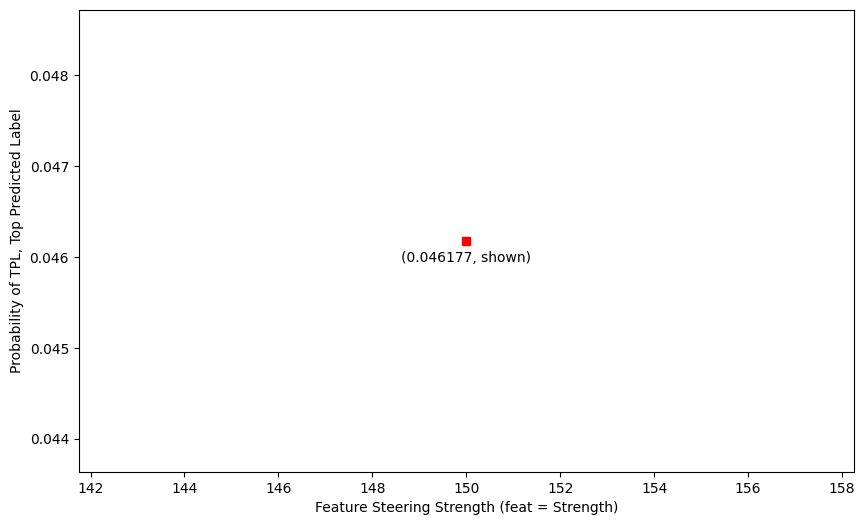

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = [tup[1] for tup in sorted(feat_num_concept_arr)]
y2 = [tup[1] for tup in sorted(feat_num_prob_arr)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line with different colors and markers
plt.plot(np.array(x), y2, 'rs-', label='Prob, Label at Strength')  # Red line with squares

# Label each point
for i in range(len(x)):
    # Labels for series
    plt.annotate(f'({y2[i]:01f}, {y1[i]})', 
                (x[i], y2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
# Customize the plot
plt.xlabel('Feature Steering Strength (feat = Strength)')
plt.ylabel('Probability of TPL, Top Predicted Label')
plt.title(f'Most Likely Class by Feature Steering Strength, Feature {feat_num}\n Label at 0.0: {steering_strength_image_results[str(0.0)][feat_num][image_idx][0][0]}. Label at max steered val ({str(max(steering_strengths))}): {steering_strength_image_results[str(max(steering_strengths))][feat_num][image_idx][0][0]}.')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()


# plt.savefig("test.svg")

# Show the plot
plt.show()

In [ ]:
image_idx = image_idx
feat_num = feat_num

print(f"=====================\nfeat_num: {feat_num}")
feat_num_concept_arr = []
feat_num_concept_arr_2 = []
feat_num_concept_arr_3 = []
feat_num_prob_arr = []
feat_num_prob_arr_2 = []
feat_num_prob_arr_3 = []
for dict_key in steering_strengths:
    # steering_strength_image_results is: [steering_strength][feat_num][image_idx][idx 0 gives concept name/idx 1 gives concept_probability][i in 0-k for img ith-most likely img in top-k]
    
    # concept names
    feat_num_concept_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][0]))
    feat_num_concept_arr_2.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][1]))
    feat_num_concept_arr_3.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][2]))

    # probabilities
    feat_num_prob_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][0].item()))
    feat_num_prob_arr_2.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][1].item()))
    feat_num_prob_arr_3.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][2].item()))


# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = [tup[1] for tup in sorted(feat_num_concept_arr)]
y2 = [tup[1] for tup in sorted(feat_num_prob_arr)]
y1_2 = [tup[1] for tup in sorted(feat_num_concept_arr_2)]
y2_2 = [tup[1] for tup in sorted(feat_num_prob_arr_2)]
y1_3 = [tup[1] for tup in sorted(feat_num_concept_arr_3)]
y2_3 = [tup[1] for tup in sorted(feat_num_prob_arr_3)]

# Create the plot
plt.figure(figsize=(15, 9))

# Plot each line with different colors and markers
plt.plot(np.array(x), y2, 'rs-', label='Prob, Label at Strength')  # Red line with squares
plt.plot(np.array(x), y2_2, 'ms-', label='Prob, Label at Strength')  # Red line with squares
plt.plot(np.array(x), y2_3, 'ys-', label='Prob, Label at Strength')  # Red line with squares

# Label each point
for i in range(len(x)):
    # Labels for series
    plt.annotate(f'({y2[i]:01f}, {y1[i]})', 
                (x[i], y2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    plt.annotate(f'({y2_2[i]:01f}, {y1_2[i]})', 
                (x[i], y2_2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    plt.annotate(f'({y2_3[i]:01f}, {y1_3[i]})', 
                (x[i], y2_3[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
# Customize the plot
plt.xlabel('Feature Steering Strength (feat = Strength)')
plt.ylabel('Probability of TPL, Top Predicted Label')
plt.title(f'Most Likely Class by Feature Steering Strength, Feature {feat_num}\n Label at 0.0: {steering_strength_image_results[str(0.0)][feat_num][image_idx][0][0]}. Label at max steered val ({str(max(steering_strengths))}): {steering_strength_image_results[str(max(steering_strengths))][feat_num][image_idx][0][0]}.')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()


# plt.savefig("test.svg")

# Show the plot
plt.show()

In [26]:
steering_strength_info.keys()
key = 150.0

In [27]:
feat_top_concept_dict = {}

# Steerability metric
for feat_num in steering_strength_image_results[str(steering_strength)].keys():
    feat_num_steerability = feat_num
#     agg_diff_arr = []
#     steerability_arr = []
#     i = 0
#     for key in steering_strength_info:
#         steerability_arr.append(steering_strength_info[key][4][feat_num_steerability].sum().cpu().item())
#         agg_diff_arr.append(steering_strength_info[key][3][feat_num_steerability].cpu().item())

#     import matplotlib.pyplot as plt
#     import numpy as np

#     # Sample data
#     x = [tup[0] for tup in sorted(feat_num_concept_arr)]
#     y1 = agg_diff_arr
#     y2 = steerability_arr

#     # Create the plot
#     plt.figure(figsize=(10, 6))

#     # Plot each line with different colors and markers
#     plt.plot(np.array(x), y1, 'rs-', label='Strength, Aggregate Probability Difference')  # Red line with squares
#     plt.plot(np.array(x), y2, 'ms-', label='Strength, Steerability Score')  # Red line with squares

#     # Label each point
#     for i in range(len(x)):
#         # Labels for series
#         plt.annotate(f'({x[i]:.1f}, {y1[i]:.3f})', 
#                     (x[i], y1[i]), 
#                     textcoords="offset points", 
#                     xytext=(0,-15),
#                     ha='center')
#         plt.annotate(f'({x[i]:.1f}, {y2[i]:.3f})', 
#                     (x[i], y2[i]), 
#                     textcoords="offset points", 
#                     xytext=(0,-15),
#                     ha='center')

#     # Customize the plot
#     plt.xlabel('Feature Steering Strength (feat = Strength)')
#     plt.ylabel('Sum of Probability Difference Over All Tested Images')
#     plt.title(f'Aggregate Probability Difference at different steering strengths, Feature {feat_num_steerability}')
#     plt.legend()
#     plt.grid(True, linestyle='--', alpha=0.7)

#     # Adjust layout to prevent label overlap
#     plt.tight_layout()


    # plt.savefig("test.svg")
    
#     print(steering_strength_info[key][3][feat_num_steerability].sum().cpu().item())
#     print(steering_strength_info[key][4][feat_num_steerability].sum().cpu().item())
    if steering_strength_info[key][4][feat_num_steerability].sum().cpu().item() > .10:
        feat_top_concept_dict[feat_num] = steering_strength_image_results[str(key)][feat_num][image_idx][0][0]

#     # Show the plot
#     plt.show()
#     # image, tuple position, idx of top-k
#     print(feat_num)
#     print(dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0])
#     print(dict_key, "probs", steering_strength_image_results[str(dict_key)][feat_num][image_idx][1])
#     print(steering_strength_info[150.0][4][feat_num_steerability].shape)
#     vals, idxs = torch.topk(steering_strength_info[150.0][5][feat_num_steerability].cpu(), k=10)
#     print("probabilities * abs(probabilities)", vals)
#     print(np.array(selected_vocab)[idxs.cpu()])
    

In [28]:
from collections import Counter
len(Counter(feat_top_concept_dict.values()))

180

In [32]:
sum(featctr.values())

259

In [30]:
Counter(feat_top_concept_dict.values())

Counter({'front': 19,
         'thumbnail': 9,
         'printable': 5,
         'yellow': 5,
         'wooden': 4,
         'dogs': 4,
         'blue': 3,
         'button': 3,
         'purple': 3,
         'mens': 3,
         'branch': 3,
         'dog': 3,
         'lighting': 3,
         'womens': 3,
         'patches': 3,
         'green': 2,
         'drink': 2,
         'pin': 2,
         'brown': 2,
         'overall': 2,
         'navy': 2,
         'poster': 2,
         'watches': 2,
         'black': 2,
         'pair': 2,
         'stamps': 2,
         'tennessee': 2,
         'packaging': 2,
         'rear': 2,
         'brass': 2,
         'pink': 2,
         'certificates': 2,
         'font': 2,
         'cd': 2,
         'restaurants': 2,
         'epson': 2,
         'plates': 1,
         'sub': 1,
         'desert': 1,
         'finished': 1,
         'logo': 1,
         'trees': 1,
         'fruit': 1,
         'racing': 1,
         'plants': 1,
         'photo': 1

<BarContainer object of 180 artists>

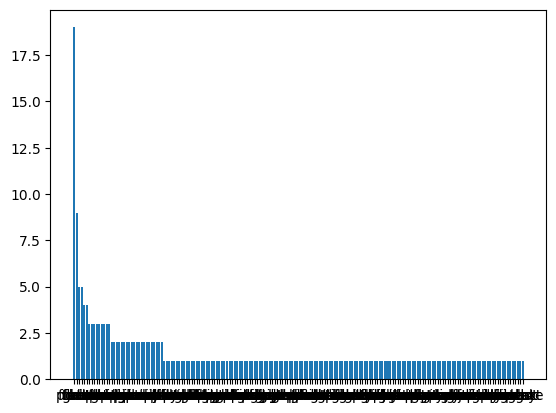

In [31]:
Counter(feat_top_concept_dict.values())
import matplotlib.pyplot as plt
featctr = Counter(feat_top_concept_dict.values())
plt.bar(featctr.keys(), sorted(featctr.values(), reverse=True) )

feat: 48551
asymptotic_steering_specificity: 0.010105649009346962
asymptotic_steering_power: 0.04604757949709892
asymptotic_steering_power percent: 4.60%
specificity/power: 0.21946102530717462
feat: 35466
asymptotic_steering_specificity: 0.006376736331731081
asymptotic_steering_power: 0.02418985590338707
asymptotic_steering_power percent: 2.42%
specificity/power: 0.2636120015431017
feat: 35504
asymptotic_steering_specificity: 0.008819958195090294
asymptotic_steering_power: 0.03539782762527466
asymptotic_steering_power percent: 3.54%
specificity/power: 0.24916665193297602
feat: 12636
asymptotic_steering_specificity: 0.6336269974708557
asymptotic_steering_power: 0.7871698141098022
asymptotic_steering_power percent: 78.72%
specificity/power: 0.8049432106176662
feat: 41508
asymptotic_steering_specificity: 0.0086049884557724
asymptotic_steering_power: 0.036476634442806244
asymptotic_steering_power percent: 3.65%
specificity/power: 0.23590412293285015
feat: 18174
asymptotic_steering_specific

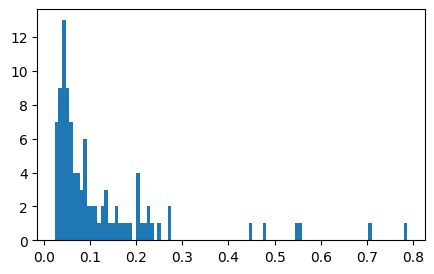

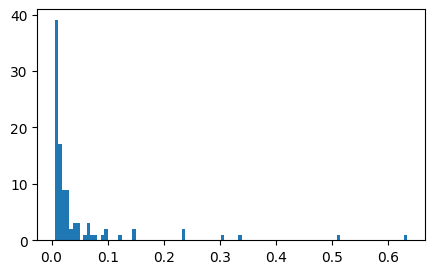

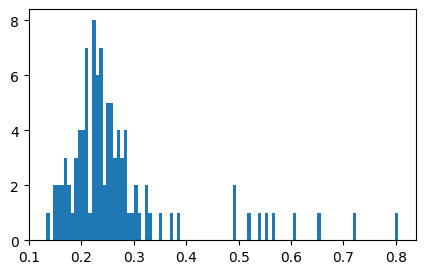

In [60]:
# SAE steering power and specificity metrics:

sae_asps = []
sae_asy_str_specs = []
sae_asrs = []
for feat_num in steering_strength_image_results[str(steering_strength)].keys():
    feat_num_steerability = feat_num
    
    asymptote_key = max([float(key) for key in steering_strength_info.keys()])
    asymptotic_steering_specificity = steering_strength_info[asymptote_key][4][feat_num_steerability].sum().cpu().item()
    asymptotic_steering_power = steering_strength_info[asymptote_key][3][feat_num_steerability].cpu().item()
    
    print(f"feat: {feat_num_steerability}")
    print(f"asymptotic_steering_specificity: {asymptotic_steering_specificity}")
    print(f"asymptotic_steering_power: {asymptotic_steering_power}")
    print(f"asymptotic_steering_power percent: {(asymptotic_steering_power * 100):.2f}%")
    print(f"specificity/power: {asymptotic_steering_specificity/asymptotic_steering_power}")
    
    sae_asps.append(asymptotic_steering_power)
    sae_asy_str_specs.append(asymptotic_steering_specificity)
    sae_asrs.append(asymptotic_steering_specificity/asymptotic_steering_power)


print(f"\nSAE: {selected_sae_weights}")
print(f"\nSAE avg power: {np.array(sae_asps).mean()}")
print(f"SAE avg specificity: {np.array(sae_asy_str_specs).mean()}")
print(f"SAE avg s/p ratio: {np.array(sae_asrs).mean()}")

plt.figure(figsize=(5, 3))
plt.hist(sae_asps, bins=100)
plt.show()

plt.figure(figsize=(5, 3))
plt.hist(sae_asy_str_specs, bins=100)
plt.show()

plt.figure(figsize=(5, 3))
plt.hist(sae_asrs, bins=100)
plt.show()

### Prev Code

In [ ]:
len(feature_steered_embeds[random_feat_idxs[0]])

In [ ]:
default_embeds.shape
len(default_embeds_list)
default_embeds = torch.cat(default_embeds_list)
default_embeds.shape

In [ ]:

len(altered_embeds_list), altered_embeds_list[0].shape, default_embeds.shape

In [ ]:
og_model.cuda()

In [ ]:
with open("/workspace/clip_dissect_raw.txt", "r") as f:
    larger_vocab = [line[:-1] for line in f.readlines()][:5000]

# with open("/workspace/better_img_desc.txt", "r") as f:
#     larger_vocab = [line[:-1] for line in f.readlines()][:5000]

In [ ]:
# use clip vocab here and compare embeds
import torch
from PIL import Image

tokenizer = open_clip.get_tokenizer('ViT-B-32')
text = tokenizer(larger_vocab)
text_features = og_model.encode_text(text.cuda())
text_features_normed = text_features/text_features.norm(dim=-1, keepdim=True)


print(f"text_features_normed.shape: {text_features_normed.shape}")
text_probs_altered_list = []
with torch.no_grad(), torch.cuda.amp.autocast():
    for key in feature_steered_embeds:
        print(key)
        # embeds already have L2 norm of 1
        text_probs_altered = (100.0 * torch.stack(feature_steered_embeds[key]) @ text_features_normed.T).softmax(dim=-1)
        text_probs_altered_list.append(text_probs_altered)
    text_probs_default = (100.0 * default_embeds @ text_features_normed.T).softmax(dim=-1)

print("Label probs altered:", text_probs_altered.shape)  # prints: [[1., 0., 0.]]
print("Label probs default:", text_probs_default.shape)  # prints: [[1., 0., 0.]]

### Summed Logit Difference

In [ ]:
# subtract from default, label, and print trends
text_probs_altered.shape

# selected_vocab = all_imagenet_class_names
selected_vocab = larger_vocab

top_concept_per_feat = {}
top_val_per_feat = {}
top_diff_per_feat = {}
top_ratio_per_feat = {}
# run this for sampled features over all of imagenet eval
for j, text_probs_altered in enumerate(text_probs_altered_list):
    print(f"{'============================================'*2}\n\nFor Feature {random_feat_idxs[j]}")
    print("actual image content:")
    default_vals_softmax, default_idxs_softmax = torch.topk(text_probs_default,k=10)
    print(default_vals_softmax, "\n", np.array(selected_vocab)[default_idxs_softmax.cpu()])
    
    
    logit_diff = text_probs_altered - text_probs_default
    logit_diff_aggregate = logit_diff.sum(dim=0)
    
    logit_ratio = text_probs_altered/text_probs_default
    logit_ratio_aggregate = logit_ratio.mean(dim=0)
    
    print(f"text_probs_altered.softmax(): {text_probs_altered.softmax(1).shape}")
    text_probs_altered_softmax = text_probs_altered.softmax(1)
    vals_softmax, idxs_softmax = torch.topk(text_probs_altered_softmax,k=10)
    
#     print(f"text_probs_altered.softmax(): {text_probs_altered.sum(0).softmax(0).shape}")
#     text_probs_altered_softmax_agg = text_probs_altered.sum(0).softmax(0)
#     vals_softmax_agg, idxs_softmax_agg = torch.topk(text_probs_altered_softmax_agg,k=10)
    
    print(f"\nSoftmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax}")
    print(np.array(selected_vocab)[idxs_softmax.cpu()])
    for i in range(vals_softmax.shape[0]):
        print(vals_softmax[i], "\n", np.array(selected_vocab)[idxs_softmax.cpu()][i])
        break
        
#     print(f"\nAgg Softmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax_agg}")
#     print(np.array(selected_vocab)[idxs_softmax_agg.cpu()])
    
    vals_agg, idxs_agg = torch.topk(logit_diff_aggregate,k=10)
    vals_least_agg, idxs_least_agg = torch.topk(logit_diff_aggregate,k=10,largest=False)
    
    ratios_agg, ratios_idxs_agg = torch.topk(logit_ratio_aggregate,k=10)
    ratios_least_agg, ratios_idxs_least_agg = torch.topk(logit_ratio_aggregate,k=10,largest=False)
    
    vals, idxs = torch.topk(logit_diff,k=5)
    vals_least, idxs_least = torch.topk(logit_diff,k=5,largest=False)
    
    ratios, ratios_idxs = torch.topk(logit_ratio,k=5)
    ratios_least, ratios_idxs_least = torch.topk(logit_ratio,k=5,largest=False)
    
    top_concept_per_feat[random_feat_idxs[j]] = np.array(selected_vocab)[idxs_softmax.cpu()][0][0]
    top_val_per_feat[random_feat_idxs[j]] = vals_softmax[0][0]
    top_diff_per_feat[random_feat_idxs[j]] = vals_agg[0]
    top_ratio_per_feat[random_feat_idxs[j]] = ratios_agg[0]
    
    
    print(f"\nMost Changed, by Absolute Diff Over {logit_diff.shape[0]} Images:\n{vals_agg}")
    print(np.array(selected_vocab)[idxs_agg.cpu()])
    print(vals_least_agg)
    print(np.array(selected_vocab)[idxs_least_agg.cpu()])
    
    print(f"\nMost Changed, by Ratio Over {logit_diff.shape[0]} Images:")
    print(ratios_agg)
    print(np.array(selected_vocab)[ratios_idxs_agg.cpu()])
    print(vals_least_agg)
    print(np.array(selected_vocab)[ratios_idxs_least_agg.cpu()])

In [ ]:
top_concept_per_feat,top_val_per_feat,top_ratio_per_feat

In [ ]:
steering_strength_info = {}
steering_strength_info[steering_strength] = (top_concept_per_feat,top_val_per_feat,top_ratio_per_feat,top_diff_per_feat)


In [ ]:
steering_strength_info[steering_strength][0].keys()

In [ ]:
steering_strength_info

In [ ]:
i = 0
for feat_num in steering_strength_info[steering_strength][0].keys():
    print(f"=====================\nfeat_num: {feat_num}")
    feat_num_concept_arr = []
    feat_num_prob_arr = []
    feat_num_ratio_arr = []
    for key in steering_strength_info:
        print(key, steering_strength_info[key][0][feat_num])
        feat_num_concept_arr.append((key, steering_strength_info[key][0][feat_num]))
        print(key, steering_strength_info[key][1][feat_num])
        feat_num_prob_arr.append((key, steering_strength_info[key][1][feat_num].item()))
        print(key, steering_strength_info[key][2][feat_num])
        feat_num_ratio_arr.append((key, steering_strength_info[key][2][feat_num].item()))
    i += 1
    if i > 5:
        break

In [ ]:
sorted(feat_num_concept_arr),sorted(feat_num_prob_arr),sorted(feat_num_ratio_arr),

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = [tup[1] for tup in sorted(feat_num_concept_arr)]
y2 = [tup[1] for tup in sorted(feat_num_prob_arr)]
# y3 = [tup[1] for tup in sorted(feat_num_ratio_arr)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line with different colors and markers
# plt.plot(x, y1, 'bo-', label='Series 1')  # Blue line with circles
plt.plot(np.array(x), y2, 'rs-', label='Series 2')  # Red line with squares
# plt.plot(x, y3, 'gd-', label='Series 3')  # Green line with diamonds

# Label each point for all three series
for i in range(len(x)):
#     # Labels for series 1
#     plt.annotate(f'({x[i]}, {y1[i]})', 
#                 (x[i], y1[i]), 
#                 textcoords="offset points", 
#                 xytext=(0,10),
#                 ha='center')
    
    # Labels for series 2
    plt.annotate(f'({y2[i]:01f}, {y1[i]})', 
                (x[i], y2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
#     # Labels for series 3
#     plt.annotate(f'({x[i]}, {y3[i]})', 
#                 (x[i], y3[i]), 
#                 textcoords="offset points", 
#                 xytext=(0,10),
#                 ha='center')

# Customize the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Most Likely Class by Feature Steering Strength, Feature {feat_num}\n Label at 0.0: {steering_strength_info[0.0][0][feat_num]}. Label at max steered val: {steering_strength_info[max(list(steering_strength_info.keys()))][0][feat_num]}.')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.show()

## Enc/Dec Clustering/Exploration

In [ ]:
encoder_weights_for_math = sparse_autoencoder.W_enc
decoder_weights_for_math = sparse_autoencoder.W_dec

In [ ]:
dists_from_feat_0 = encoder_weights_for_math[0] - encoder_weights_for_math

In [ ]:
dists_from_feat_0_normalized = encoder_weights_for_math[0]/encoder_weights_for_math[0].norm(p=2) - encoder_weights_for_math/encoder_weights_for_math.norm(p=2,dim=0)

In [ ]:
dists_from_feat_0.norm(p=2, dim=0).shape

In [ ]:
# plt.hist(bins[:-1], bins)
plt.hist(dists_from_feat_0.norm(p=2, dim=0).cpu(), density=True, bins=1000, histtype='step')  # density=False would make counts
plt.title('Encoder Dist from feat 0')
plt.ylabel('L2 Distance')
plt.xlabel('Density (of ~50k feats)');


In [ ]:
torch.topk(dists_from_feat_0.norm(p=2, dim=0),k=10,largest=False)

In [ ]:
dec_dists_from_feat_0 = decoder_weights_for_math[0]/decoder_weights_for_math[0].norm(p=2) - decoder_weights_for_math/decoder_weights_for_math.norm(p=2)
dec_dists_from_feat_0.shape

In [ ]:
# plt.hist(bins[:-1], bins)
plt.hist(dec_dists_from_feat_0.T.norm(p=2, dim=0).cpu(), density=True, bins=1000, histtype='step')  # density=False would make counts
plt.title('Decoder Dist from feat 0')
plt.ylabel('L2 Distance')
plt.xlabel('Density (of ~50k feats)');


In [ ]:
torch.topk(dec_dists_from_feat_0.T.norm(p=2, dim=0),k=10,largest=False)

In [ ]:
dec_dists_from_feat_0.T.norm(p=2, dim=0).shape